## 概要
priorが動かないという最もシンプルな条件において、$\mu_p, \sigma_p$がどのように表現されているかを調べる。調べる対象は$\alpha_{sub}=1$のモデルと$\alpha_{sub}=0.1$のモデル。

In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [2]:
sigma_sq = 0.5

In [3]:
def make_signal_for_prior(time_length, mu_p, sigma_p, uncertainty=0.5, g=1.25):
    input_signals = np.zeros([1, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    
    state = State(mu=mu_p, sigma=sigma_p)
    
    for i in range(1):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state()
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals

In [4]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220526_4_stable/20220526_4_stable.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220526_4_stable


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [52]:
sigma_l = math.sqrt(1/1.25) * 0.5
mu_p_list = []
sigma_p_list = []

neural_states = np.zeros((300, 50, 200))
reservoir_states = np.zeros((300, 50, 50))
for i in range(300):
    mu_p = np.random.rand()-0.5
    sigma_p = np.random.rand()*0.8
    mu_p_list.append(mu_p)
    sigma_p_list.append(sigma_p)
    input_signal = make_signal_for_prior(
        time_length=50, 
        mu_p=mu_p,
        sigma_p=sigma_p,
        uncertainty=0.5,
        g=1.25,
    )
    inputs = torch.from_numpy(input_signal).float()                                 
    inputs = inputs.to(device) 
    hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
    reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device) 
    reservoir = torch.from_numpy(reservoir_np).float()
    reservoir = reservoir.to(device)
    hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
        
    neural_dynamics = hidden_list.cpu().detach().numpy()   
    reservoir_dynamics = reservoir_list.cpu().detach().numpy()
        
    neural_states[i] = neural_dynamics[0, :]
    reservoir_states[i] = reservoir_dynamics[0, :]

In [53]:
reservoir_states.shape

(300, 50, 50)

In [54]:
reservoir_last_10_average = np.mean(reservoir_states[:, -10:, :], axis=1)
neural_last_10_average = np.mean(neural_states[:, -10:, :], axis=1)

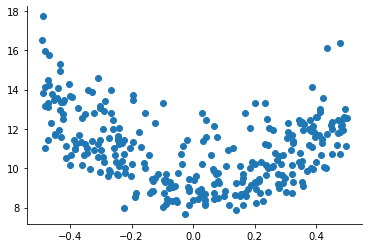

In [55]:
plt.scatter(
    mu_p_list,
    np.linalg.norm(reservoir_last_10_average, axis=1),
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

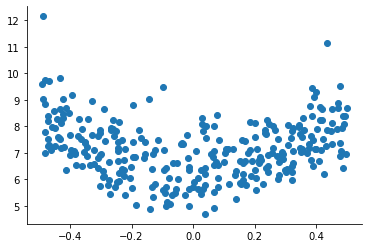

In [56]:
plt.scatter(
    mu_p_list,
    np.linalg.norm(neural_last_10_average, axis=1),
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

In [57]:
np.var(reservoir_states[:, -1, :], axis=0)

array([1.1873937 , 2.30137112, 0.00495992, 0.03231662, 1.02887774,
       1.16245542, 1.02165338, 2.09621579, 1.45734658, 0.01606226,
       0.21285181, 1.54587863, 0.00532409, 0.08474105, 0.52929788,
       0.03641508, 0.16807186, 0.00562658, 0.01784215, 0.00833505,
       0.06450616, 0.00598176, 0.04765513, 0.98437709, 4.62400253,
       0.05401657, 1.14844201, 2.81206153, 2.97099   , 1.00437455,
       0.01776306, 0.40703806, 2.77392327, 1.99493359, 0.66703902,
       1.66230471, 0.00671722, 0.00551798, 0.9515501 , 2.04992554,
       0.0476581 , 0.16484846, 0.61851235, 0.18148628, 1.65577636,
       0.55595936, 0.16689645, 0.00562991, 0.63495175, 1.46194998])

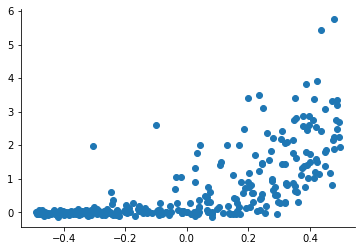

In [58]:
plt.scatter(
    mu_p_list,
    reservoir_last_10_average[:, 0],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

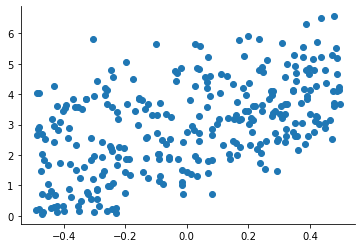

In [59]:
plt.scatter(
    mu_p_list,
    reservoir_last_10_average[:, 1],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

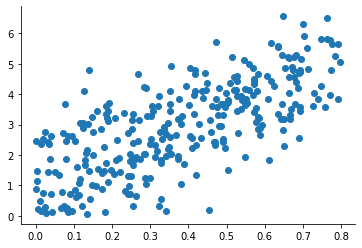

In [60]:
plt.scatter(
    sigma_p_list,
    reservoir_last_10_average[:, 1],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

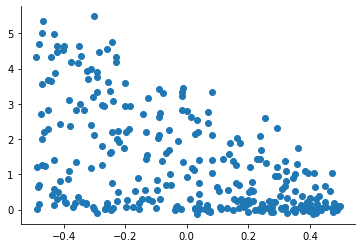

In [61]:
plt.scatter(
    mu_p_list,
    reservoir_last_10_average[:, 7],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

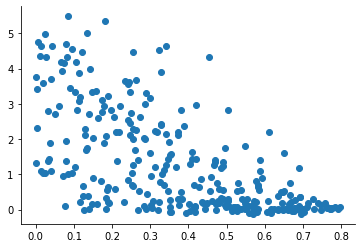

In [62]:
plt.scatter(
    sigma_p_list,
    reservoir_last_10_average[:, 7],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

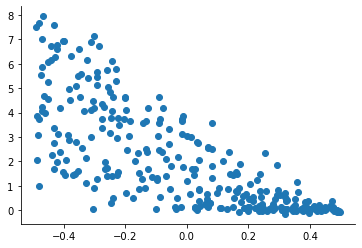

In [63]:
plt.scatter(
    mu_p_list,
    reservoir_last_10_average[:, 24],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

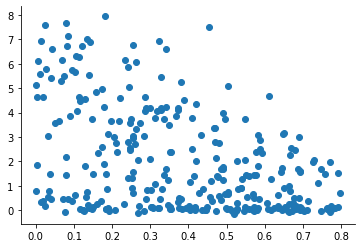

In [64]:
plt.scatter(
    sigma_p_list,
    reservoir_last_10_average[:, 24],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

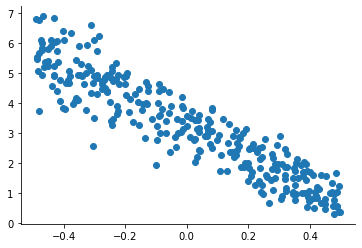

In [65]:
plt.scatter(
    mu_p_list,
    reservoir_last_10_average[:, 27],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

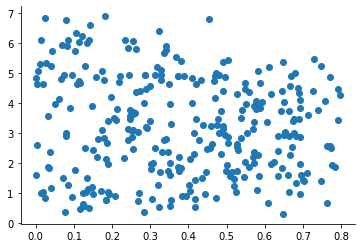

In [66]:
plt.scatter(
    sigma_p_list,
    reservoir_last_10_average[:, 27],
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()

0


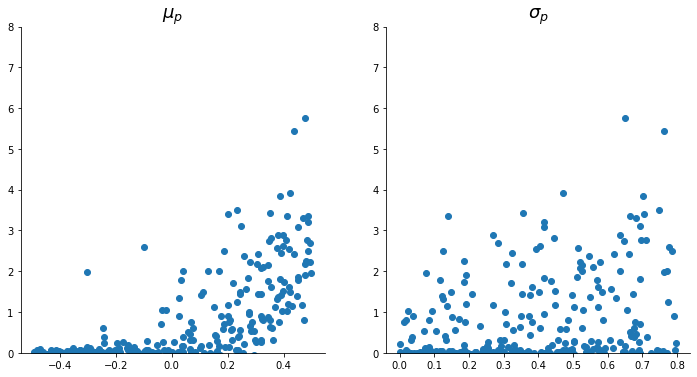

1


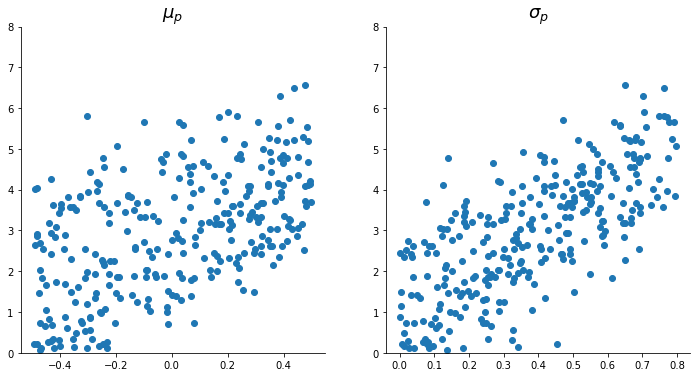

2


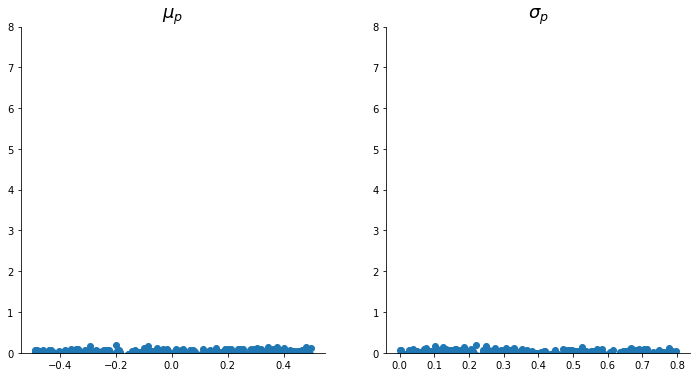

3


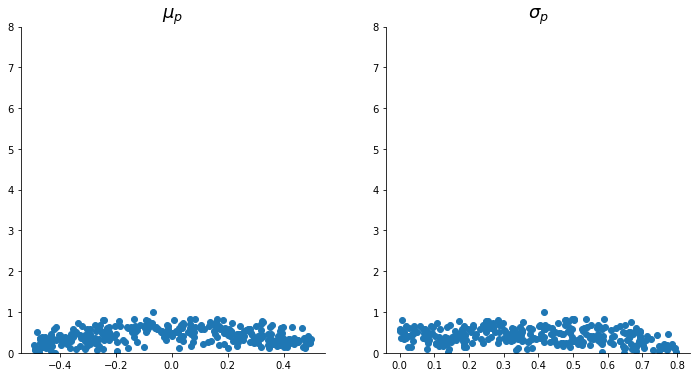

4


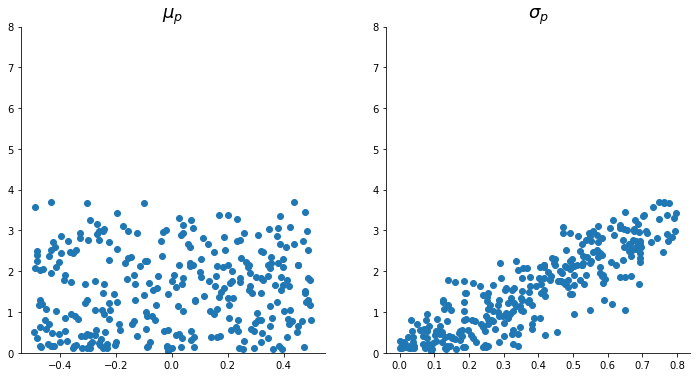

5


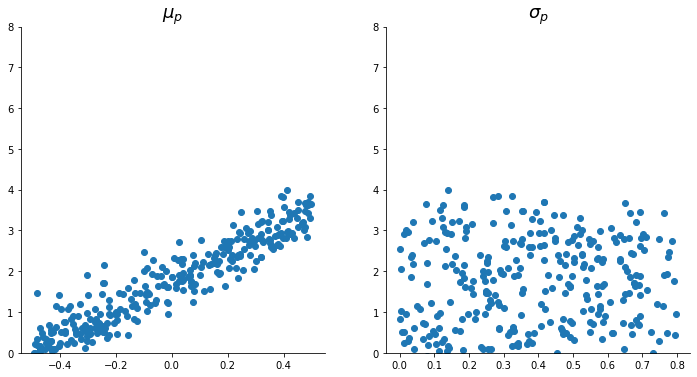

6


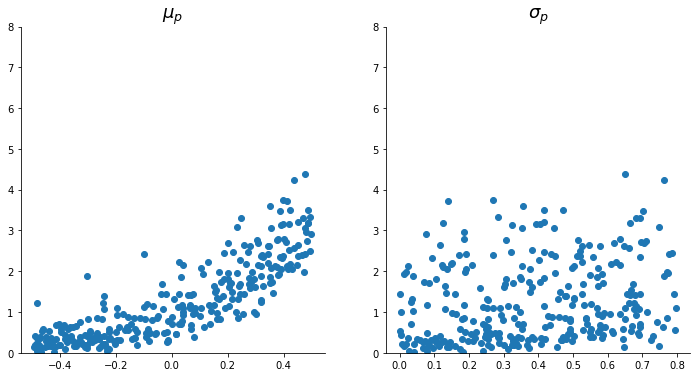

7


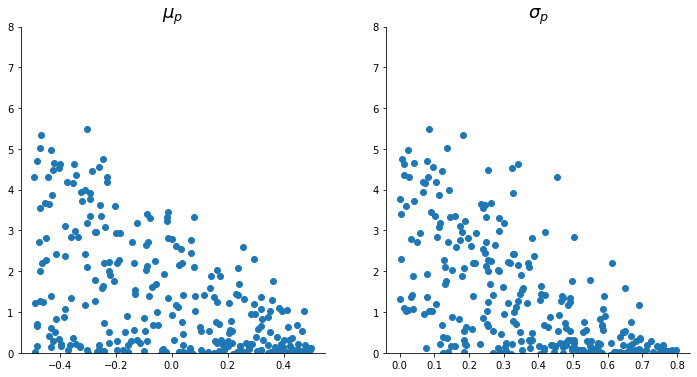

8


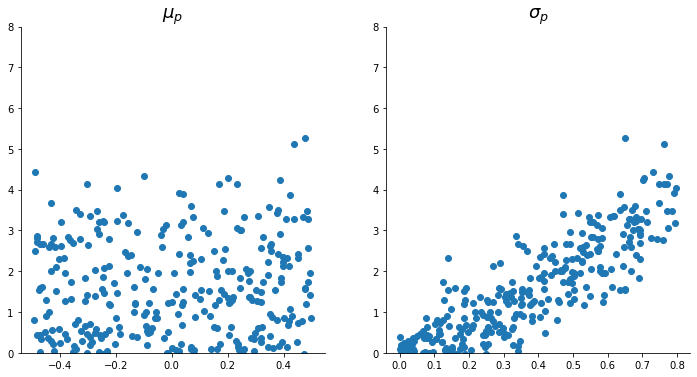

9


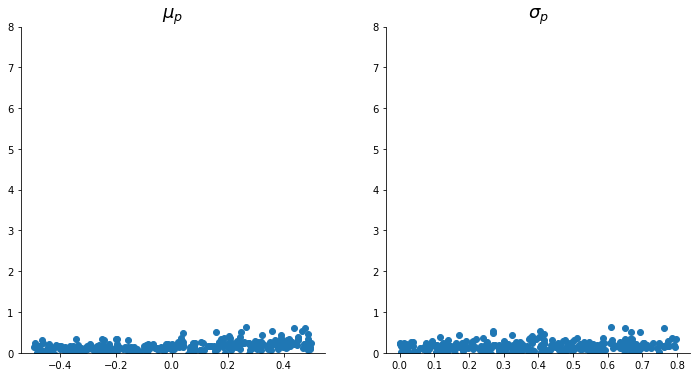

10


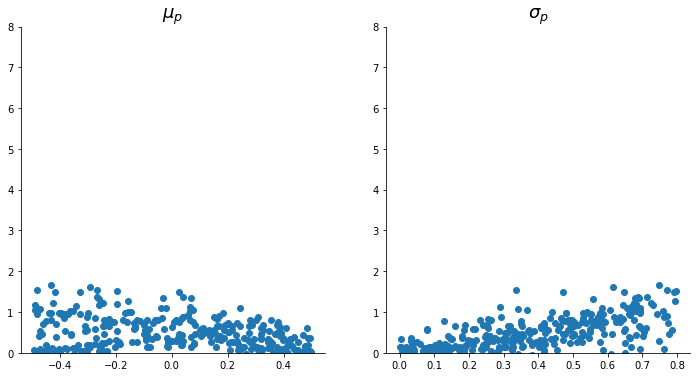

11


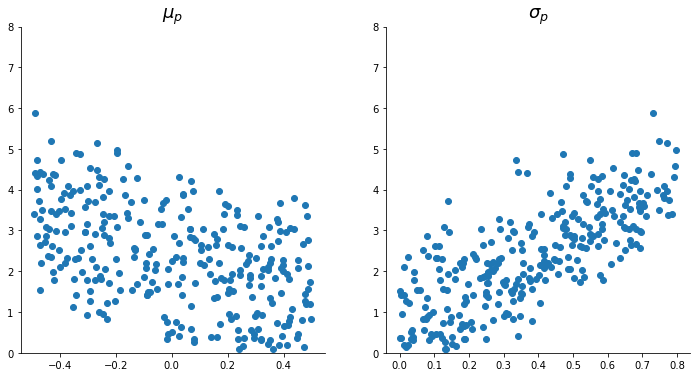

12


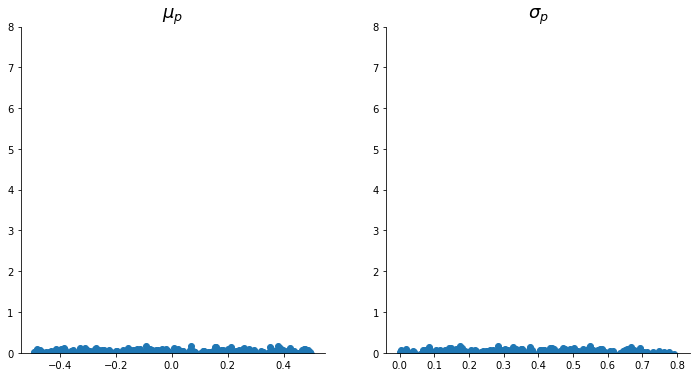

13


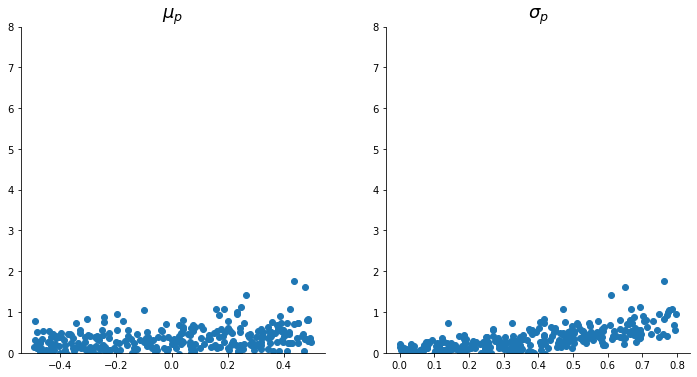

14


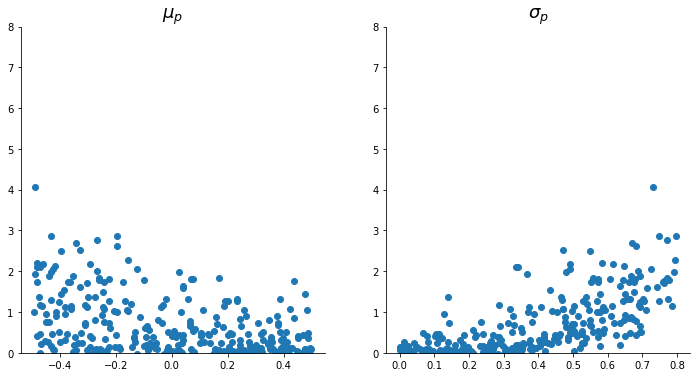

15


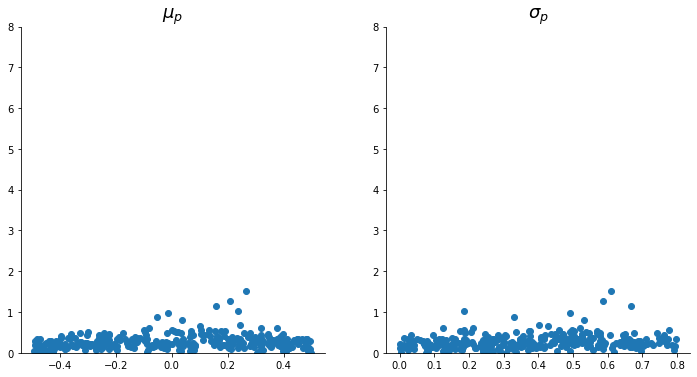

16


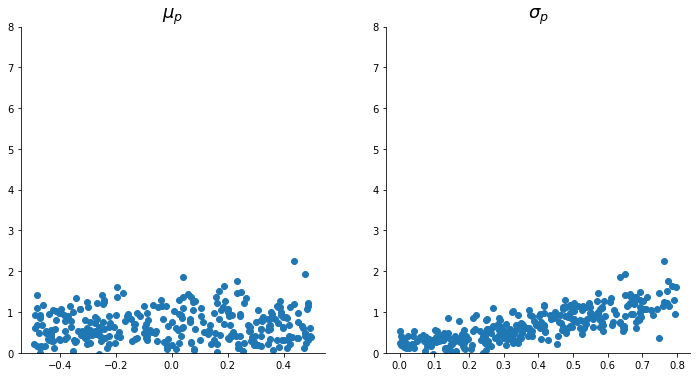

17


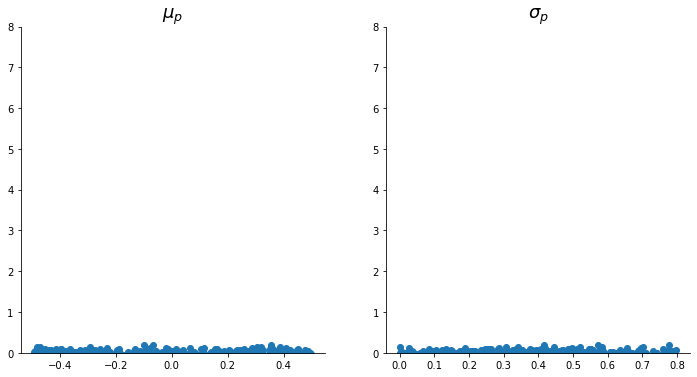

18


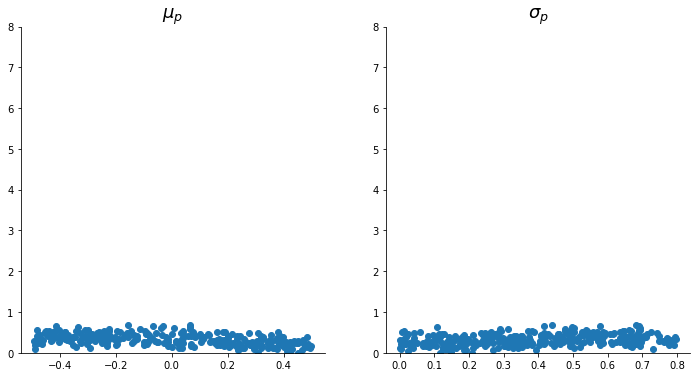

19


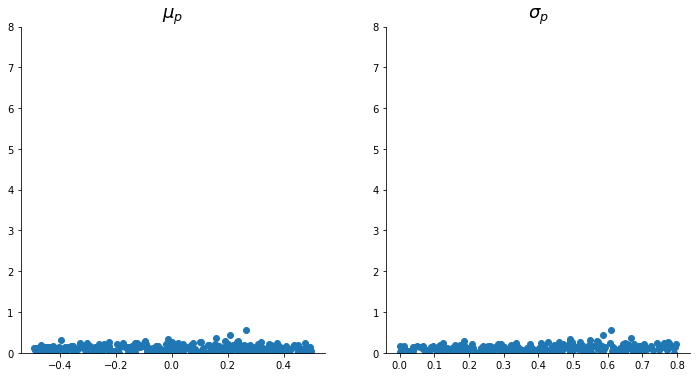

20


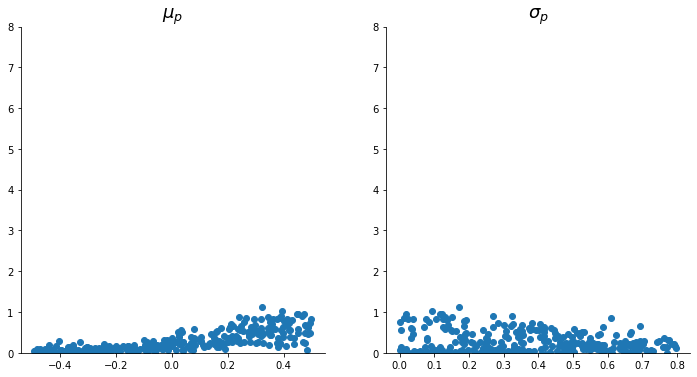

21


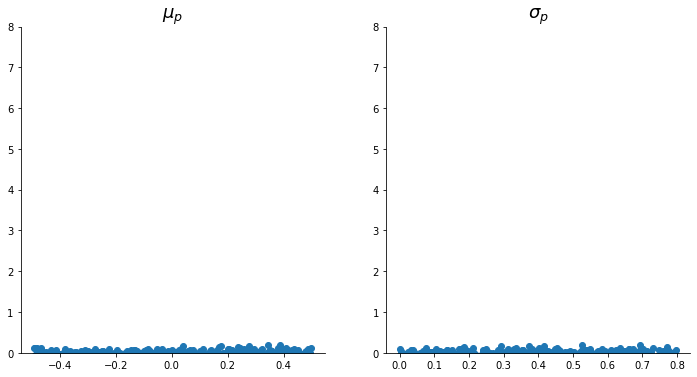

22


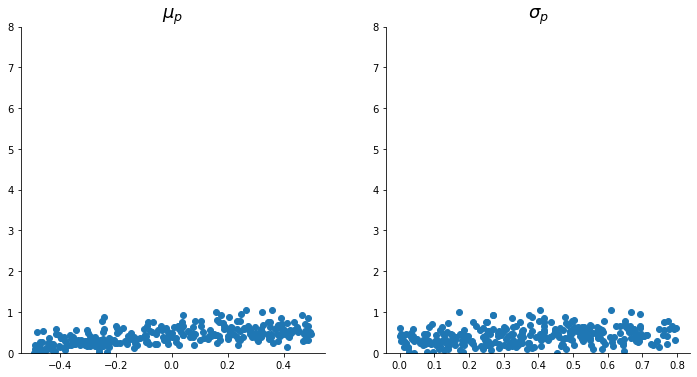

23


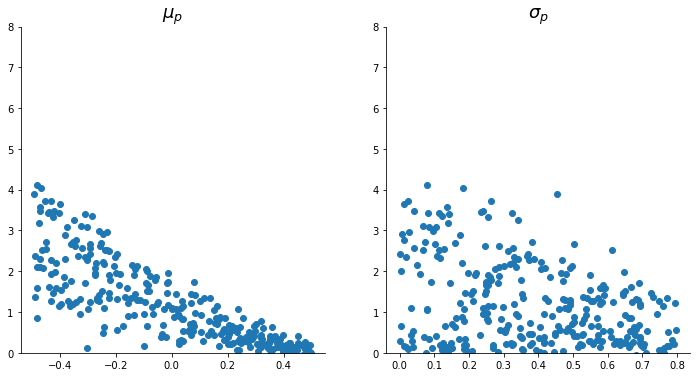

24


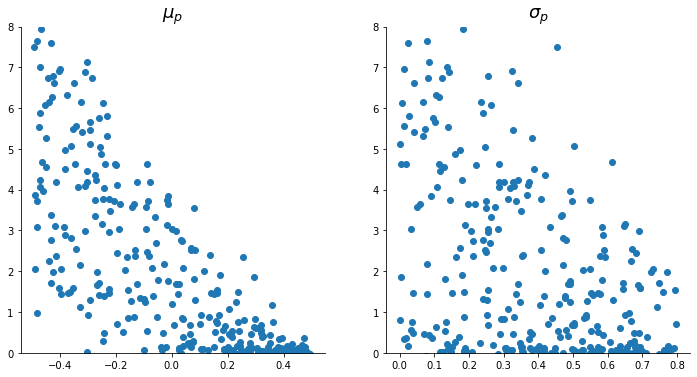

25


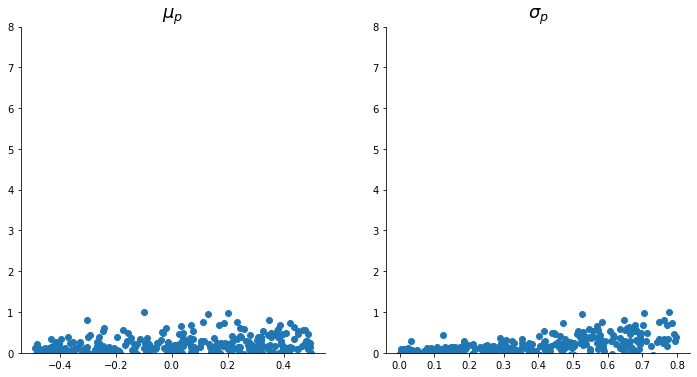

26


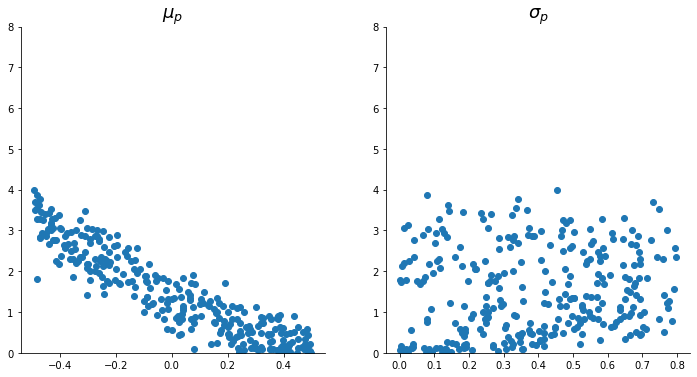

27


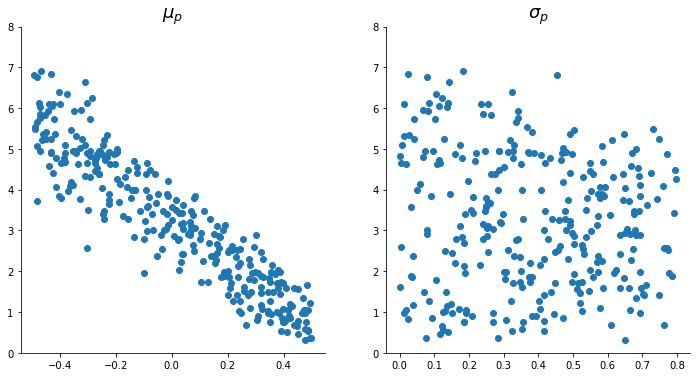

28


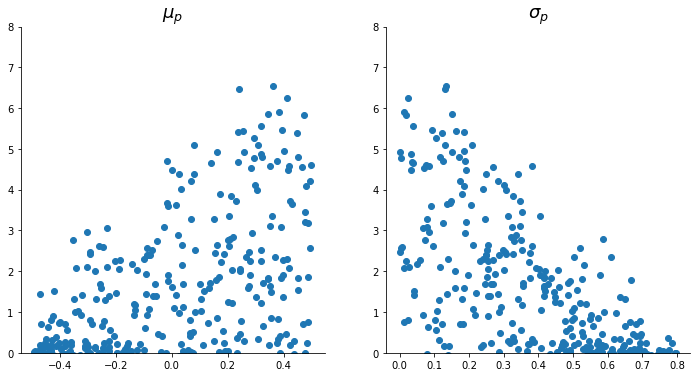

29


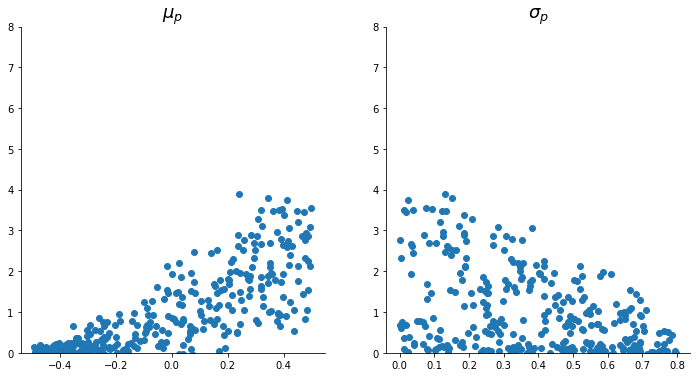

30


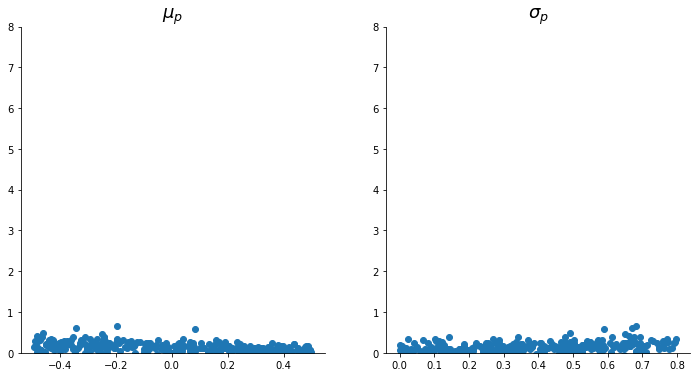

31


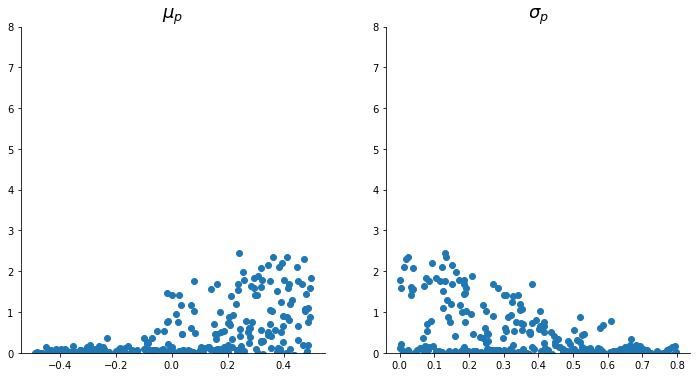

32


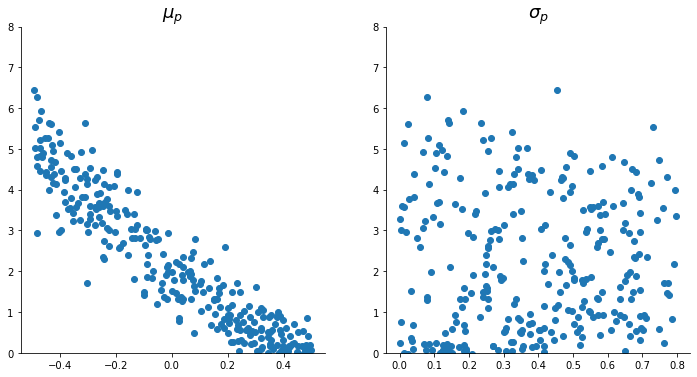

33


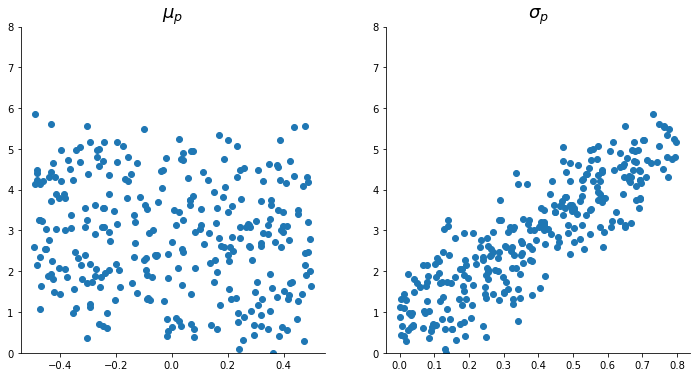

34


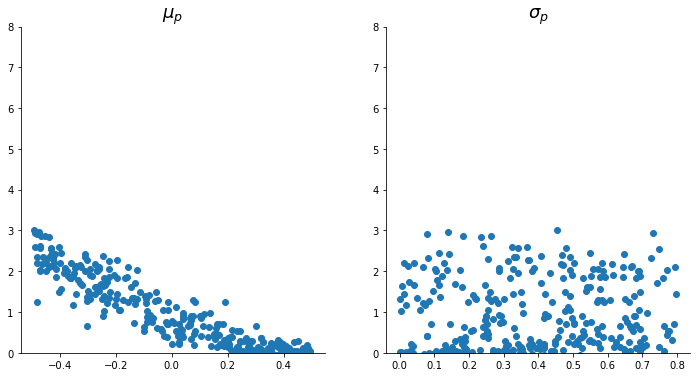

35


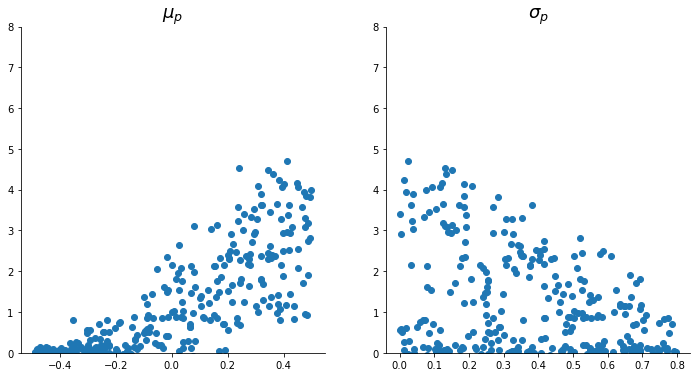

36


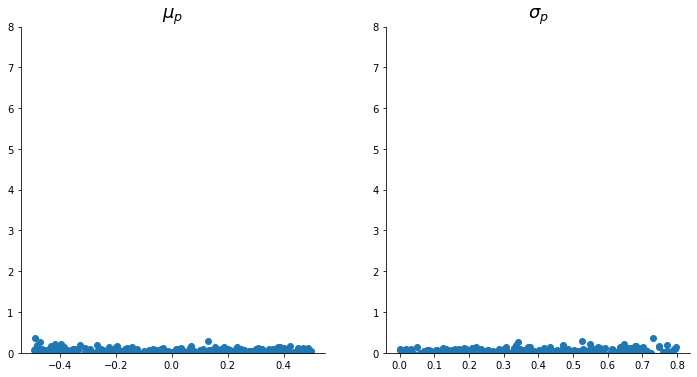

37


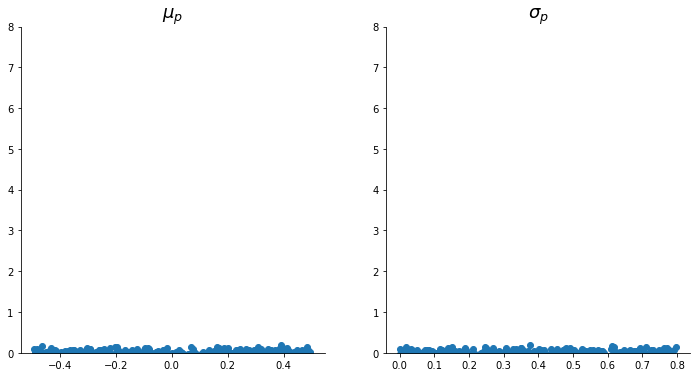

38


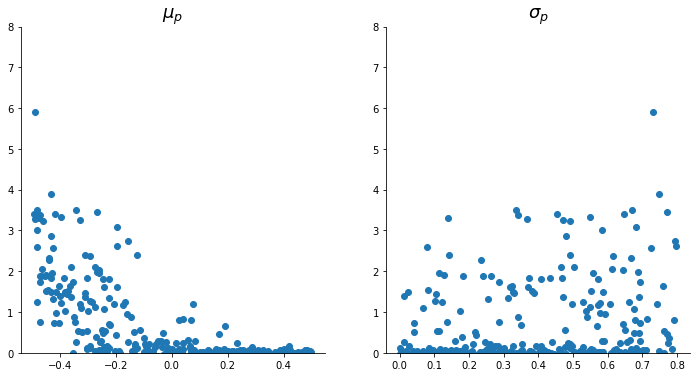

39


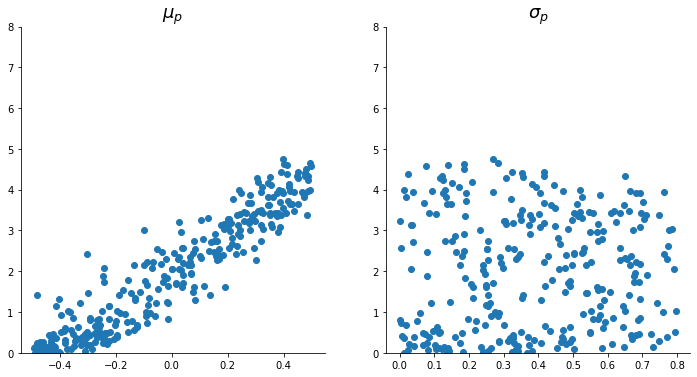

40


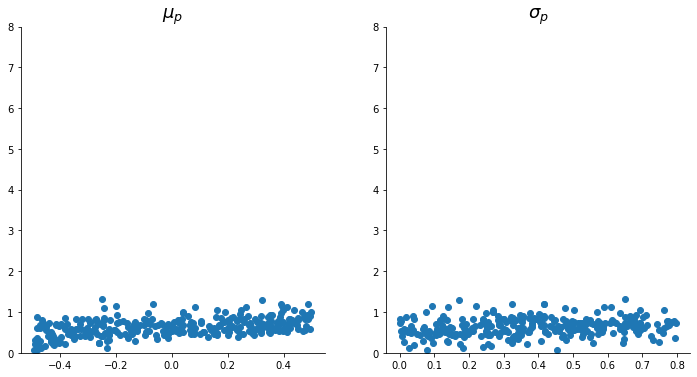

41


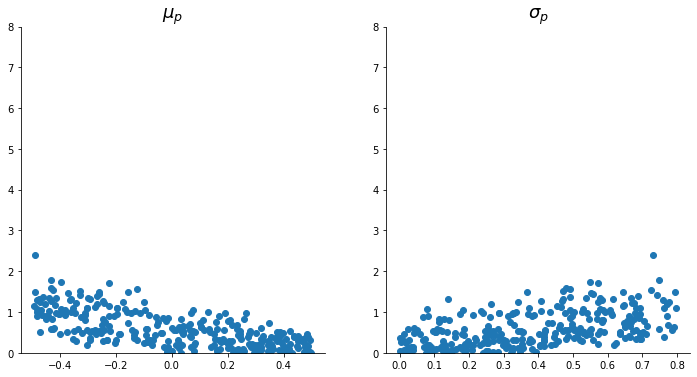

42


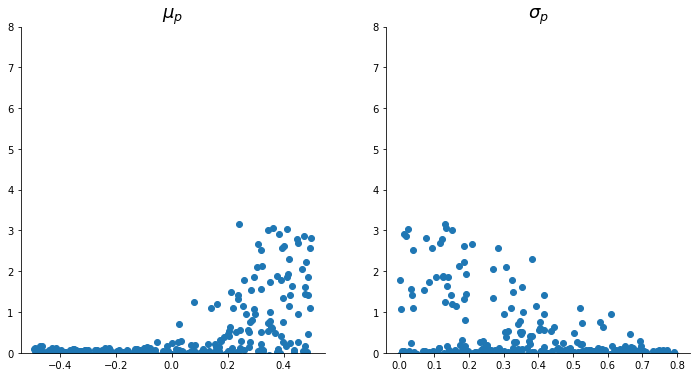

43


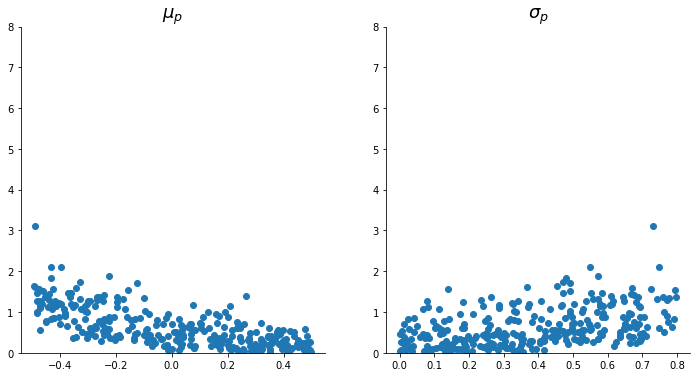

44


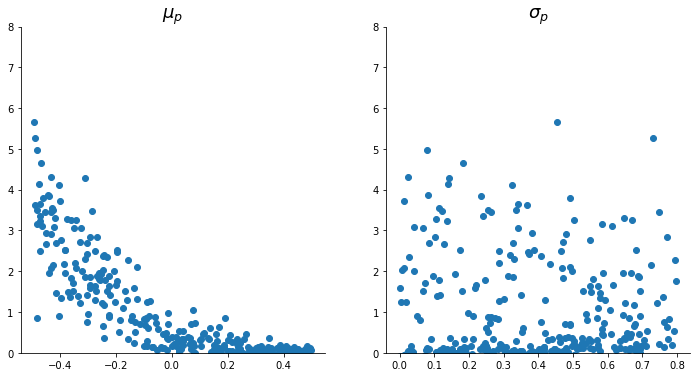

45


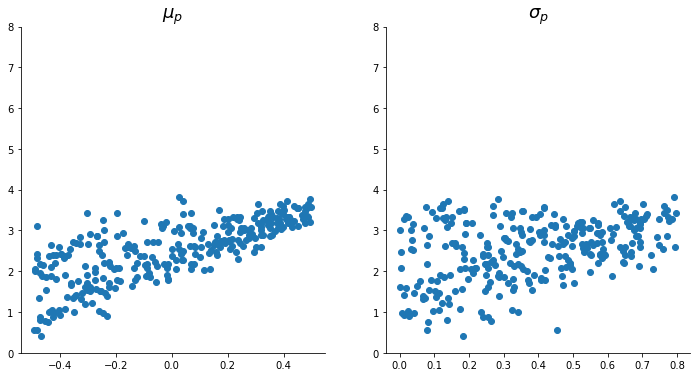

46


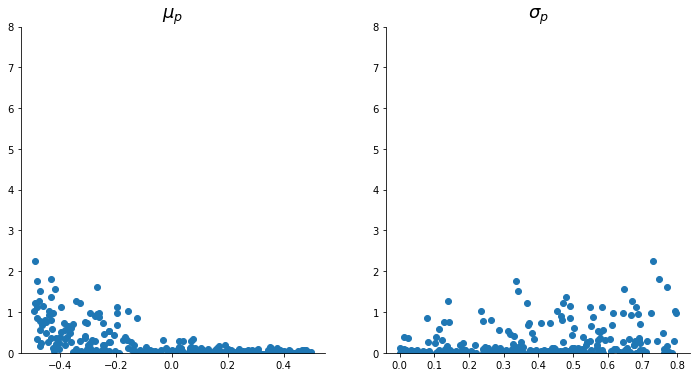

47


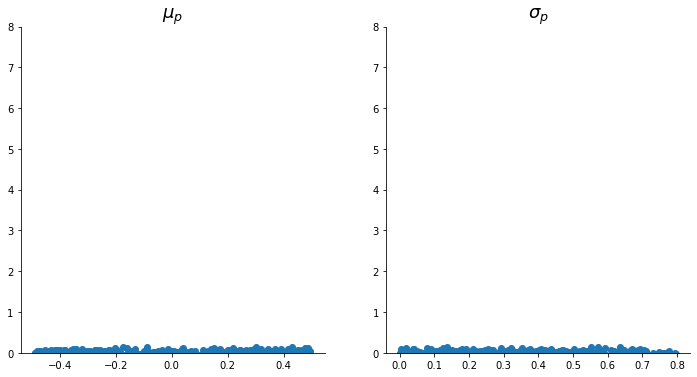

48


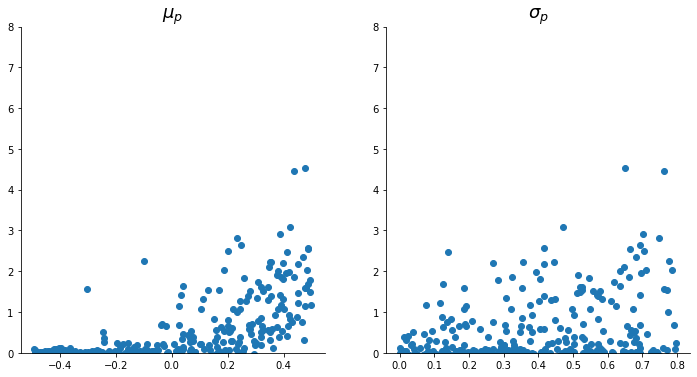

49


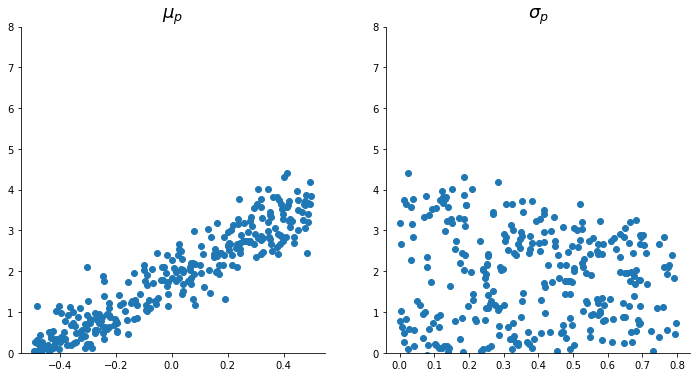

In [67]:
for i in range(50):
    print(i)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(
        mu_p_list,
        reservoir_last_10_average[:, i],
    )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.ylim([0, 8])
    plt.title(r'$\mu_p$', fontsize=18)
    
    plt.subplot(1, 2, 2)
    plt.scatter(
        sigma_p_list,
        reservoir_last_10_average[:, i],
    )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.title(r'$\sigma_p$', fontsize=18)
    plt.ylim([0, 8])
    plt.show()

In [68]:
mu_p_list[:4]

[-0.15652555773882848,
 0.4013239887828698,
 -0.18595426769741863,
 0.20785011527327257]

In [69]:
sigma_p_list[:4]

[0.7928649539067324,
 0.18458457591614075,
 0.059951398243266146,
 0.5859847189359905]

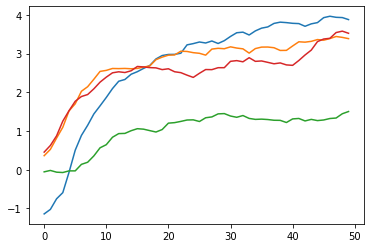

In [70]:
plt.plot(reservoir_states[0, :, 1])
plt.plot(reservoir_states[1, :, 1])
plt.plot(reservoir_states[2, :, 1])
plt.plot(reservoir_states[3, :, 1])

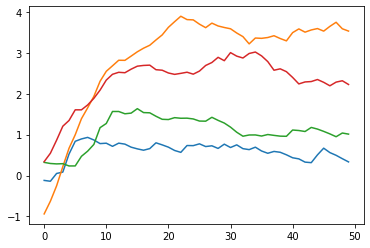

In [71]:
plt.plot(reservoir_states[0, :, 5])
plt.plot(reservoir_states[1, :, 5])
plt.plot(reservoir_states[2, :, 5])
plt.plot(reservoir_states[3, :, 5])

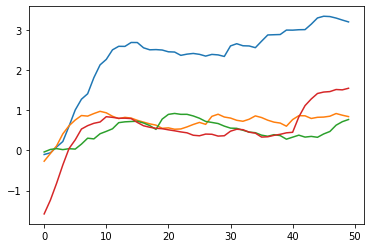

In [72]:
plt.plot(reservoir_states[0, :, 8])
plt.plot(reservoir_states[1, :, 8])
plt.plot(reservoir_states[2, :, 8])
plt.plot(reservoir_states[3, :, 8])

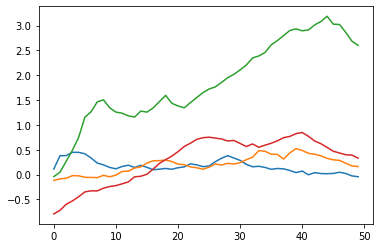

In [73]:
plt.plot(reservoir_states[0, :, 7])
plt.plot(reservoir_states[1, :, 7])
plt.plot(reservoir_states[2, :, 7])
plt.plot(reservoir_states[3, :, 7])

In [74]:
reservoir_average = np.mean(reservoir_states[:, :, :], axis=0)

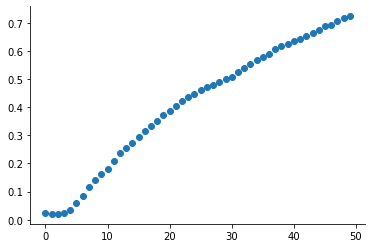

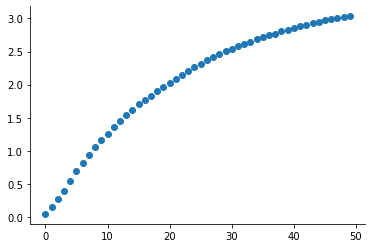

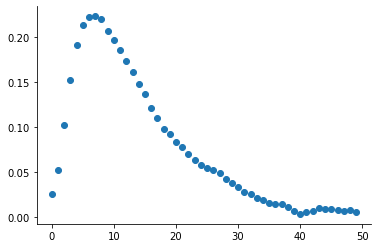

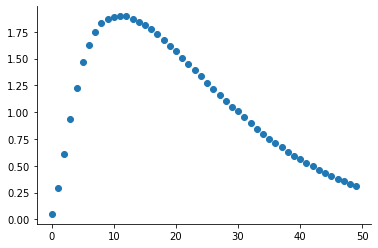

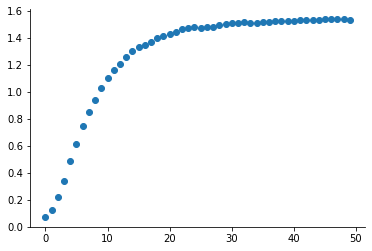

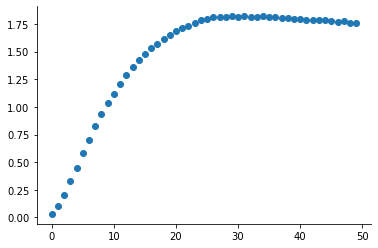

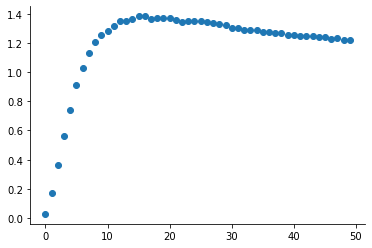

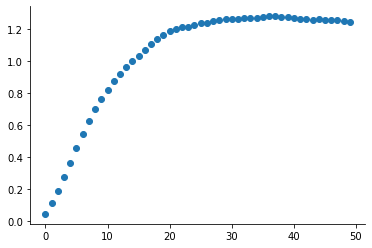

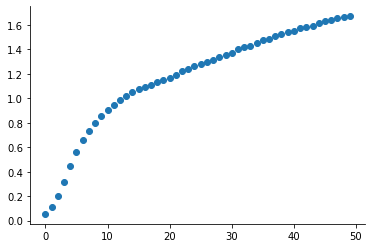

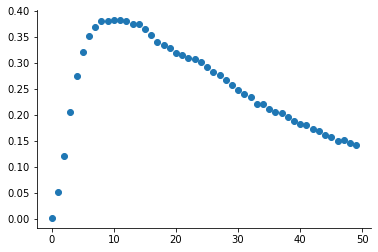

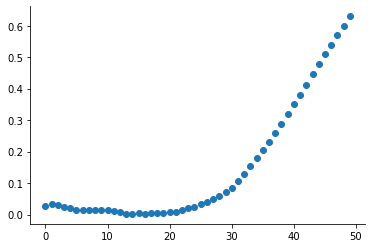

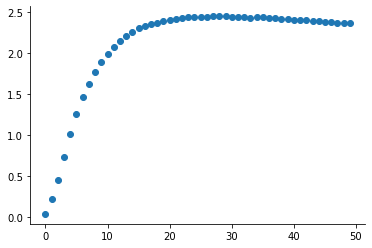

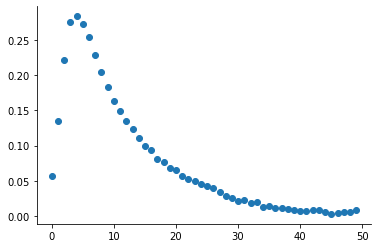

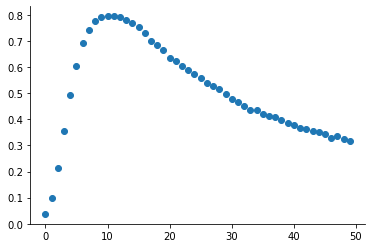

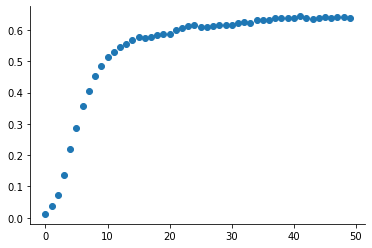

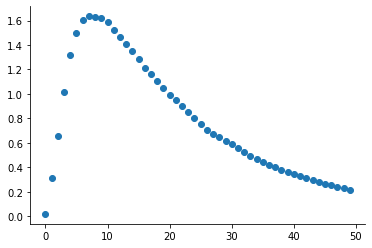

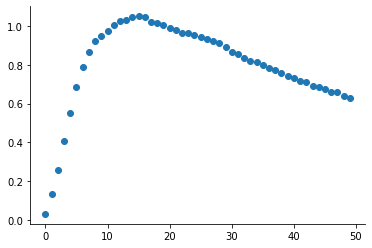

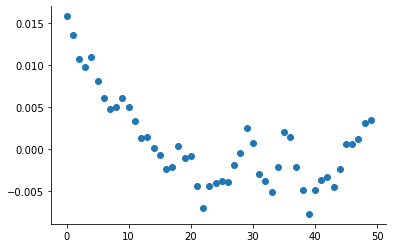

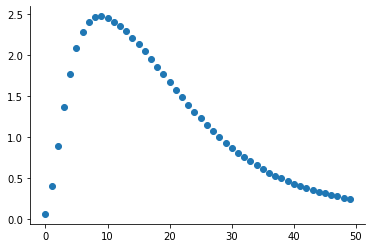

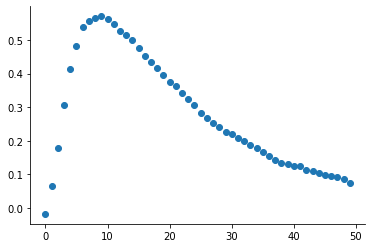

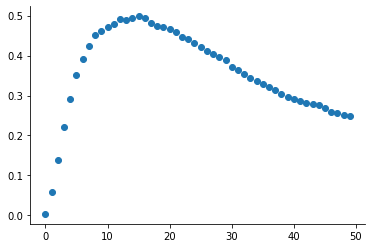

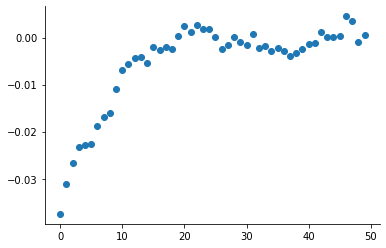

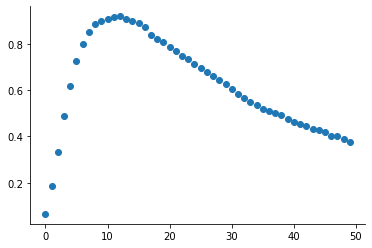

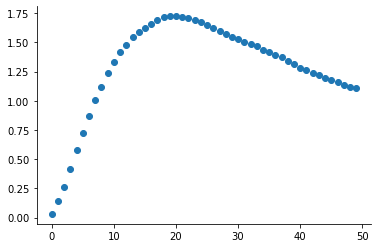

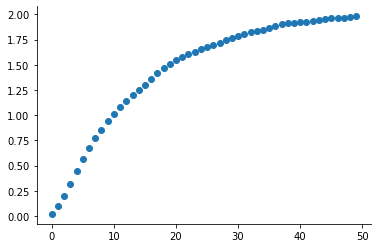

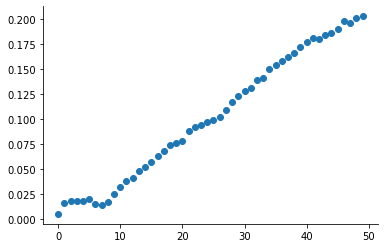

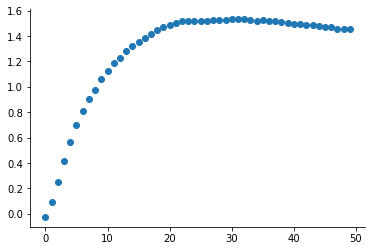

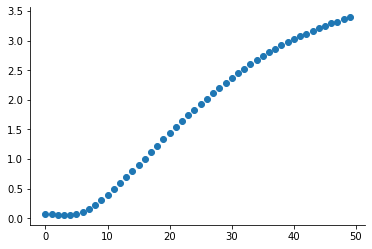

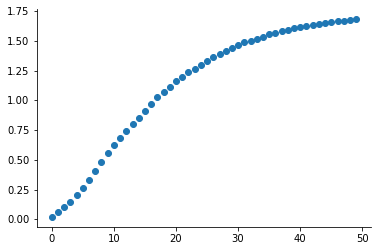

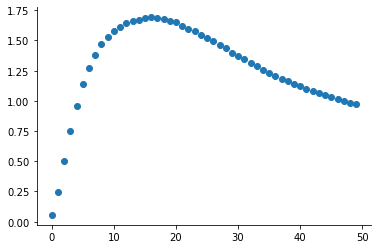

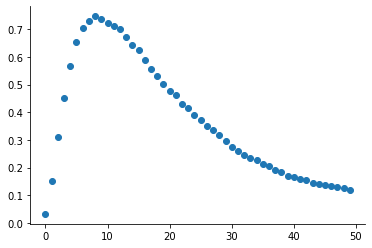

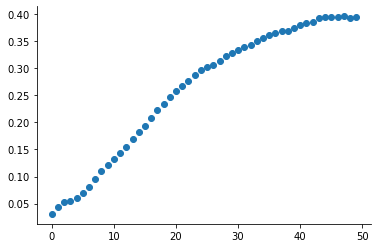

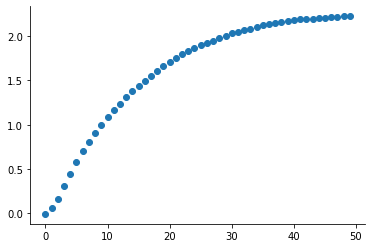

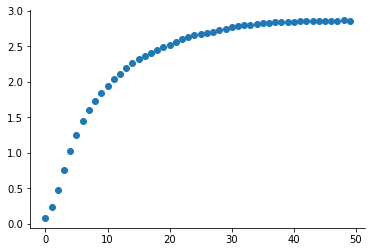

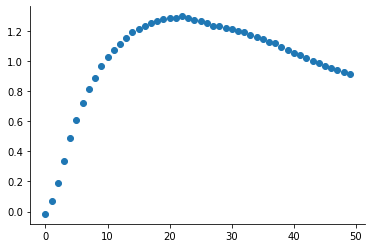

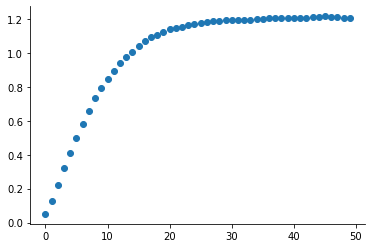

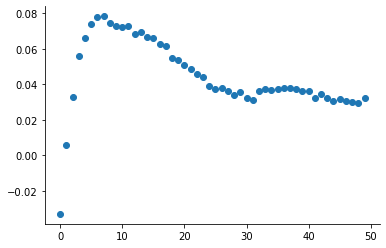

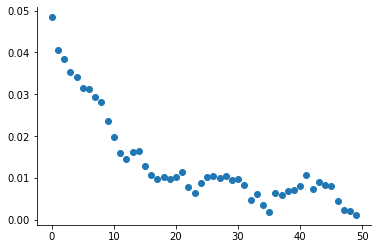

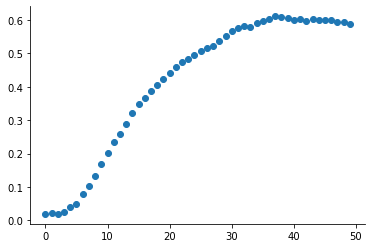

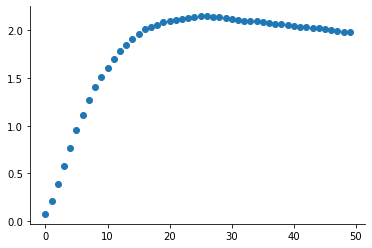

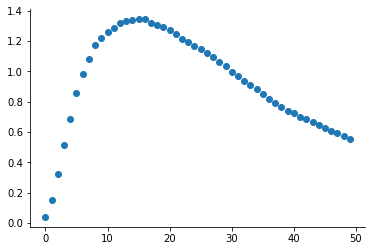

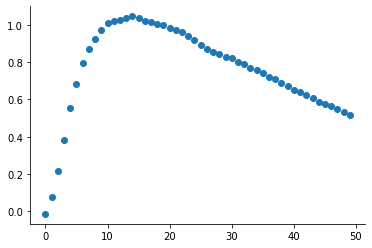

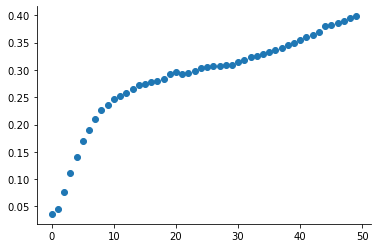

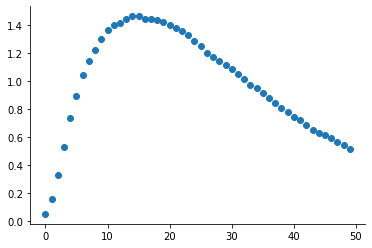

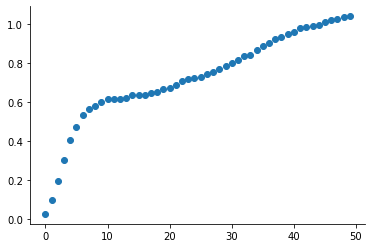

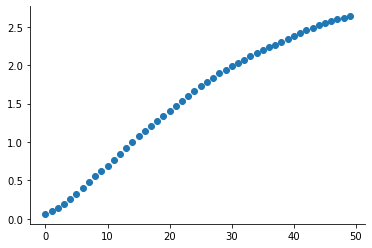

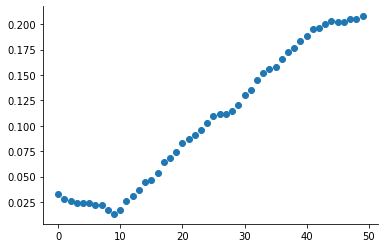

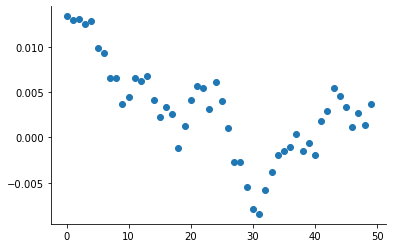

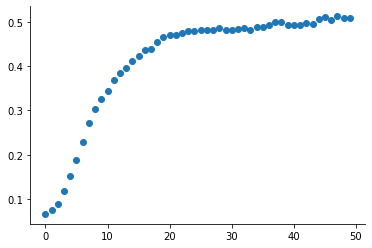

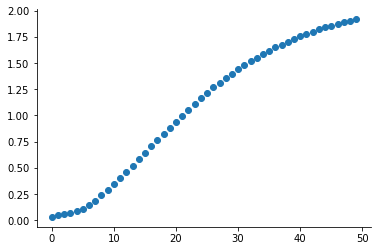

In [80]:
for i in range(50):
    plt.scatter(
        range(50),
        reservoir_average[:, i],
    )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.show()

0


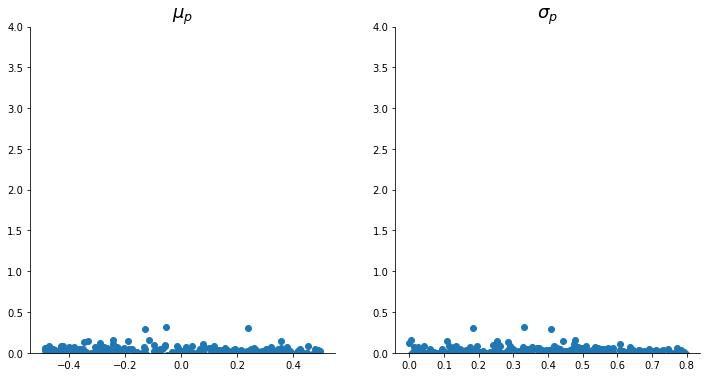

1


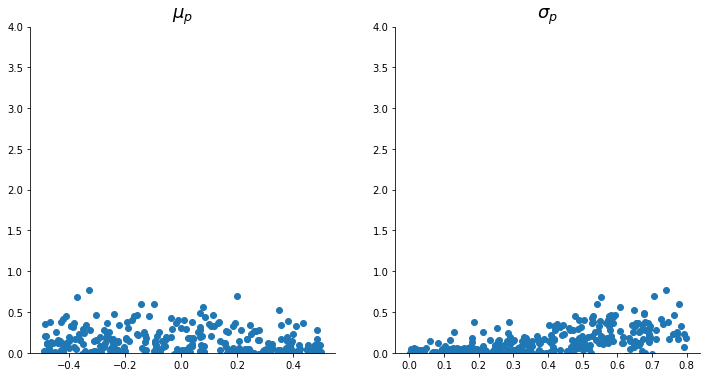

2


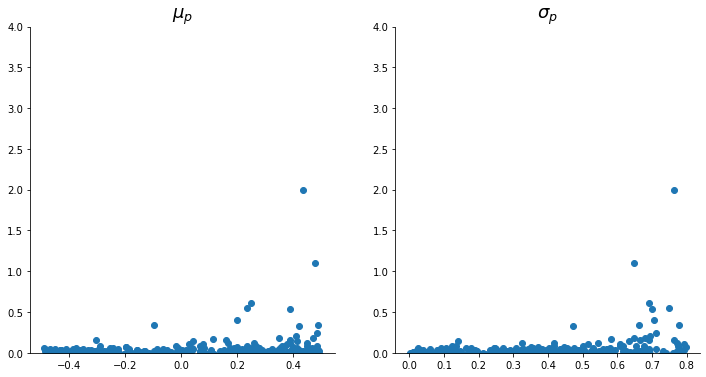

3


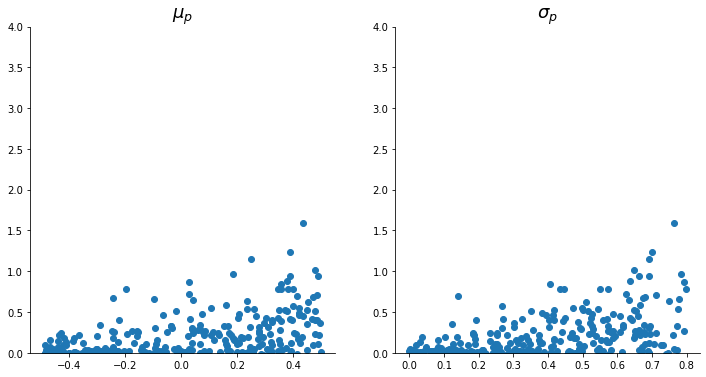

4


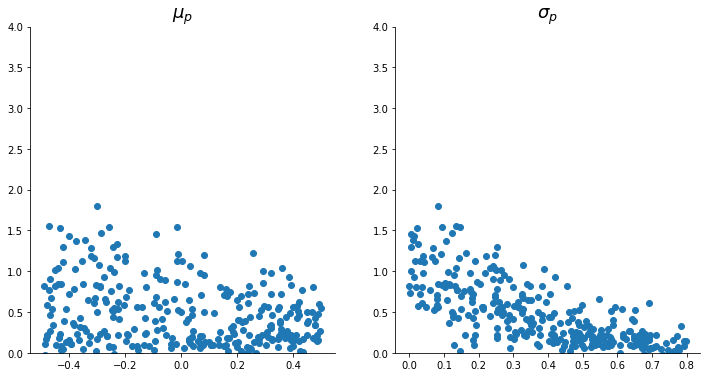

5


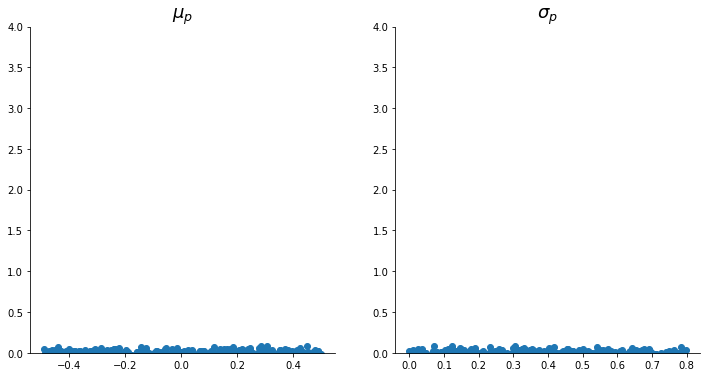

6


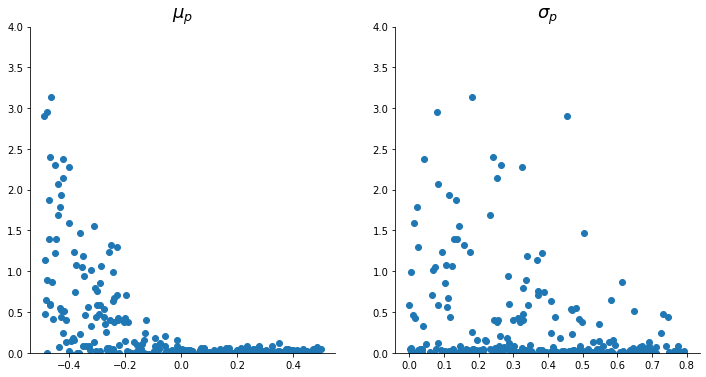

7


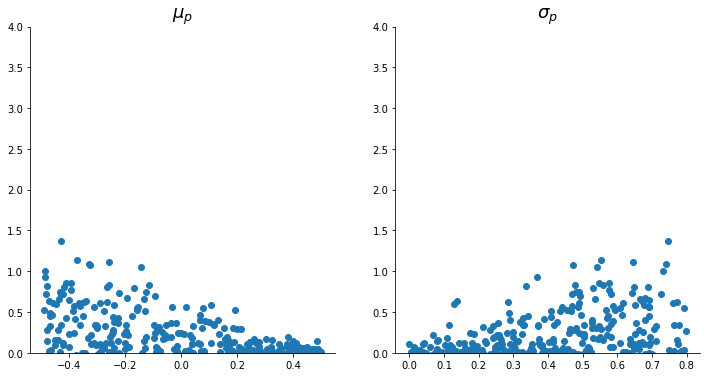

8


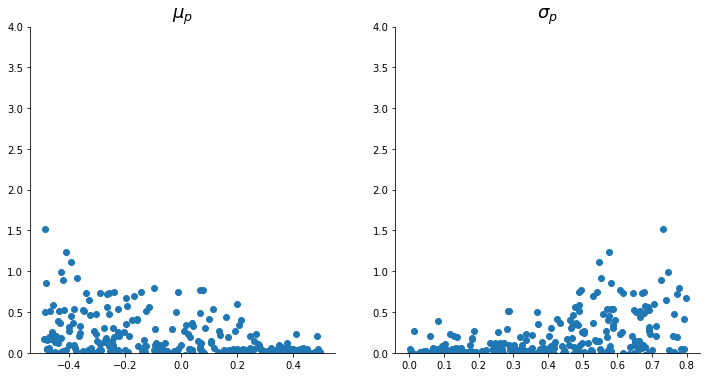

9


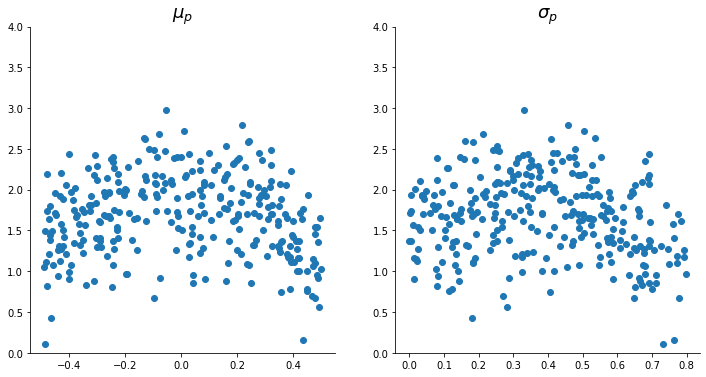

10


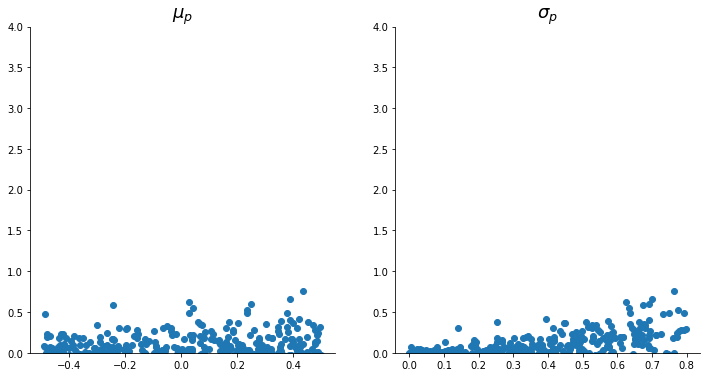

11


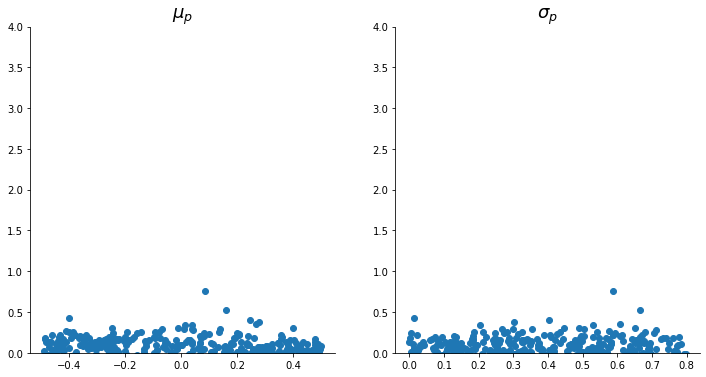

12


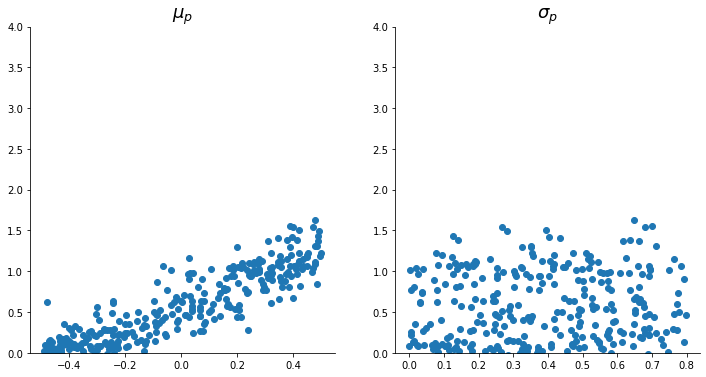

13


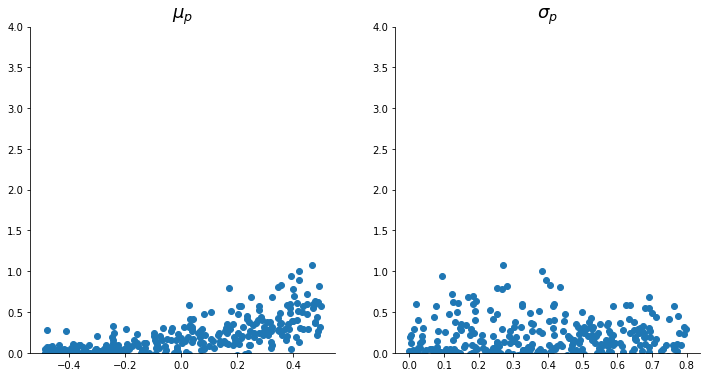

14


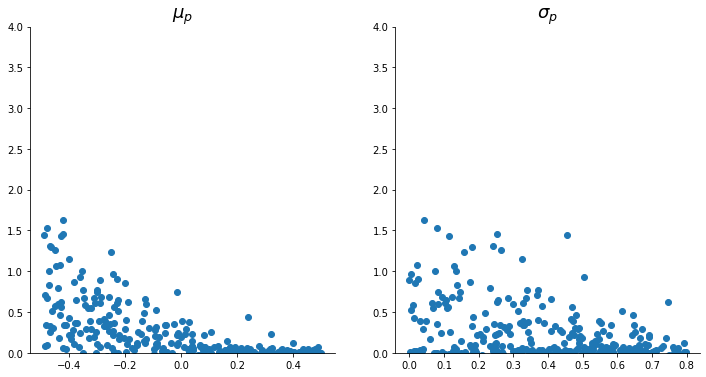

15


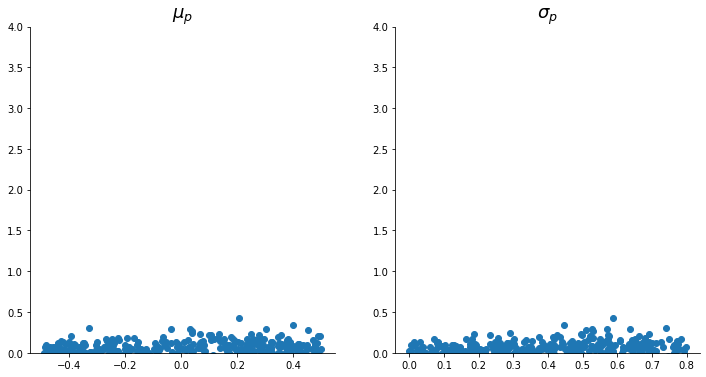

16


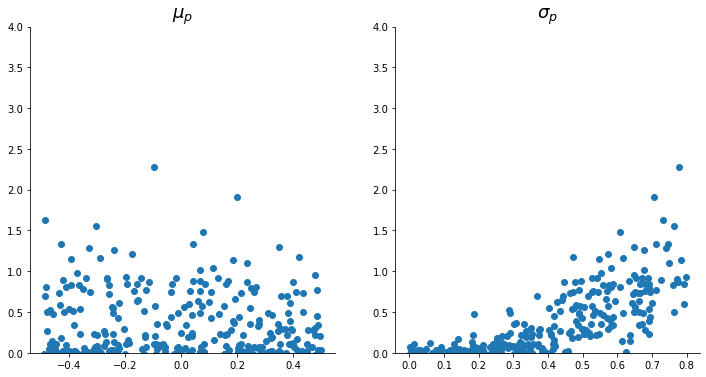

17


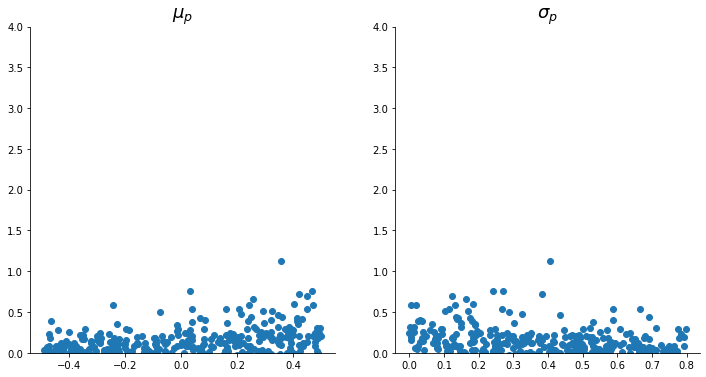

18


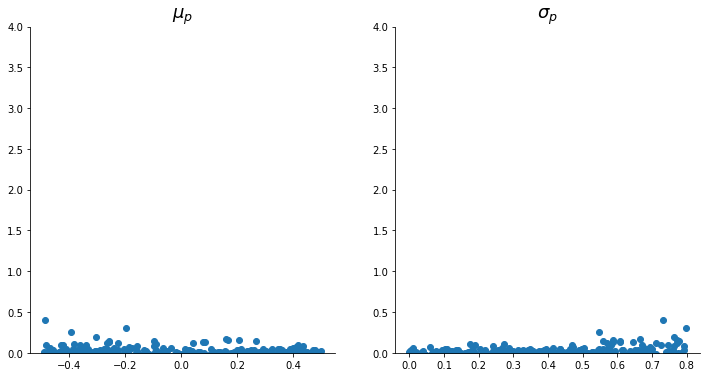

19


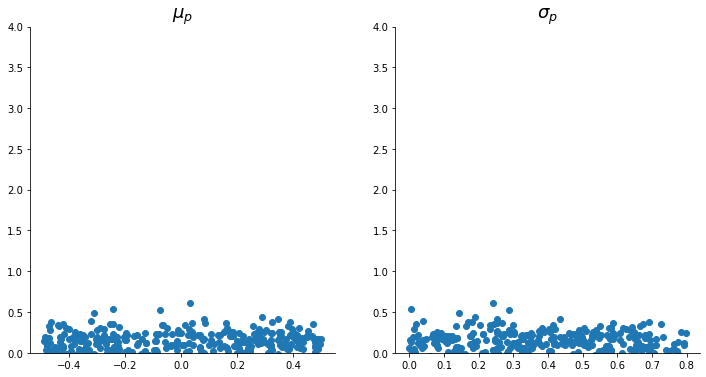

20


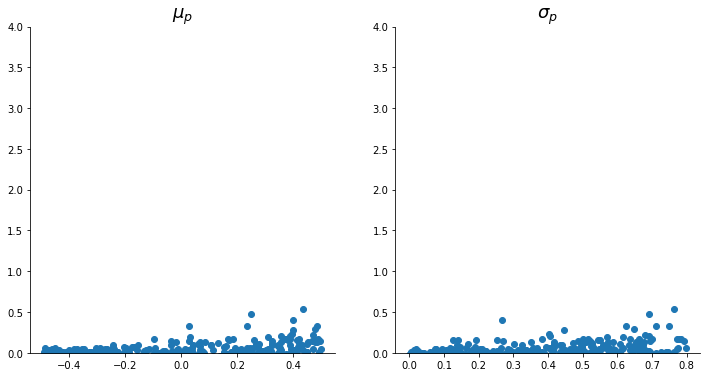

21


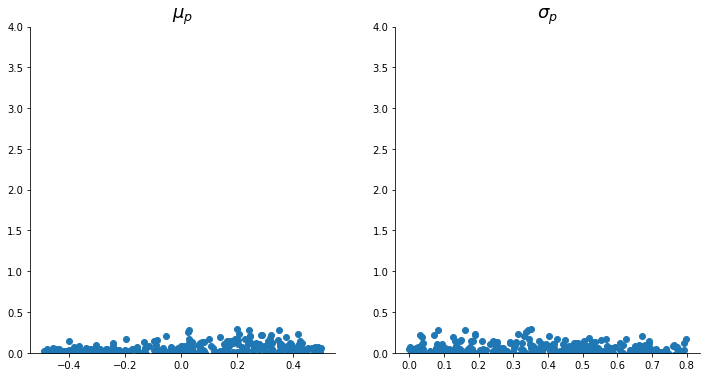

22


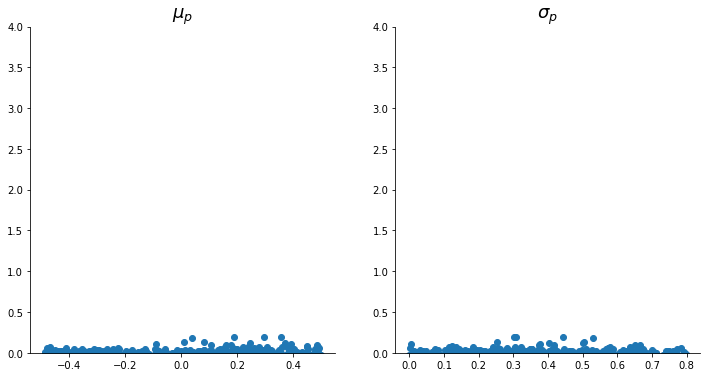

23


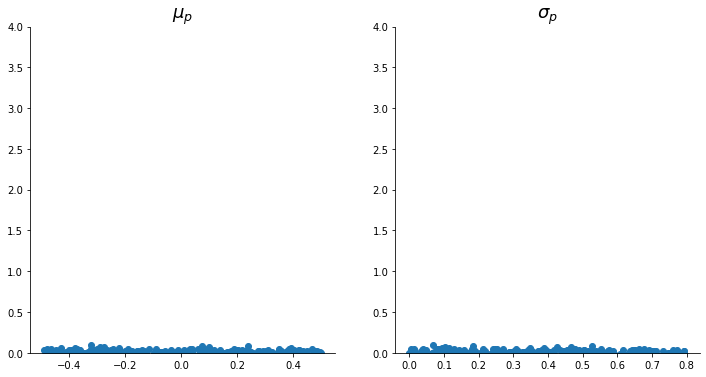

24


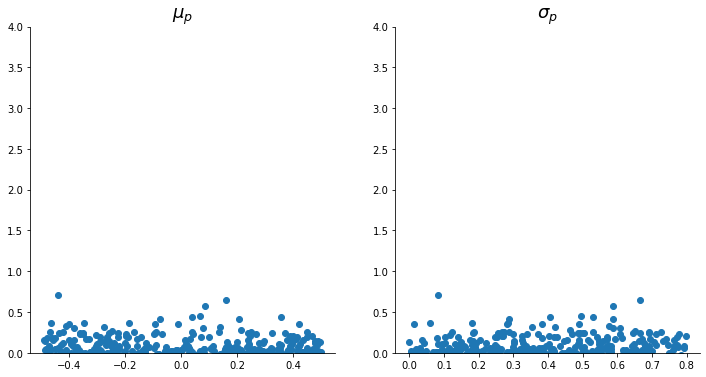

25


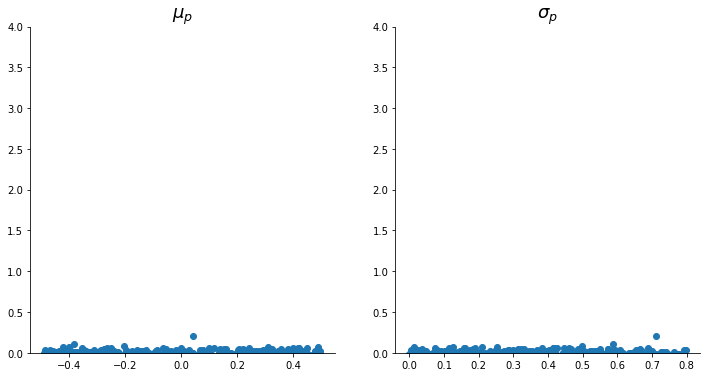

26


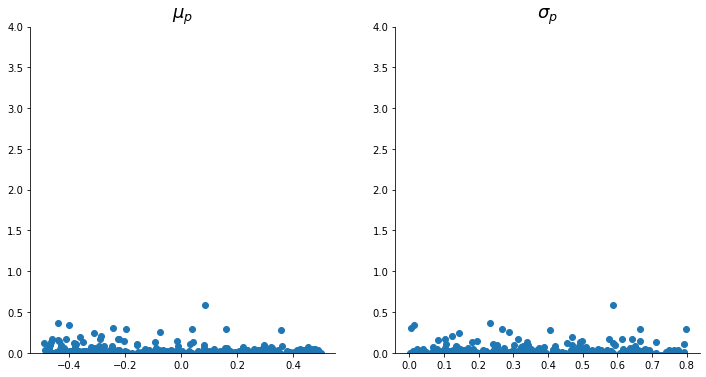

27


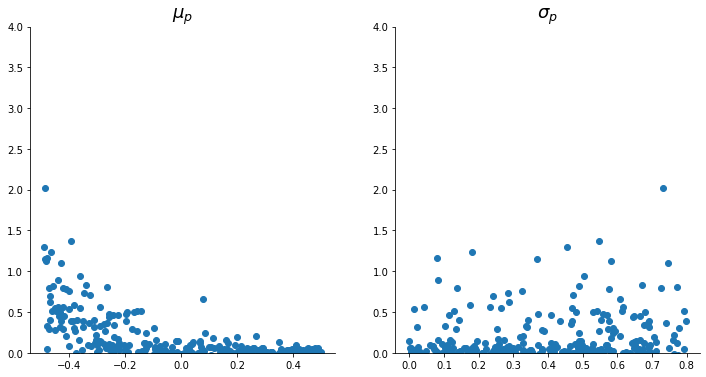

28


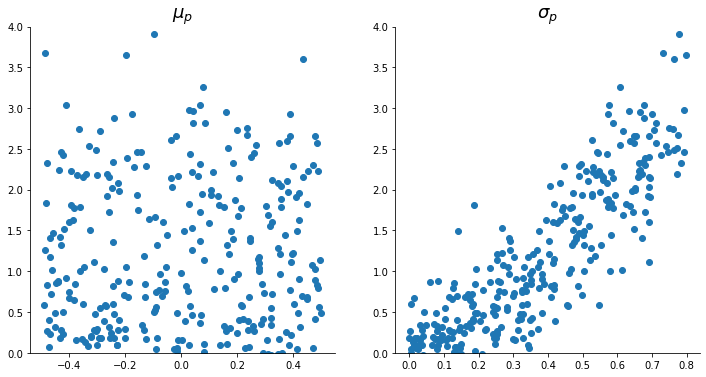

29


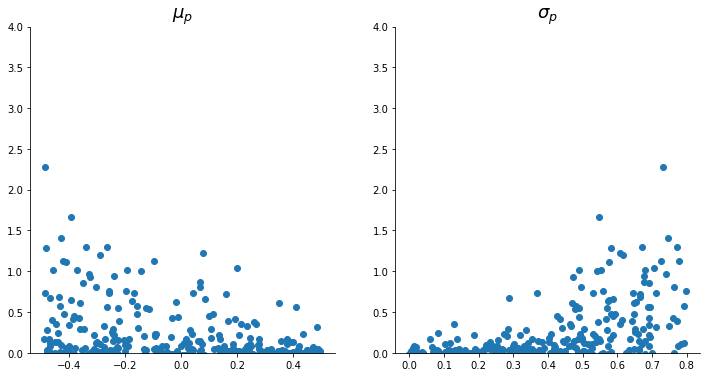

30


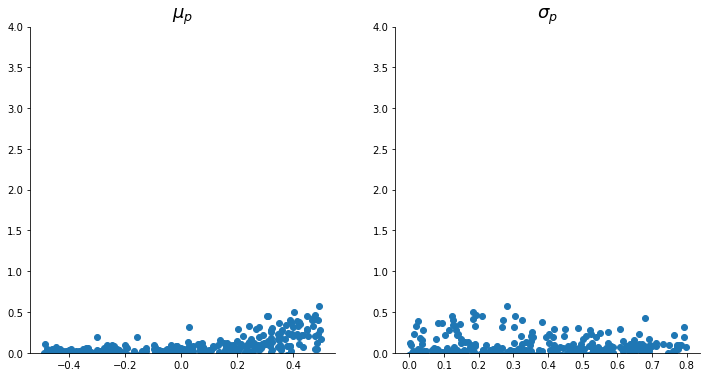

31


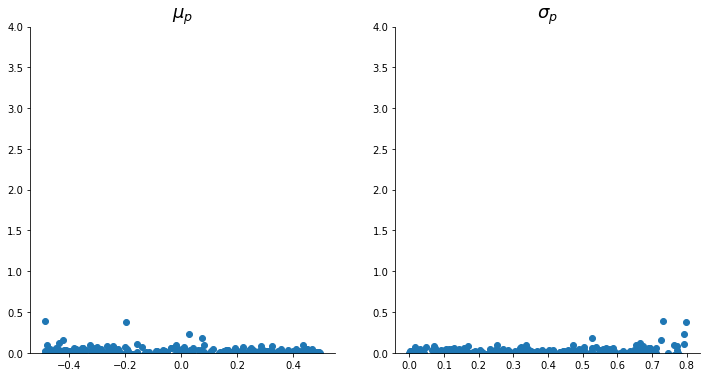

32


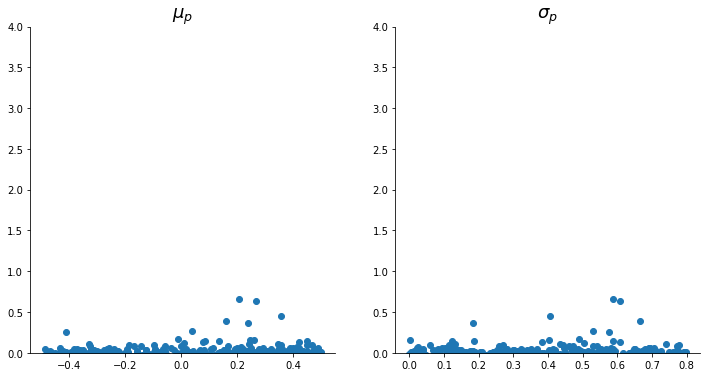

33


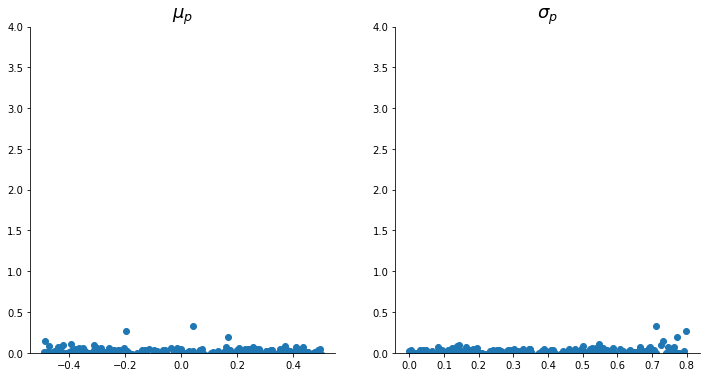

34


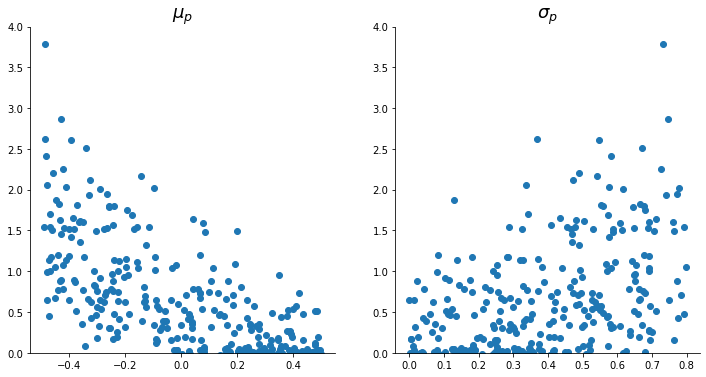

35


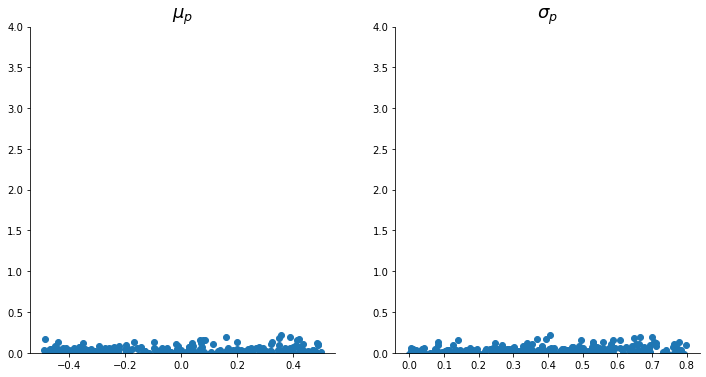

36


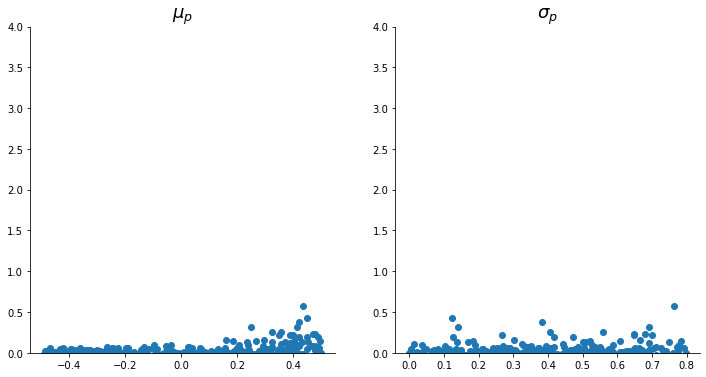

37


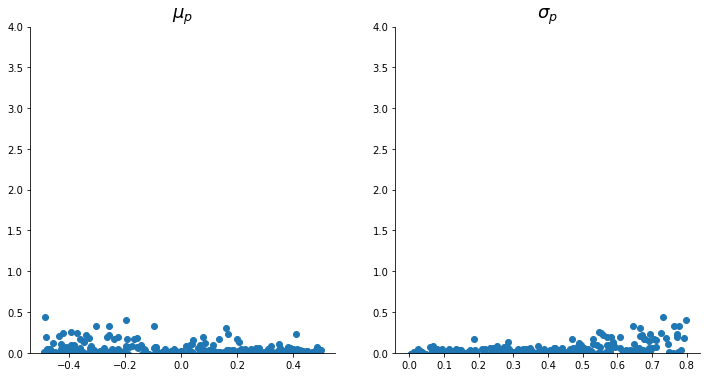

38


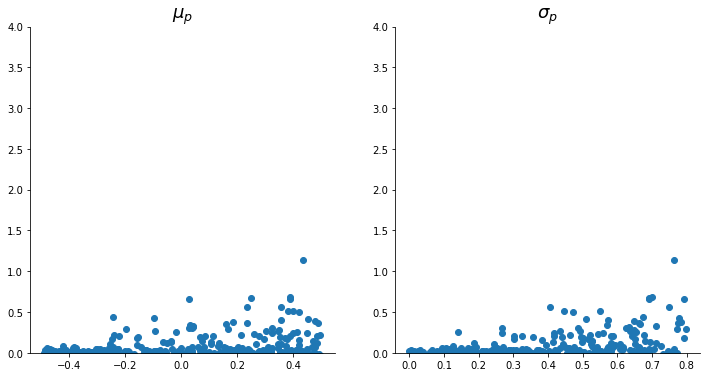

39


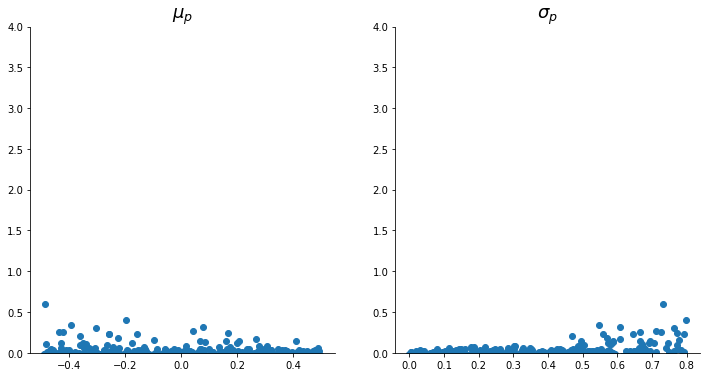

40


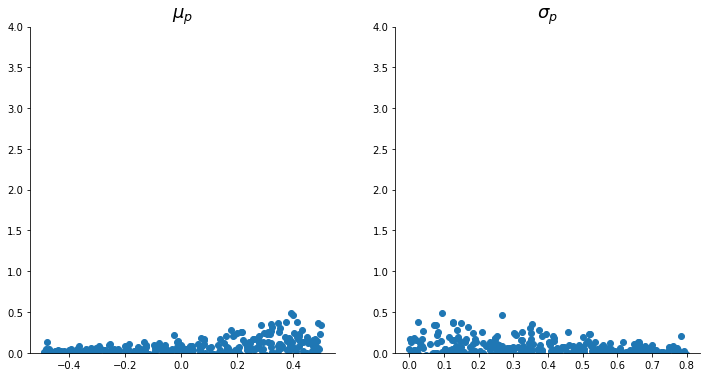

41


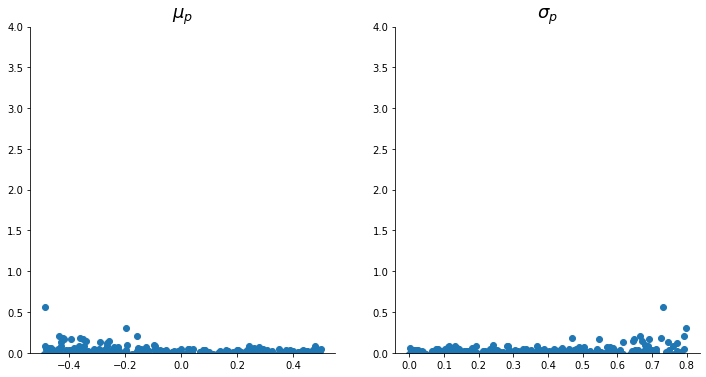

42


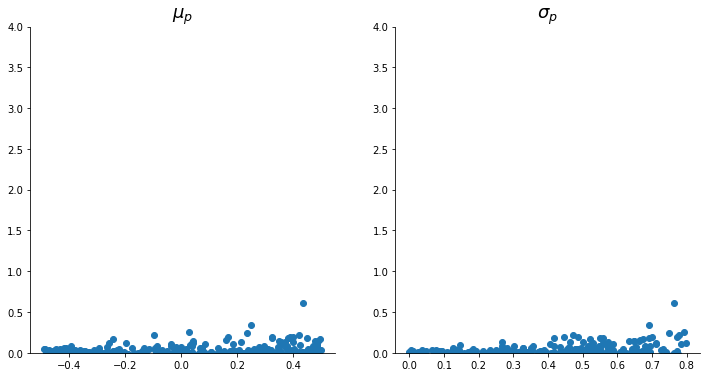

43


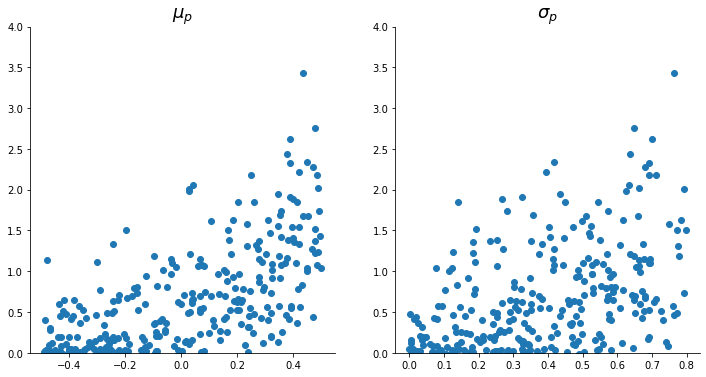

44


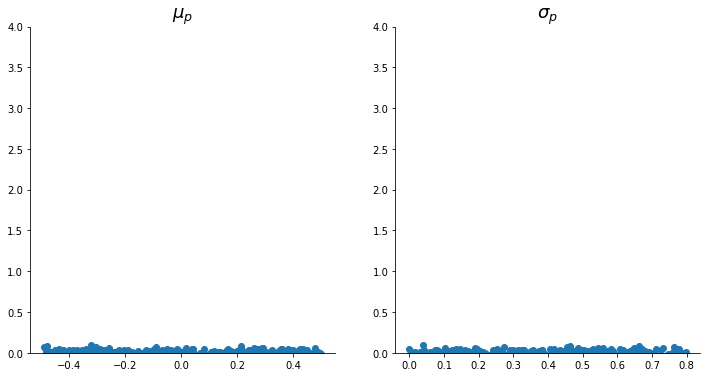

45


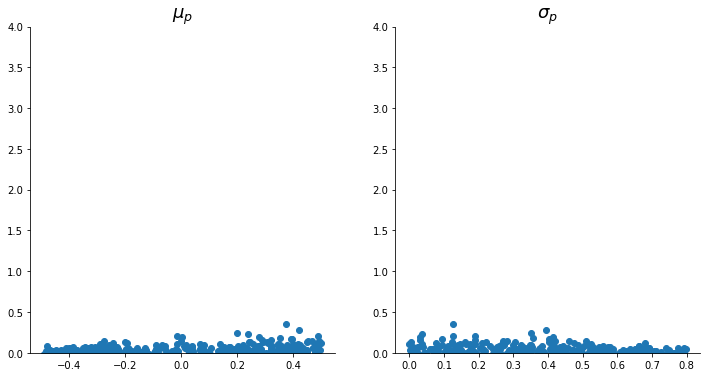

46


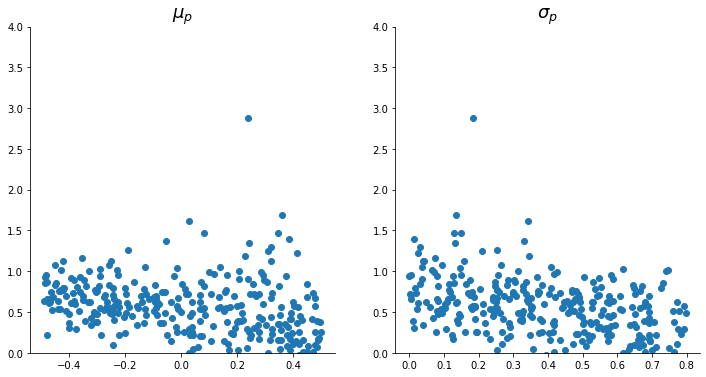

47


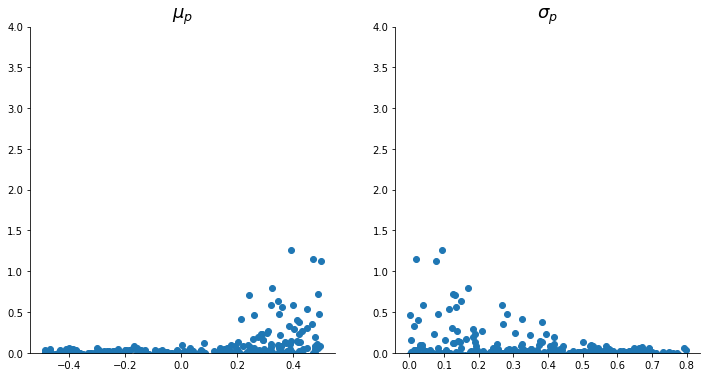

48


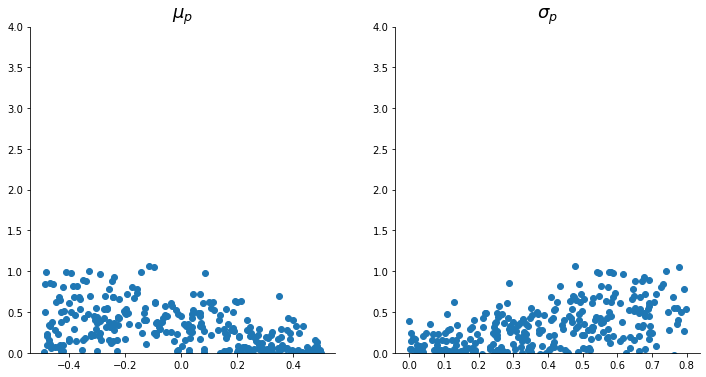

49


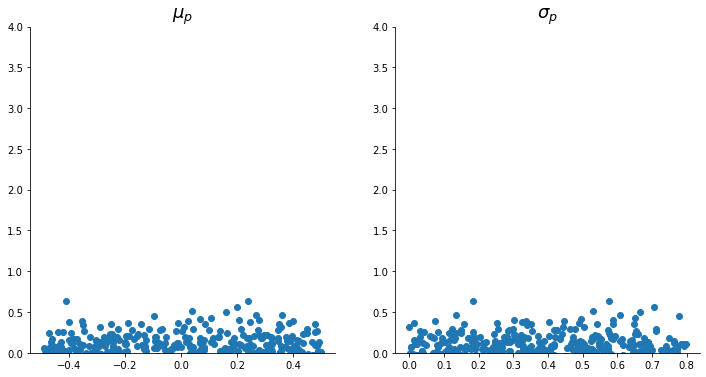

50


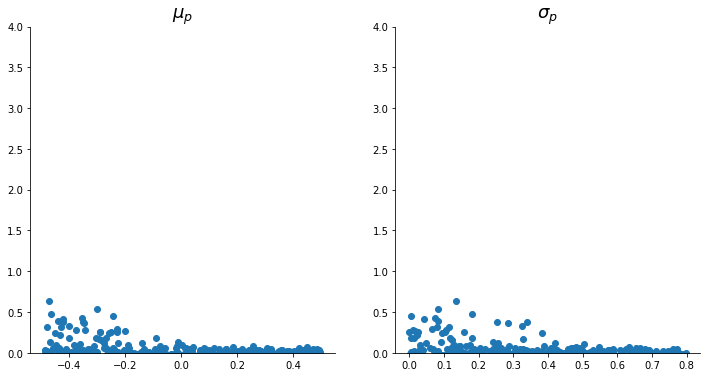

51


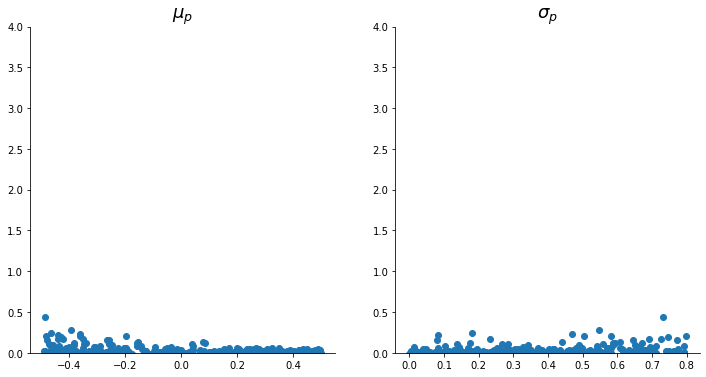

52


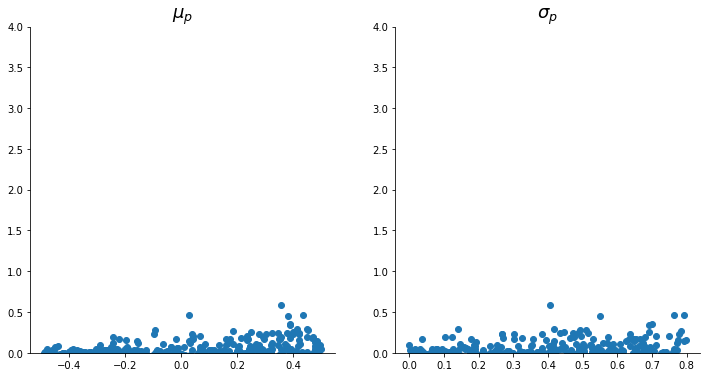

53


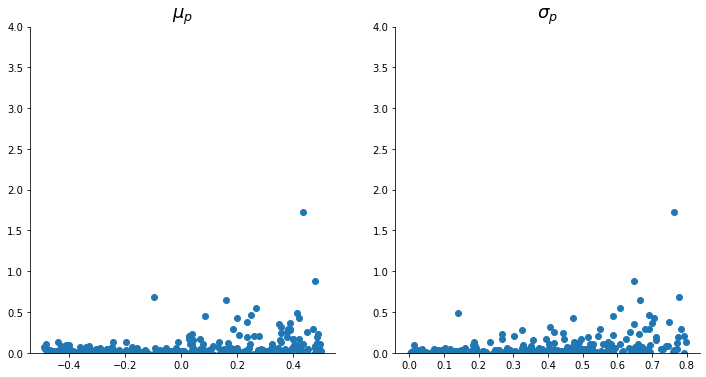

54


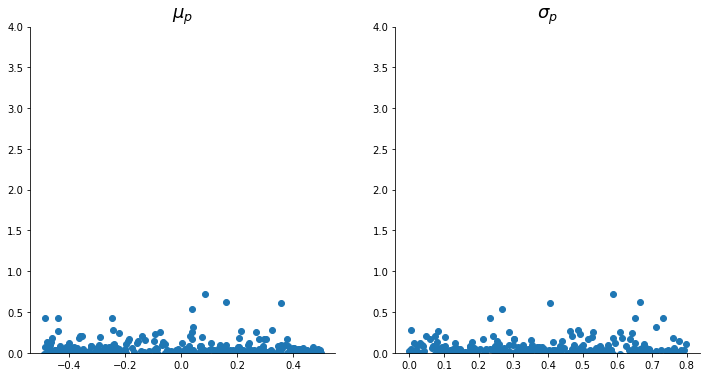

55


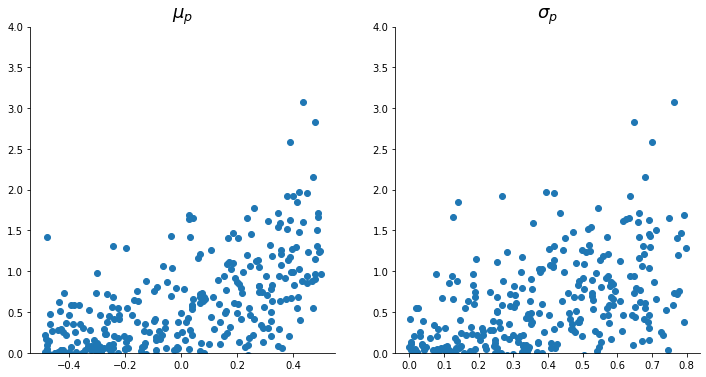

56


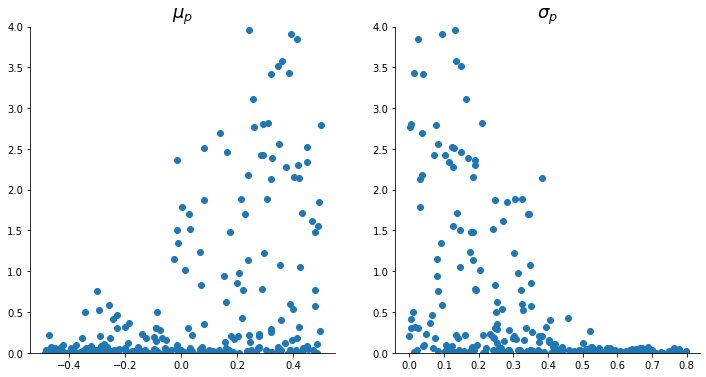

57


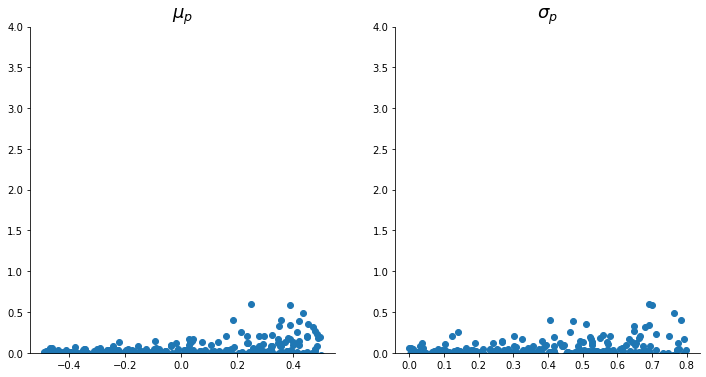

58


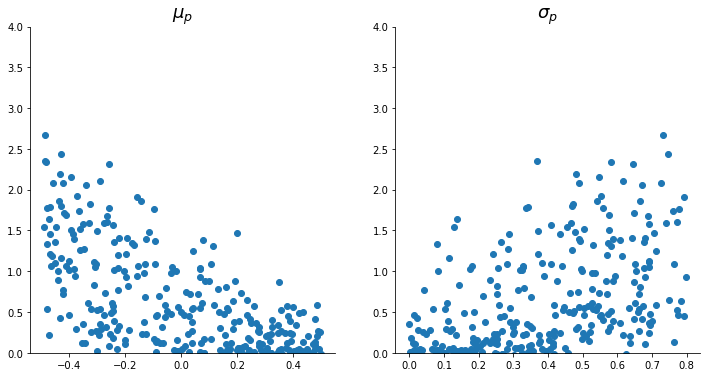

59


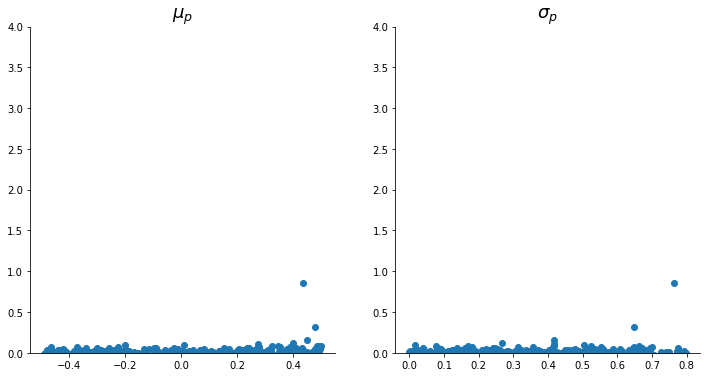

60


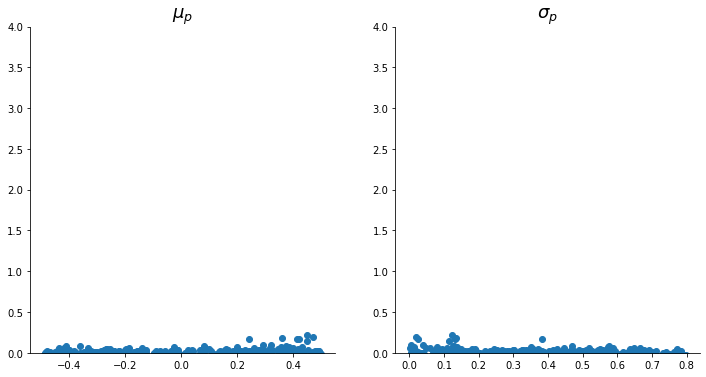

61


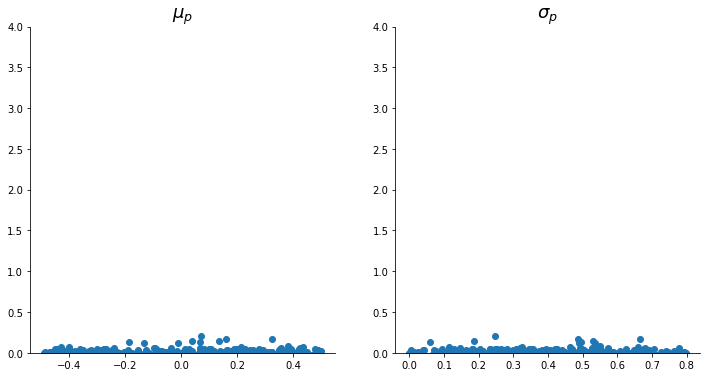

62


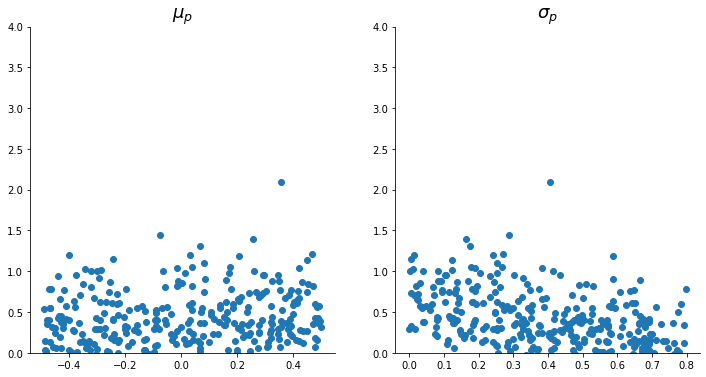

63


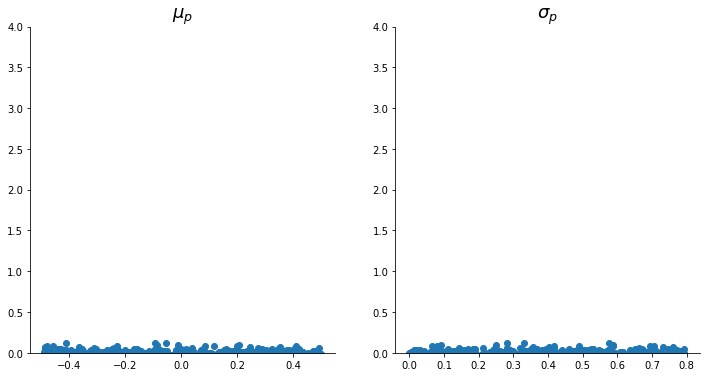

64


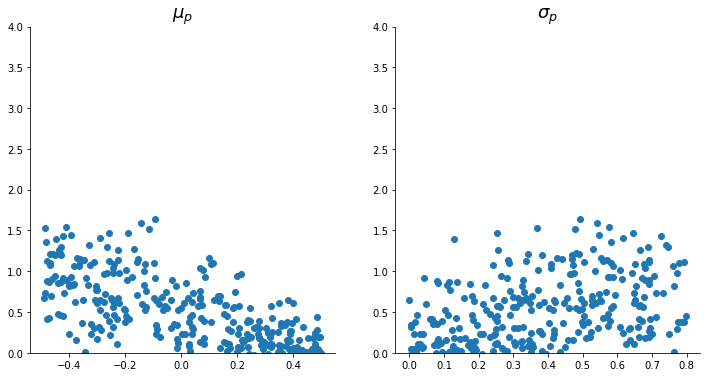

65


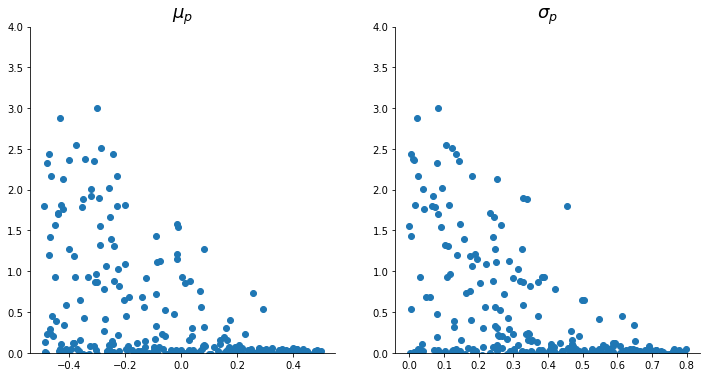

66


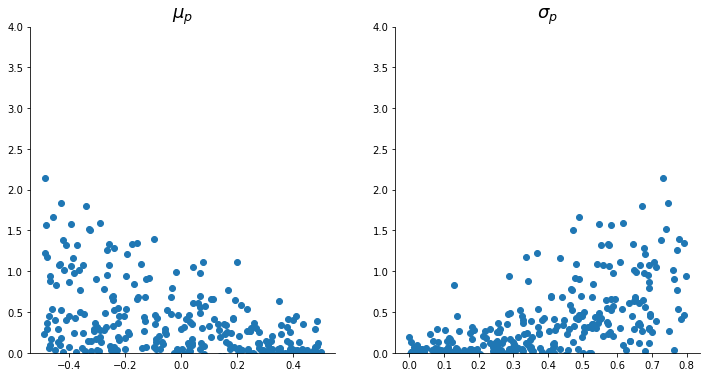

67


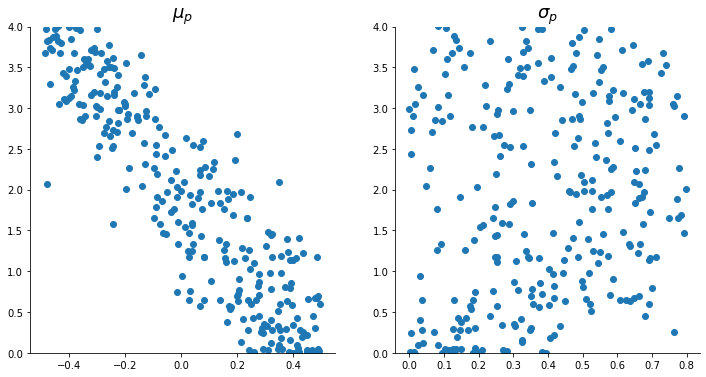

68


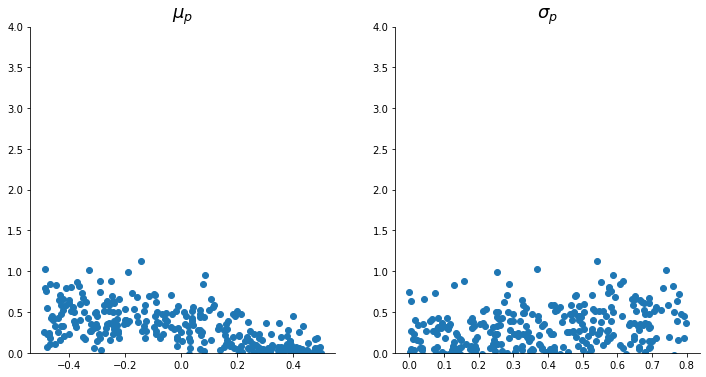

69


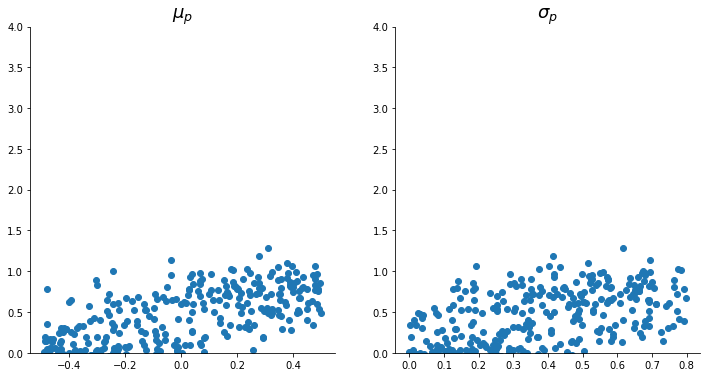

70


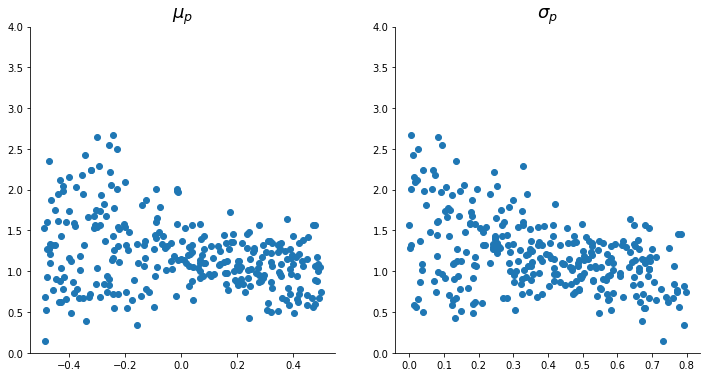

71


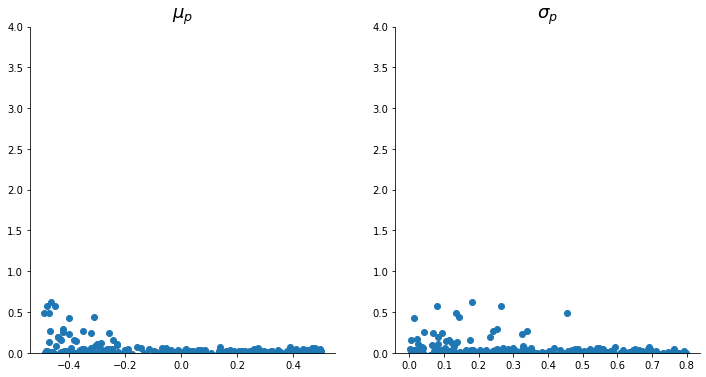

72


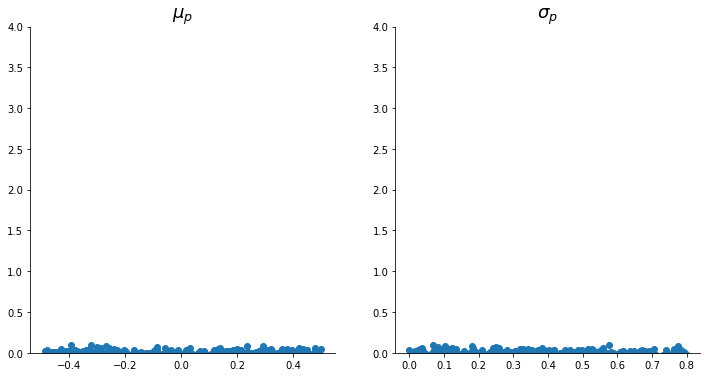

73


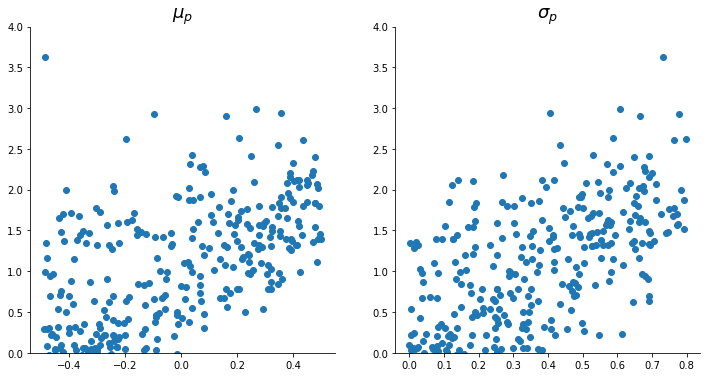

74


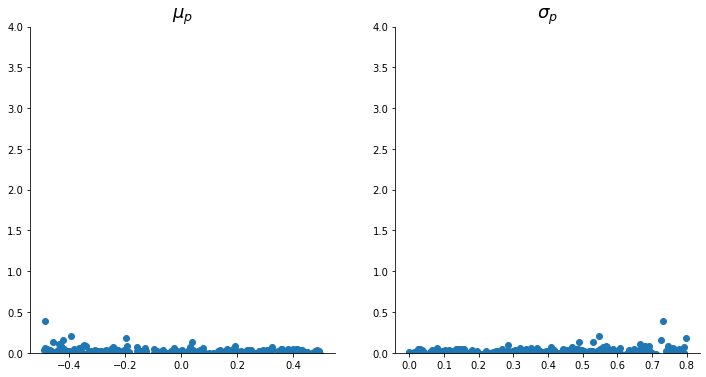

75


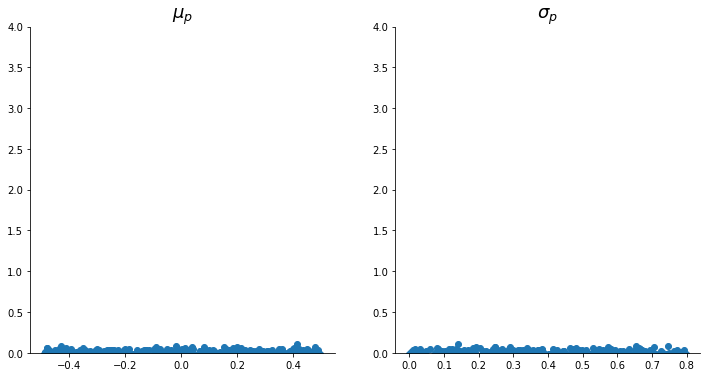

76


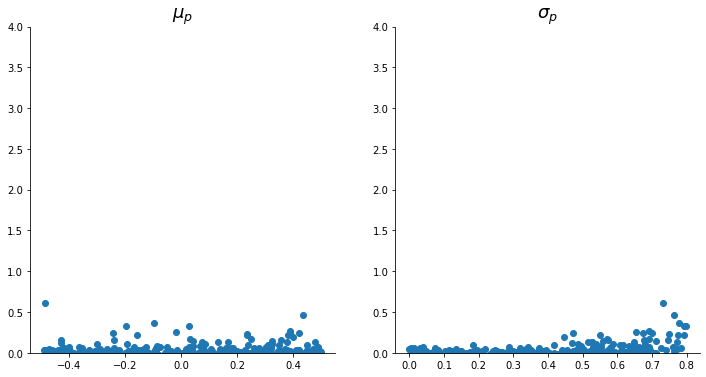

77


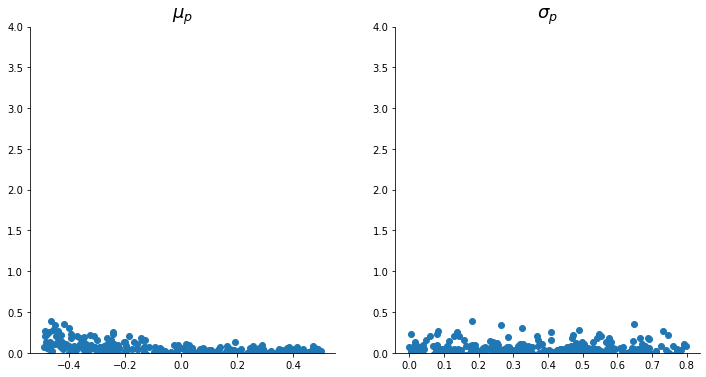

78


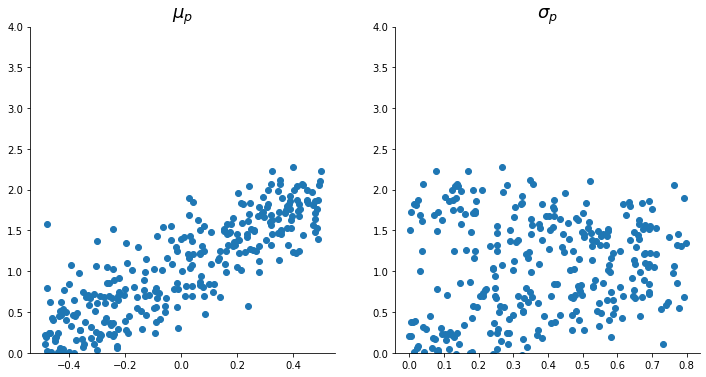

79


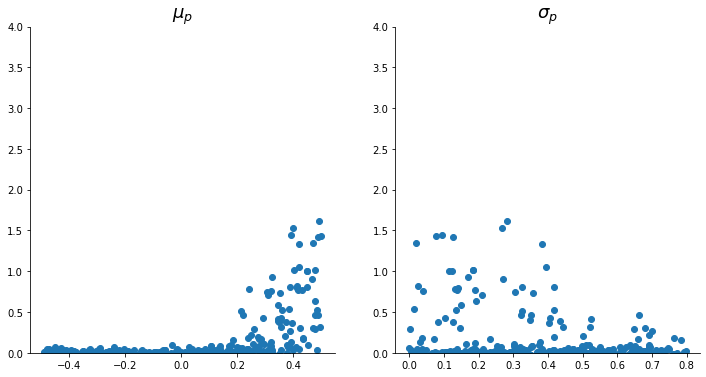

80


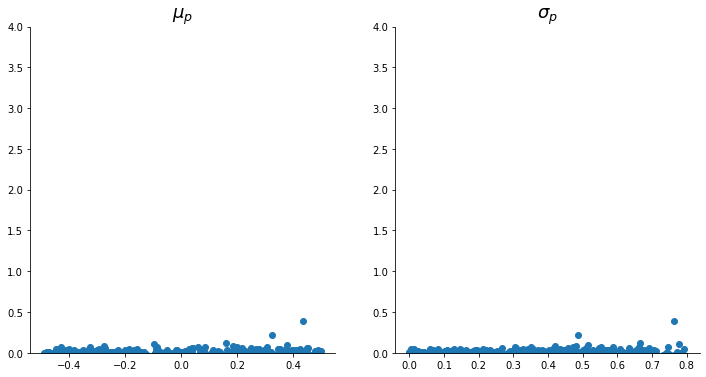

81


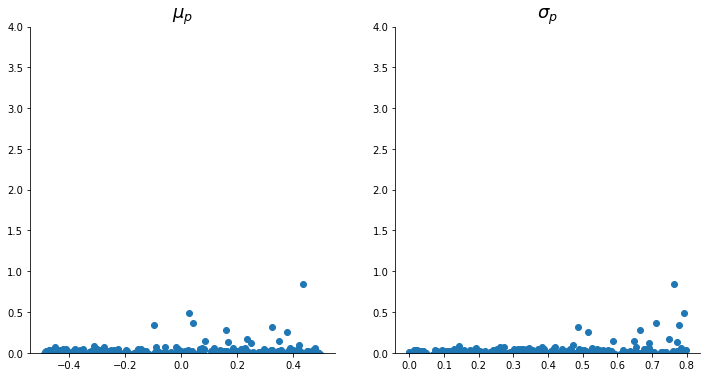

82


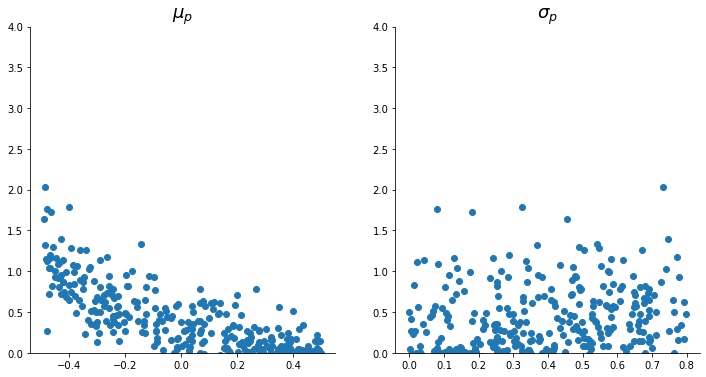

83


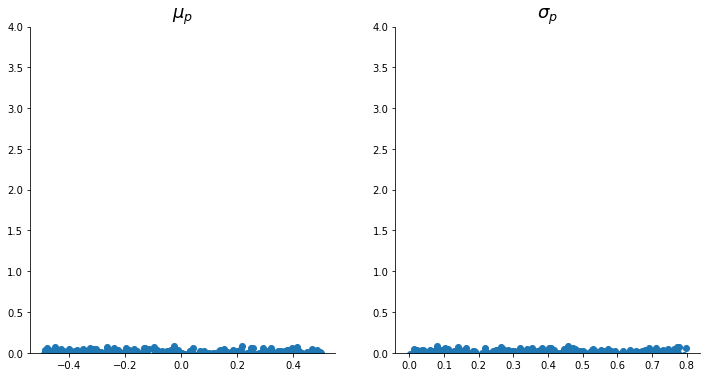

84


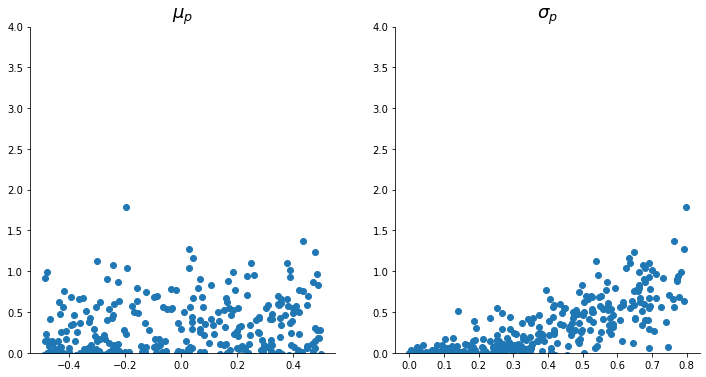

85


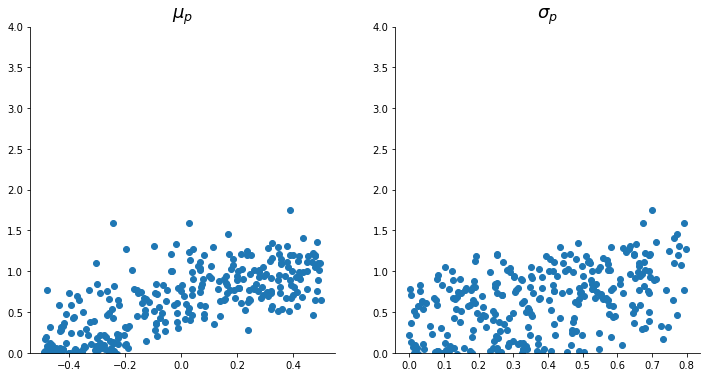

86


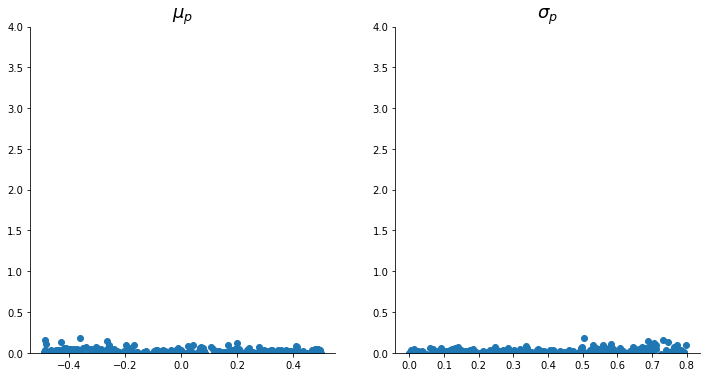

87


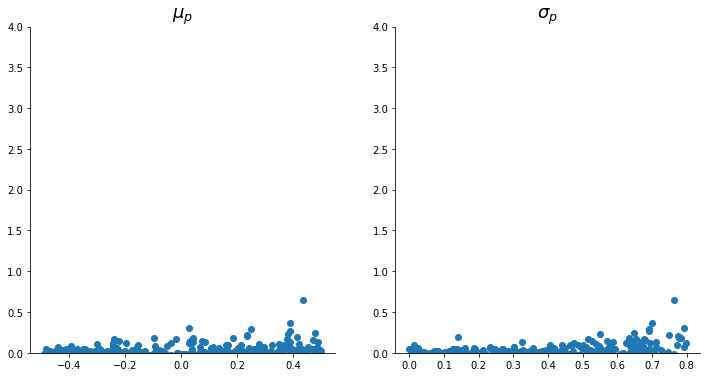

88


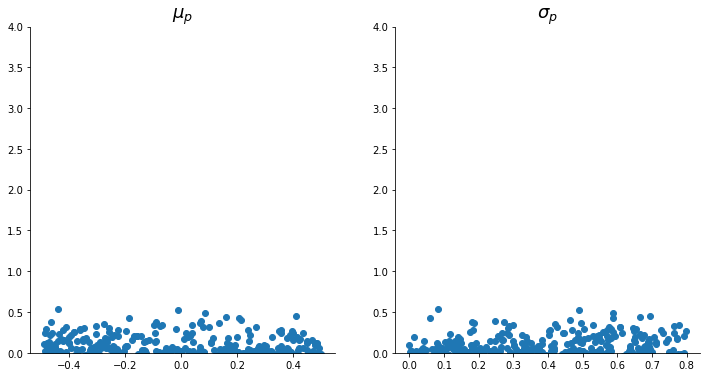

89


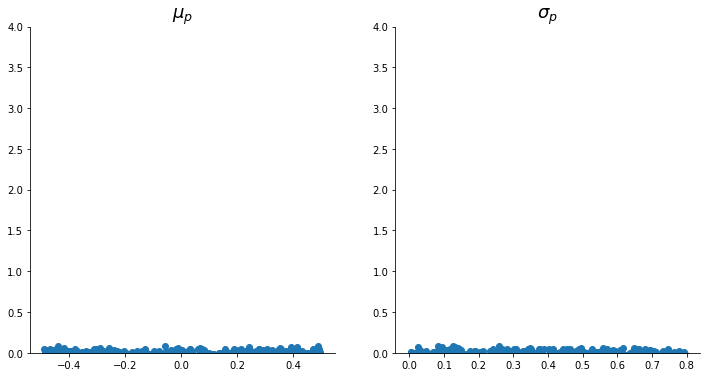

90


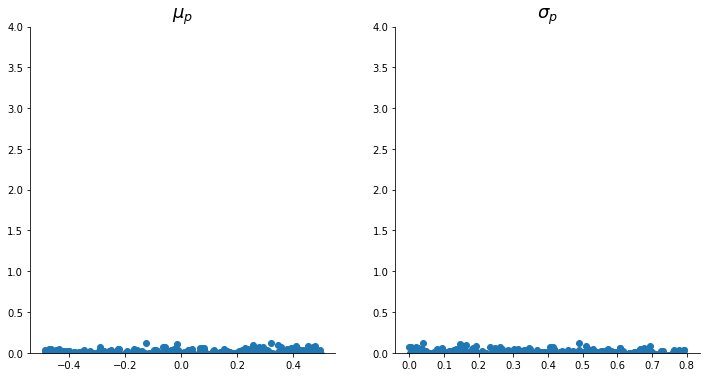

91


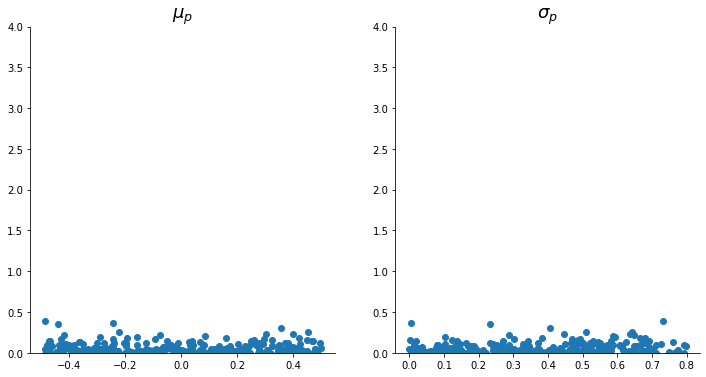

92


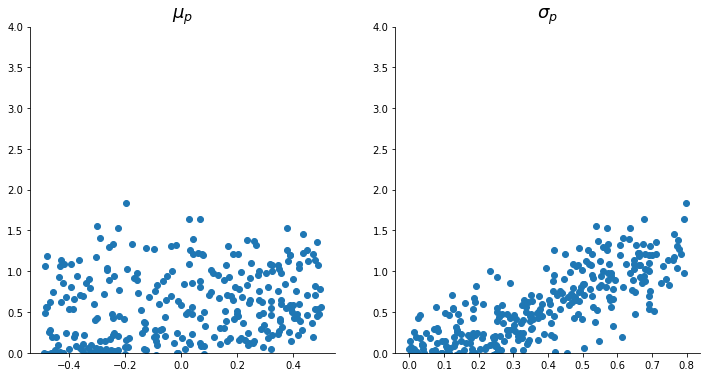

93


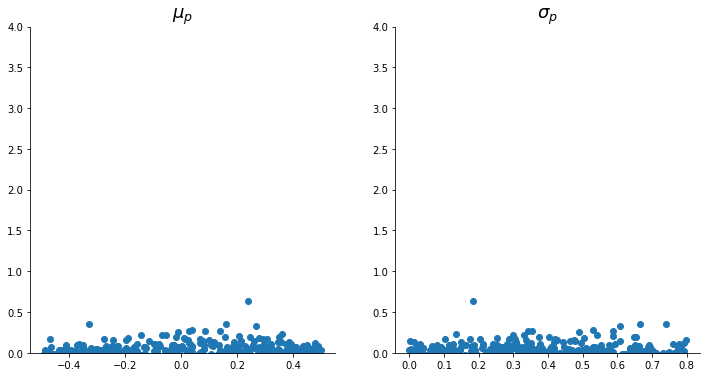

94


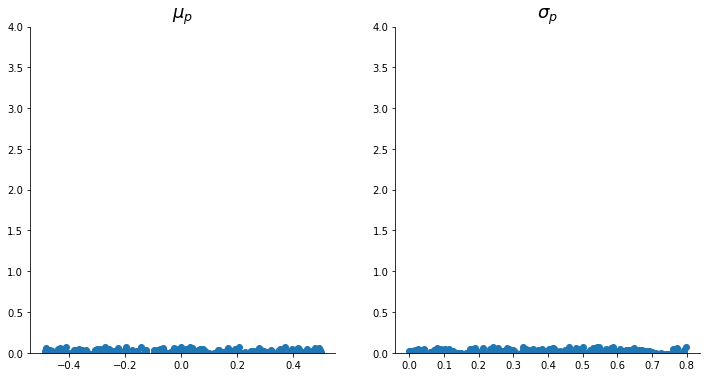

95


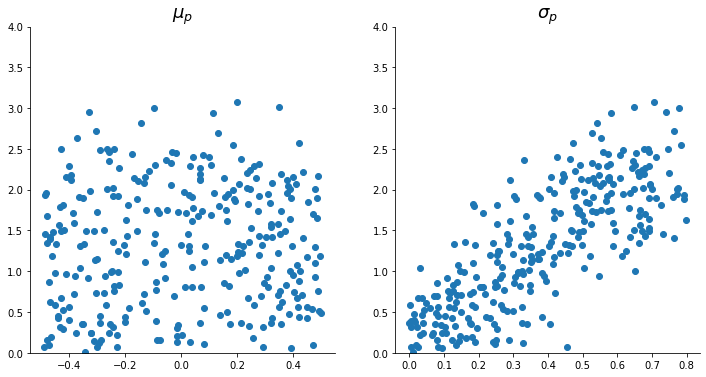

96


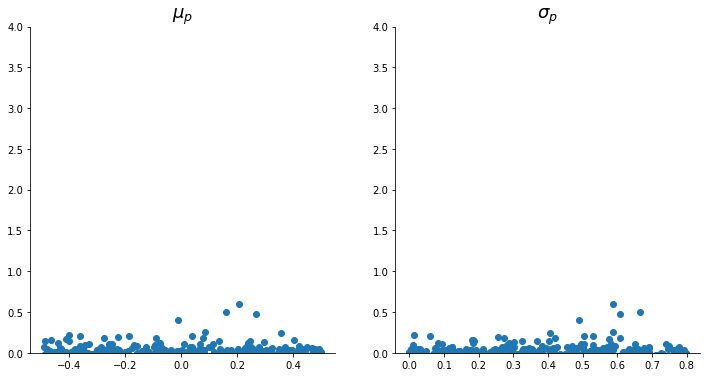

97


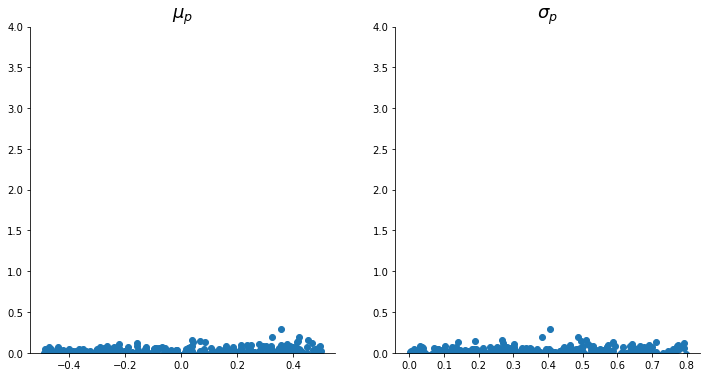

98


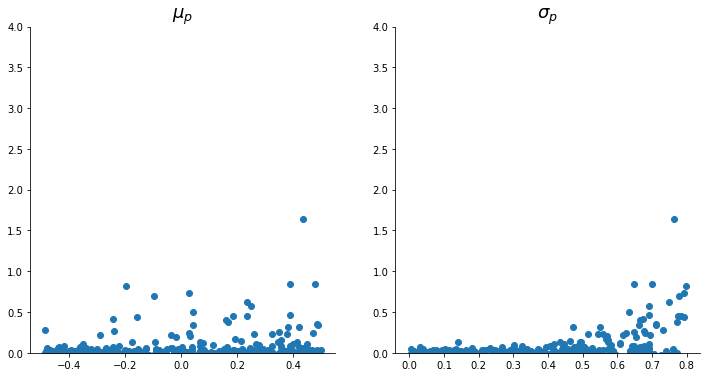

99


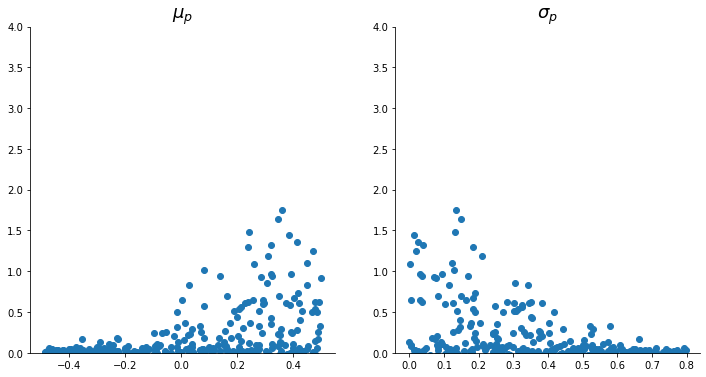

100


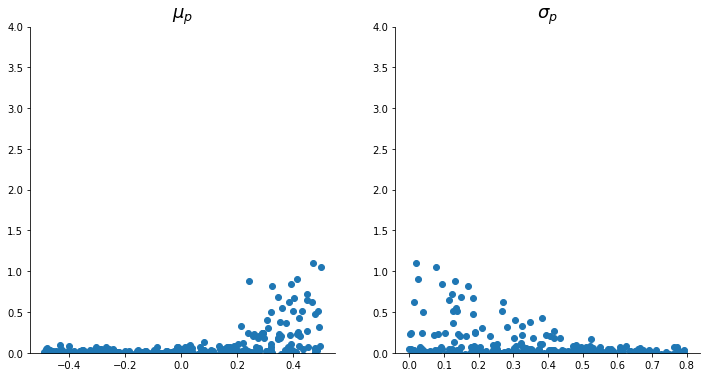

101


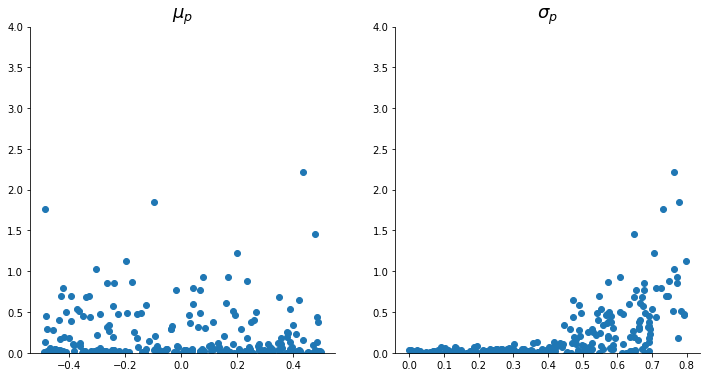

102


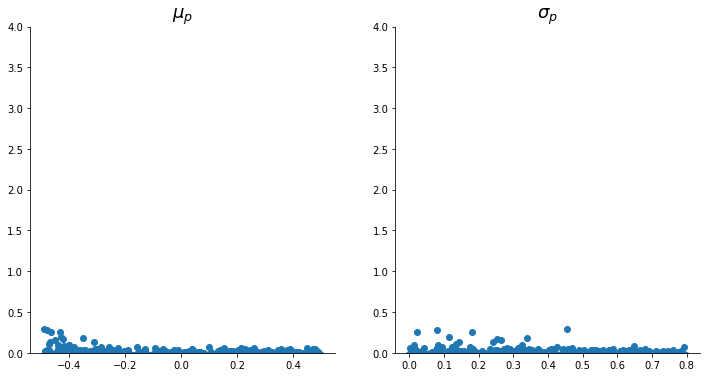

103


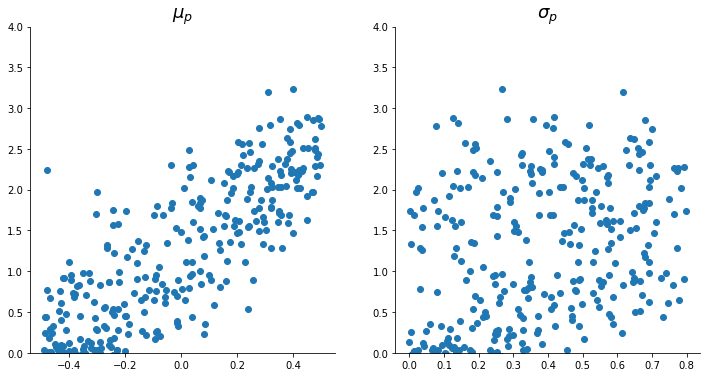

104


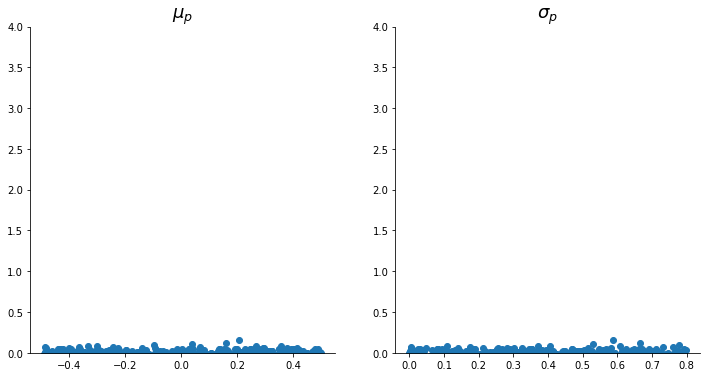

105


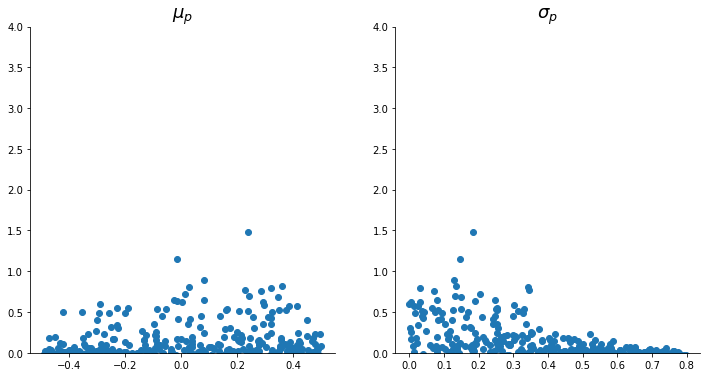

106


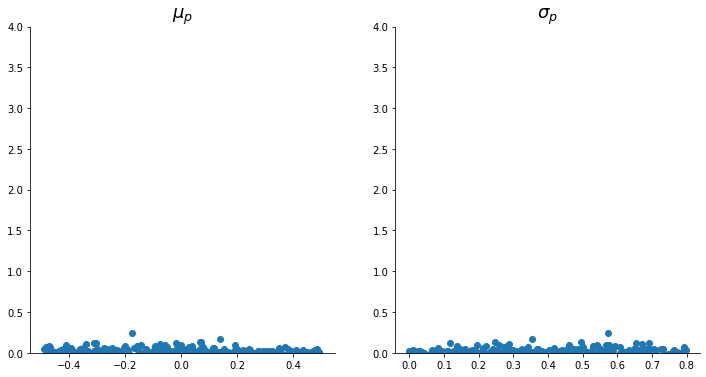

107


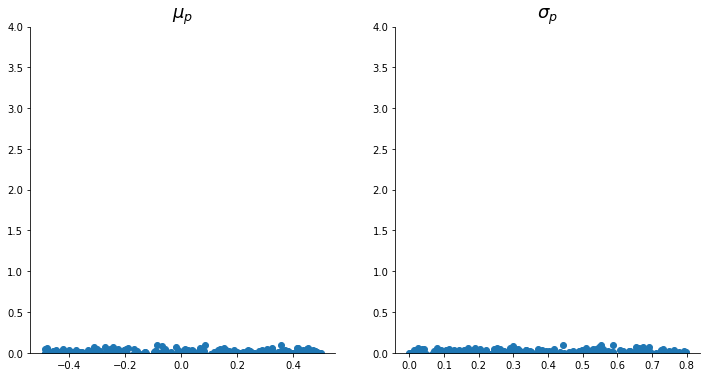

108


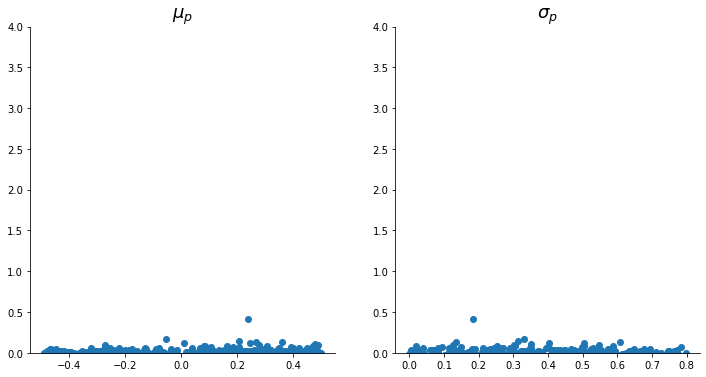

109


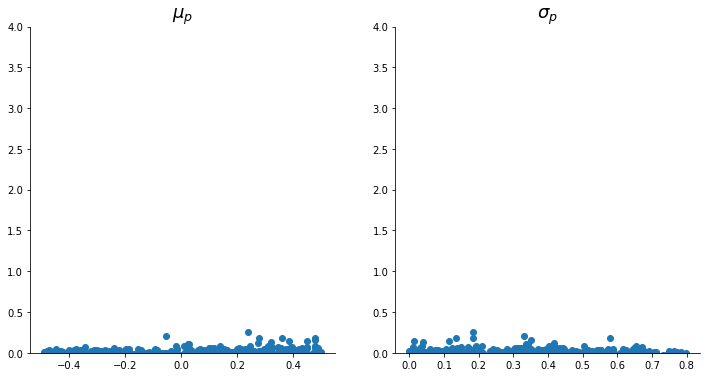

110


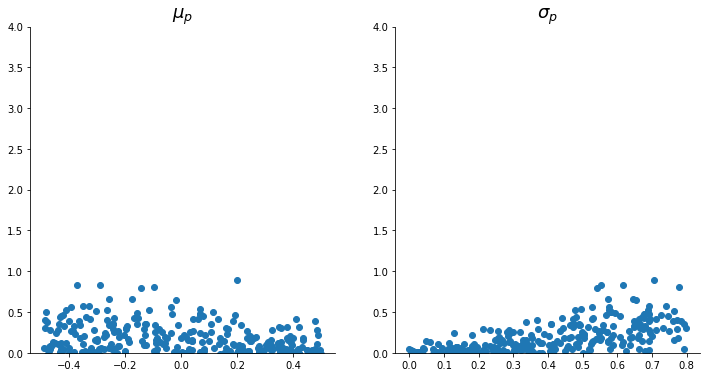

111


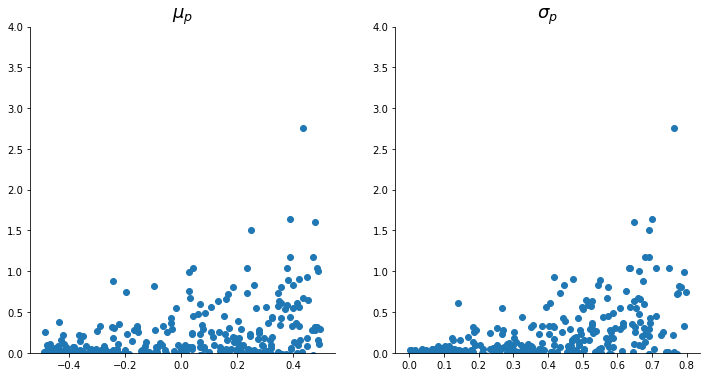

112


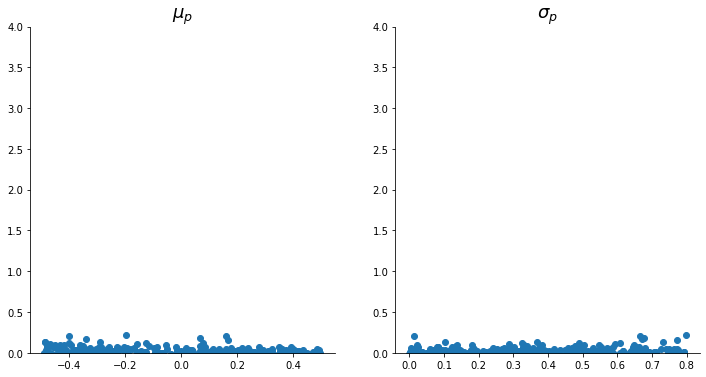

113


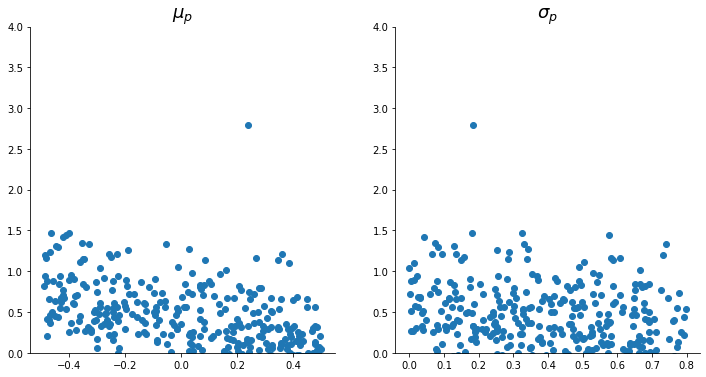

114


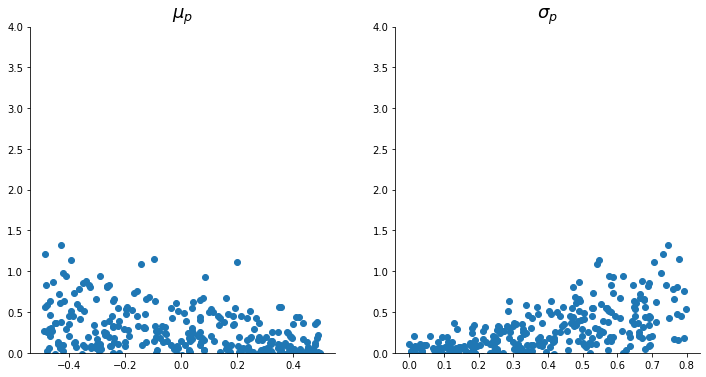

115


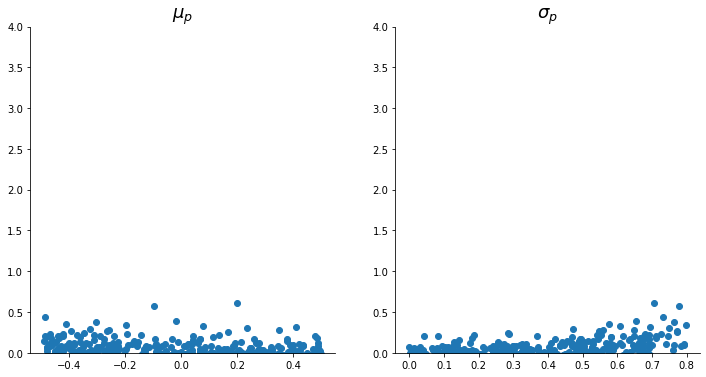

116


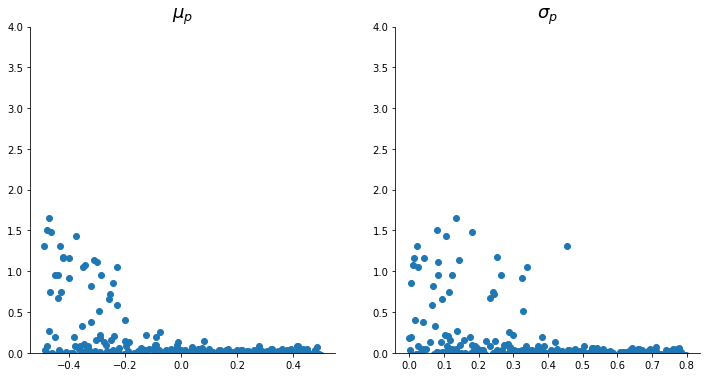

117


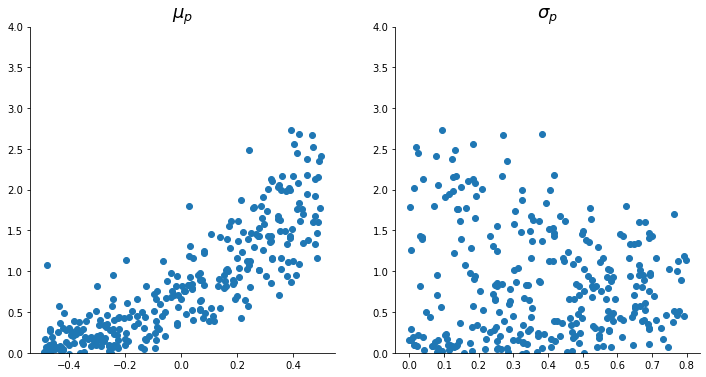

118


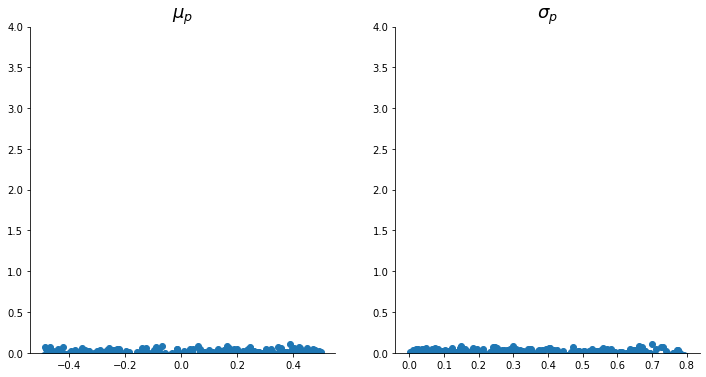

119


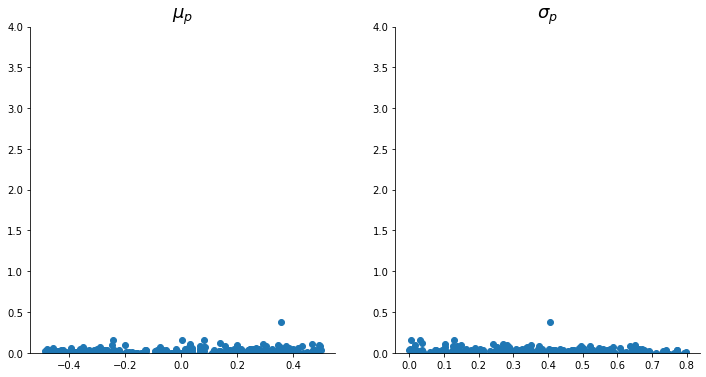

120


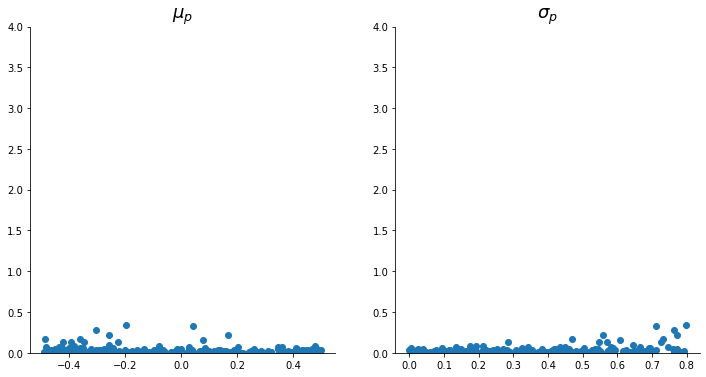

121


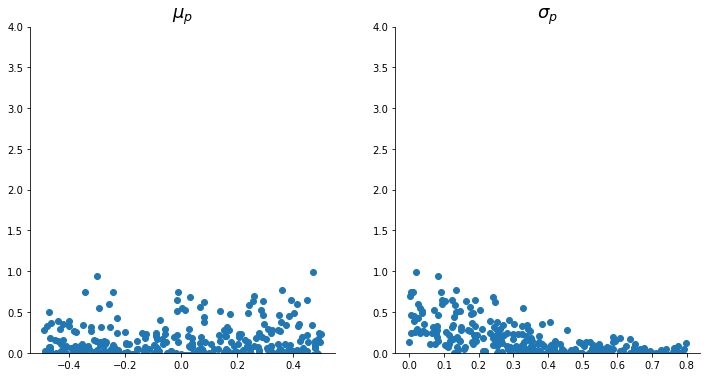

122


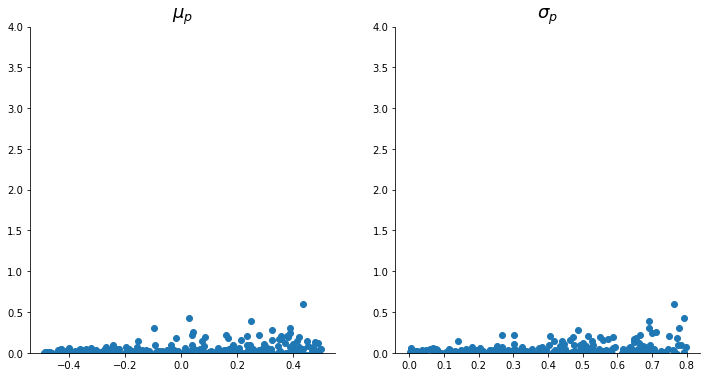

123


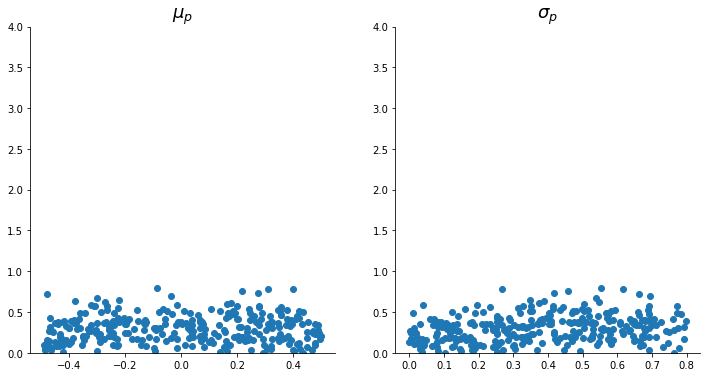

124


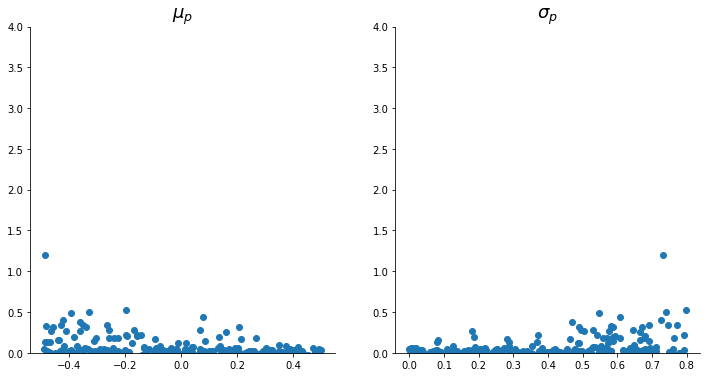

125


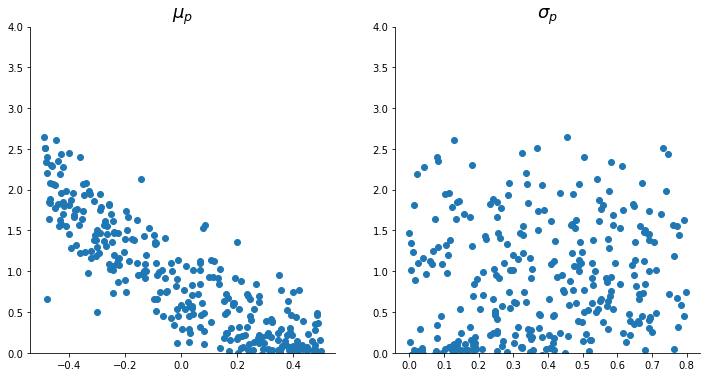

126


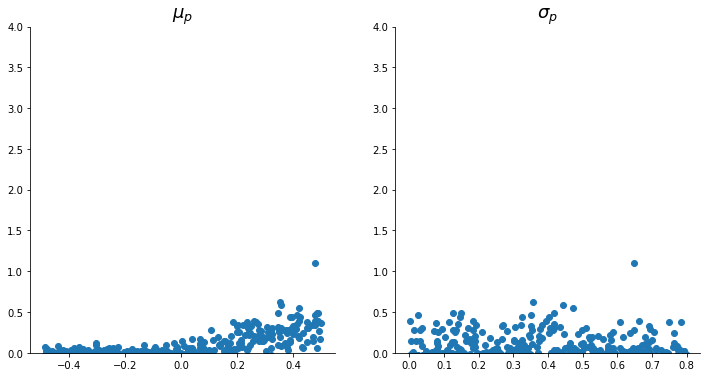

127


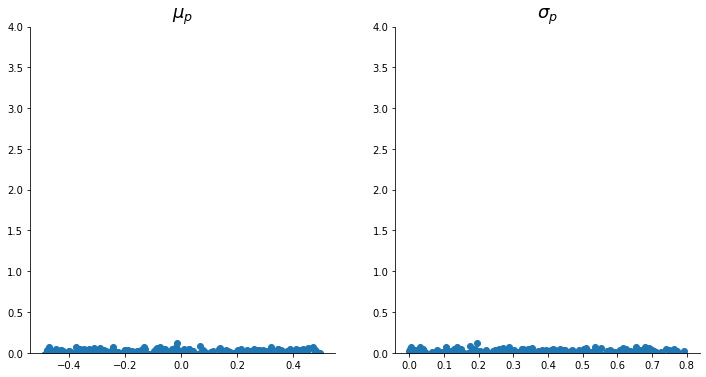

128


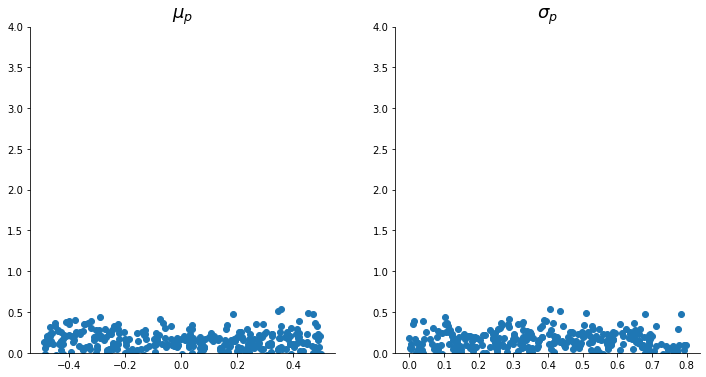

129


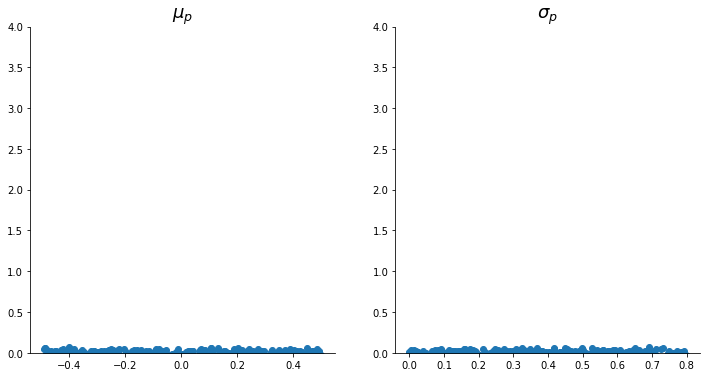

130


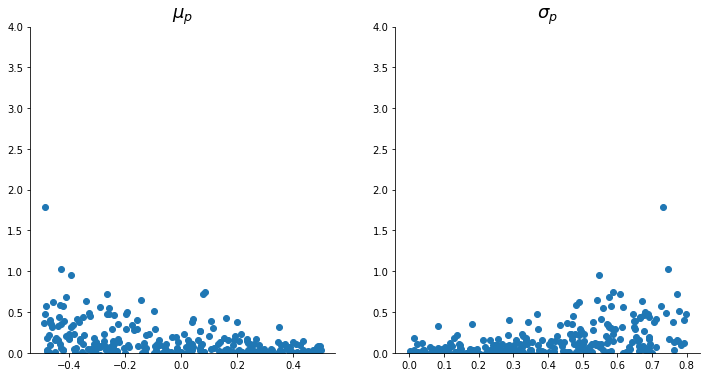

131


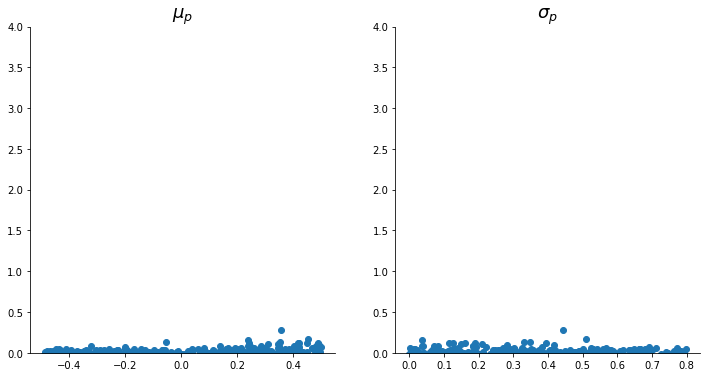

132


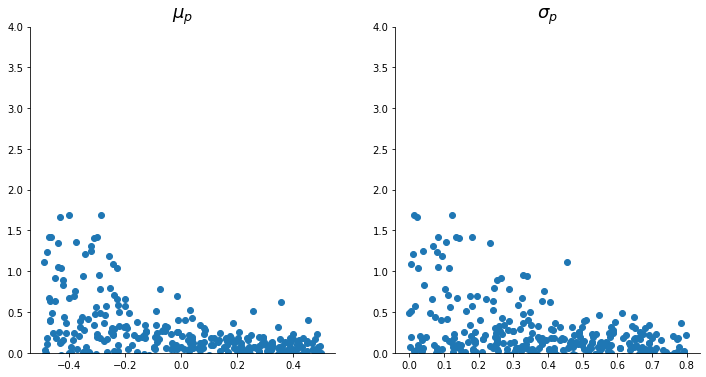

133


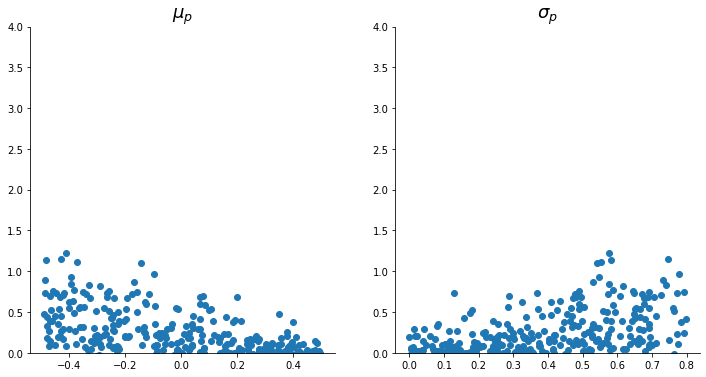

134


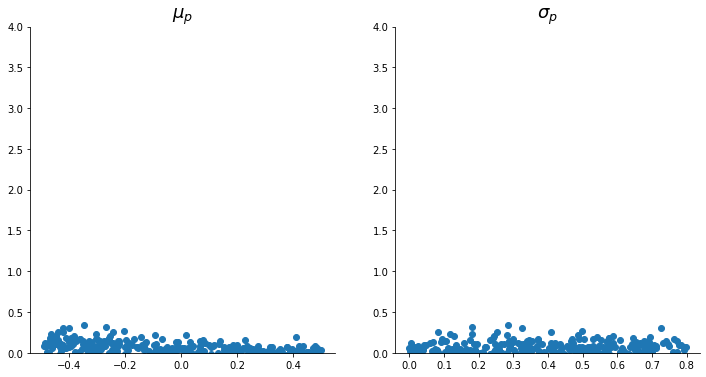

135


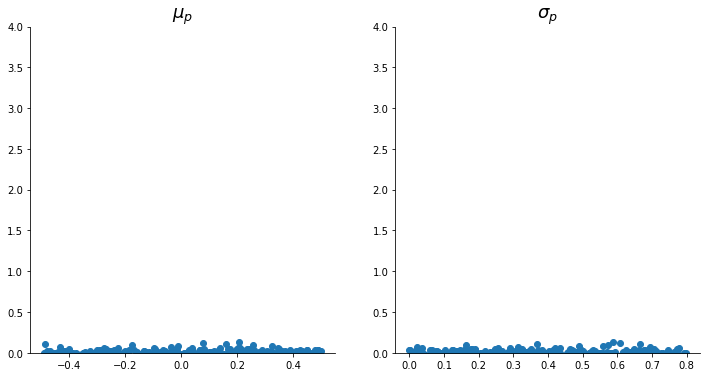

136


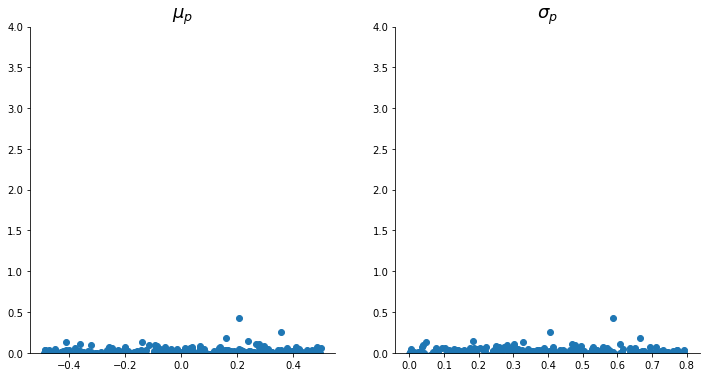

137


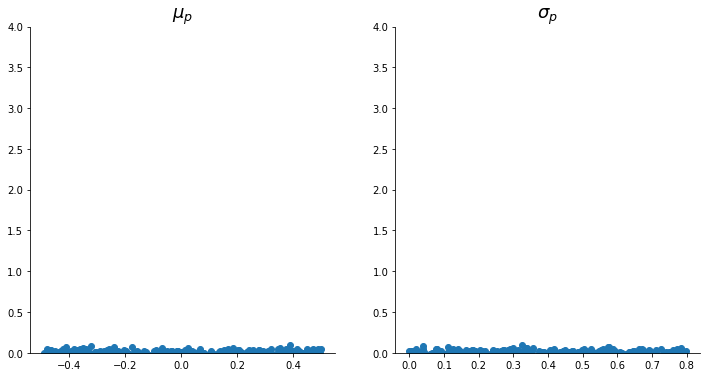

138


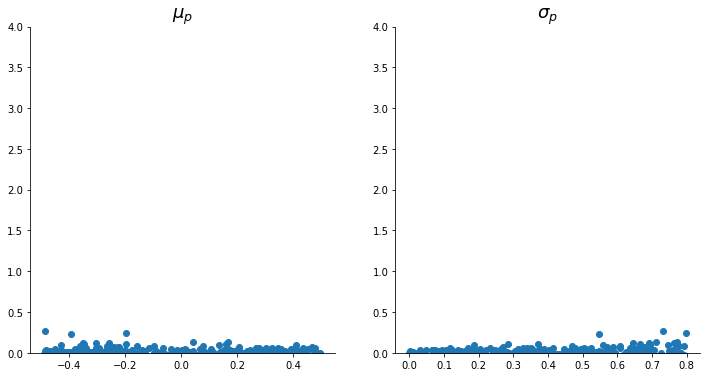

139


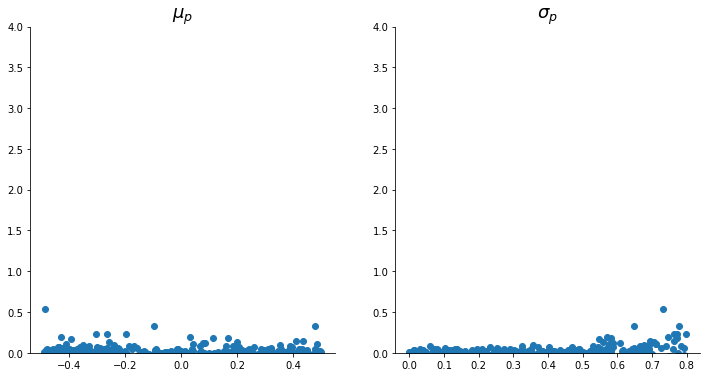

140


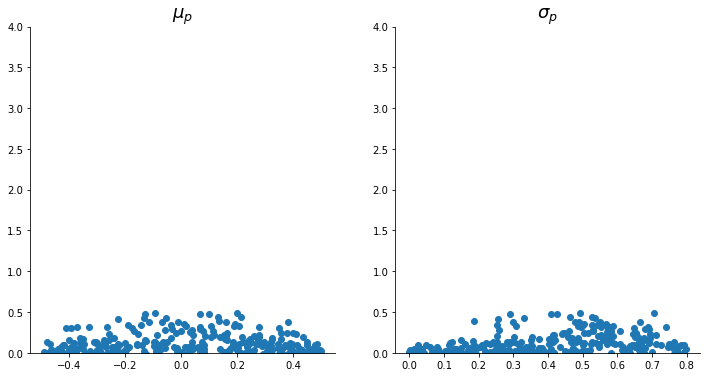

141


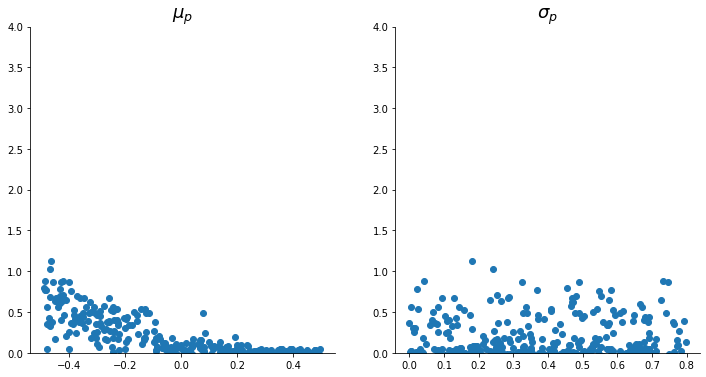

142


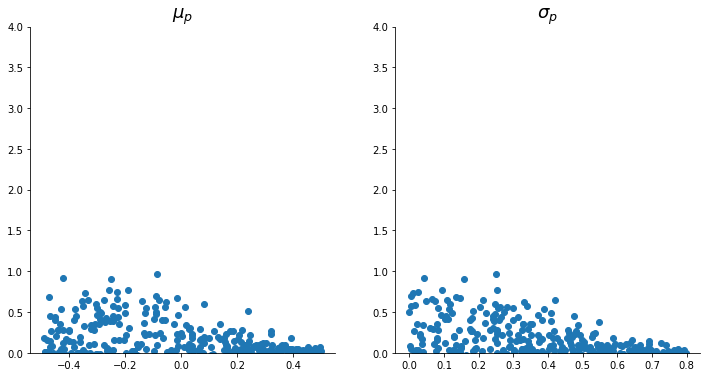

143


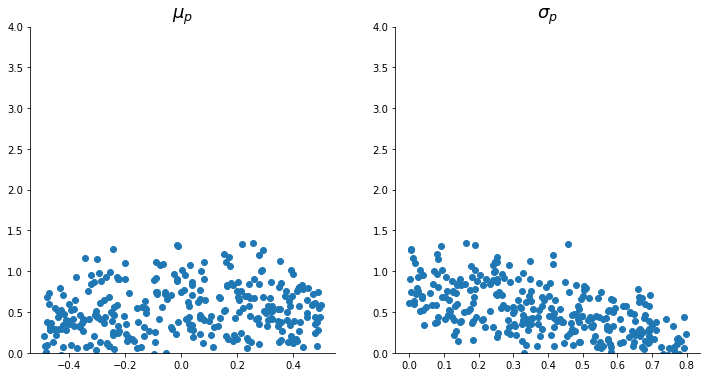

144


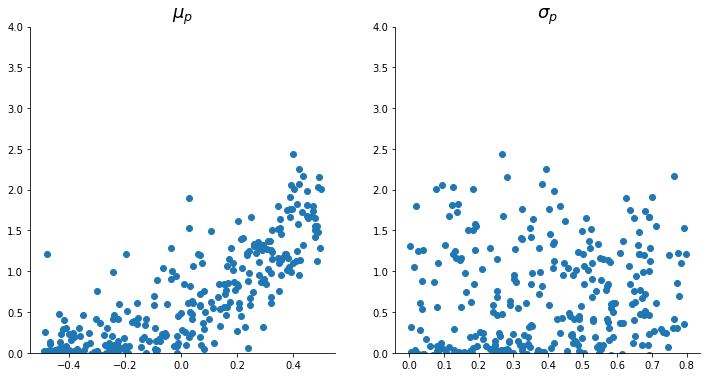

145


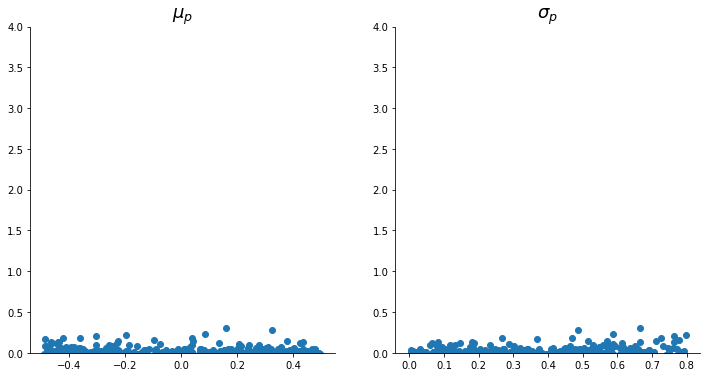

146


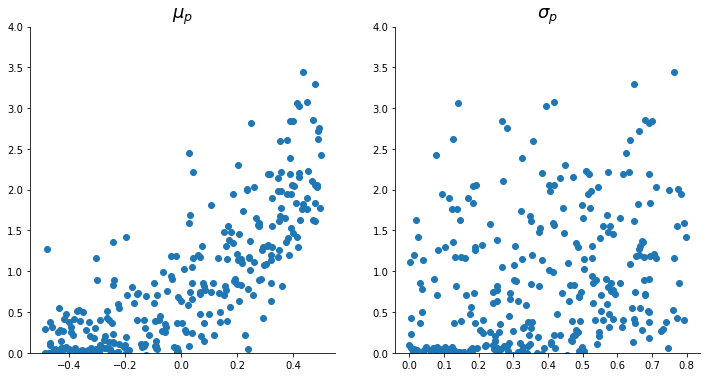

147


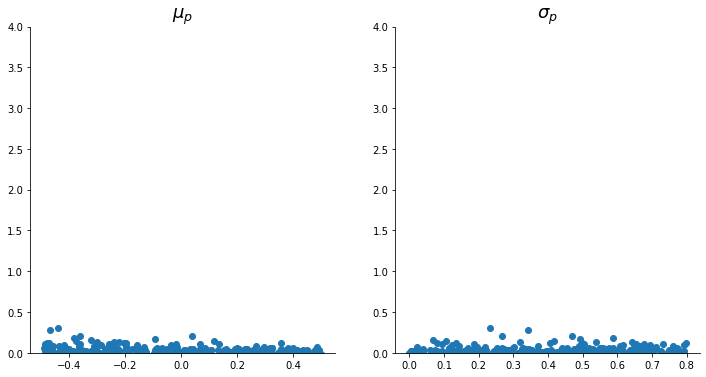

148


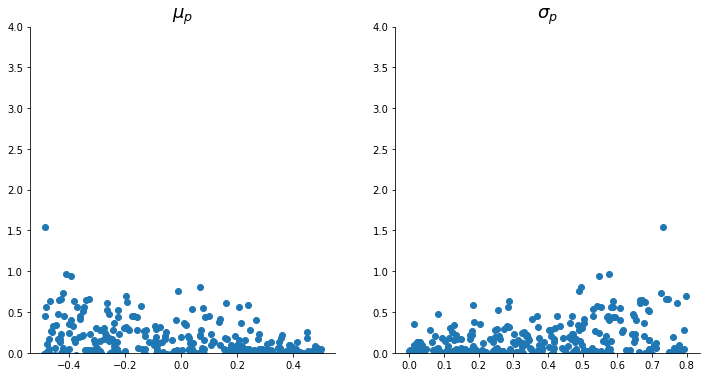

149


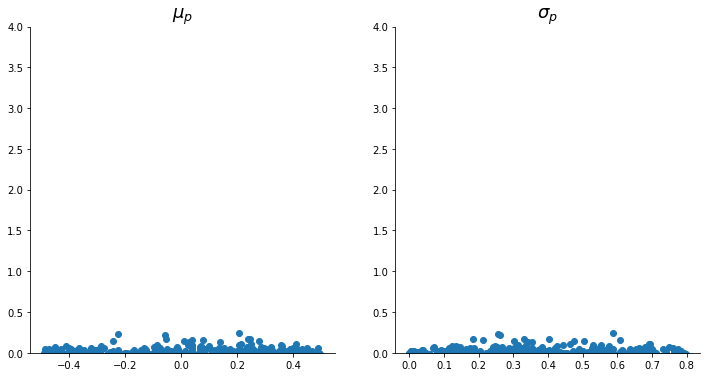

150


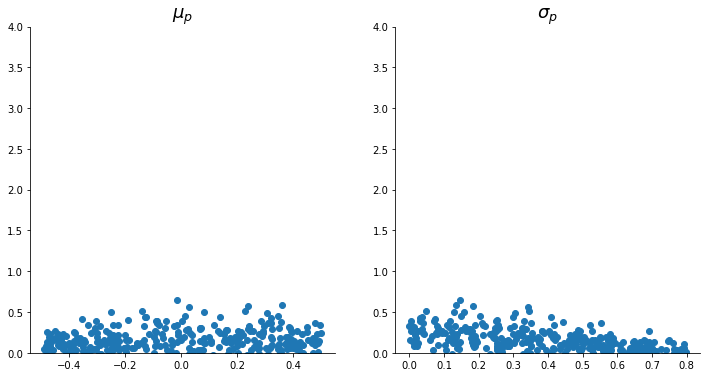

151


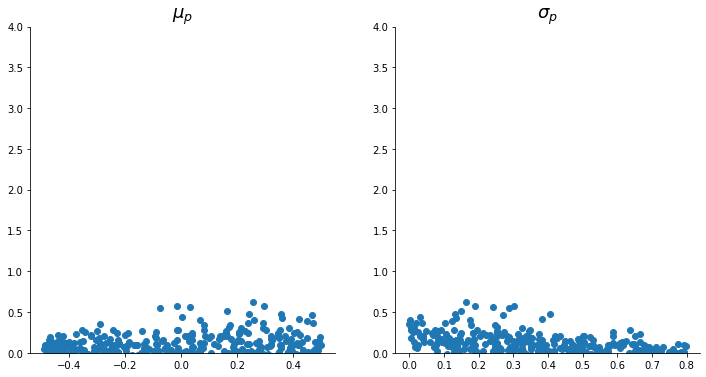

152


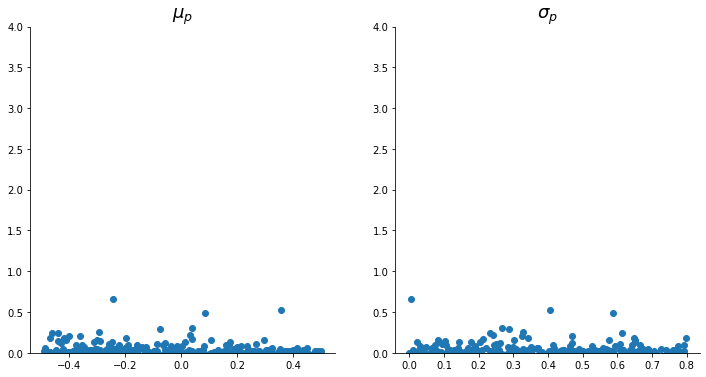

153


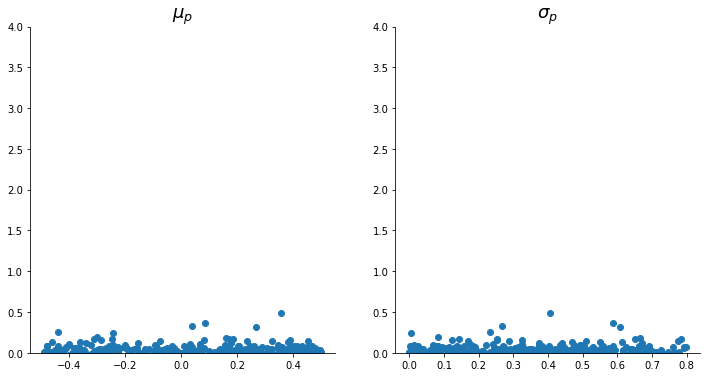

154


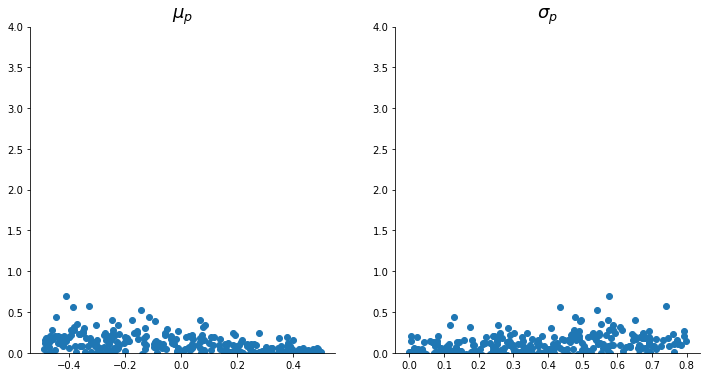

155


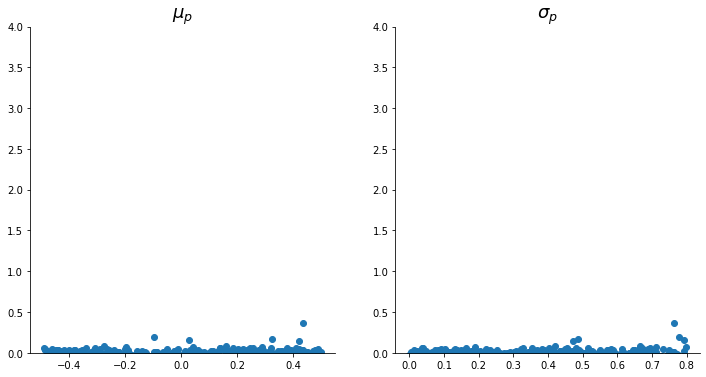

156


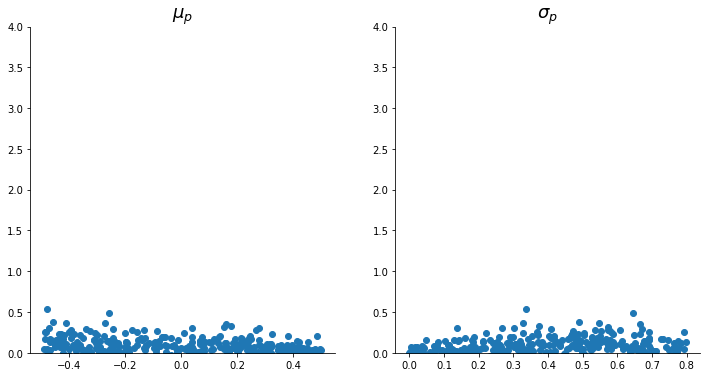

157


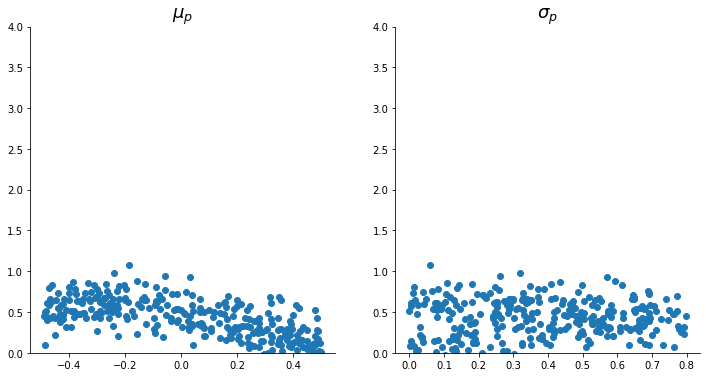

158


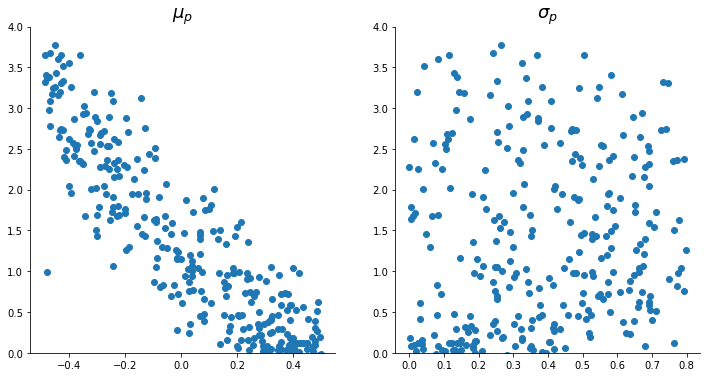

159


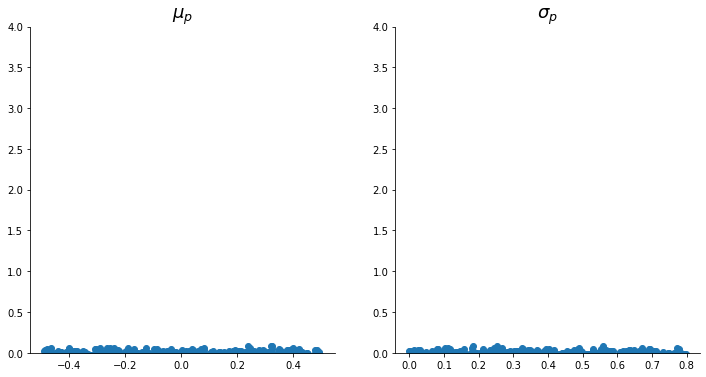

160


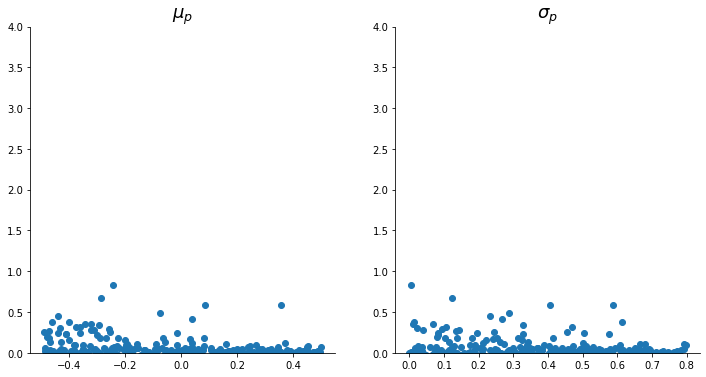

161


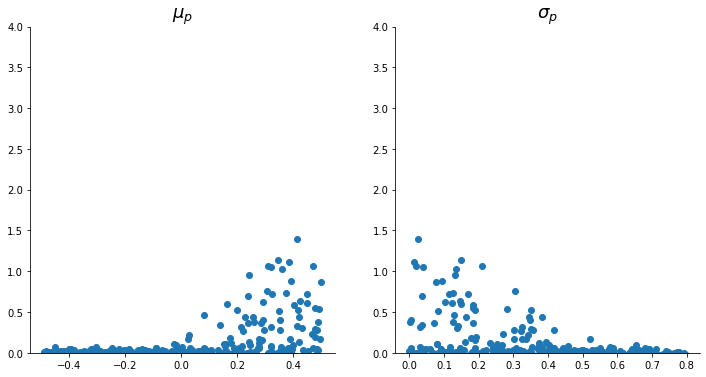

162


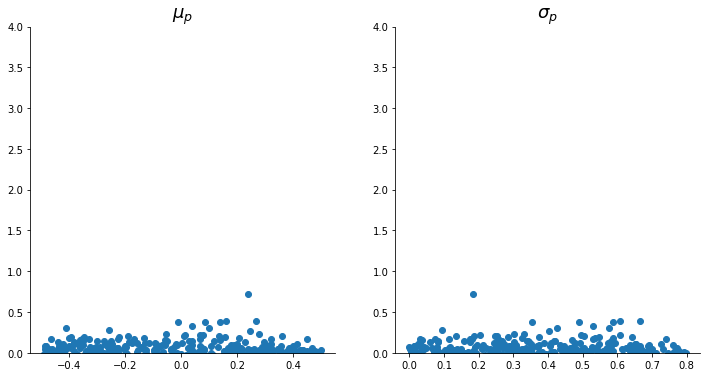

163


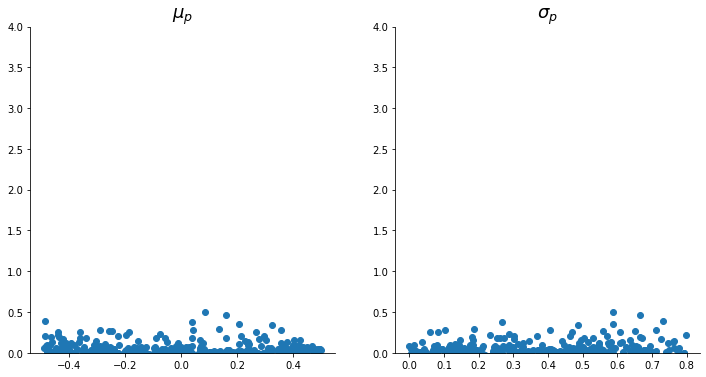

164


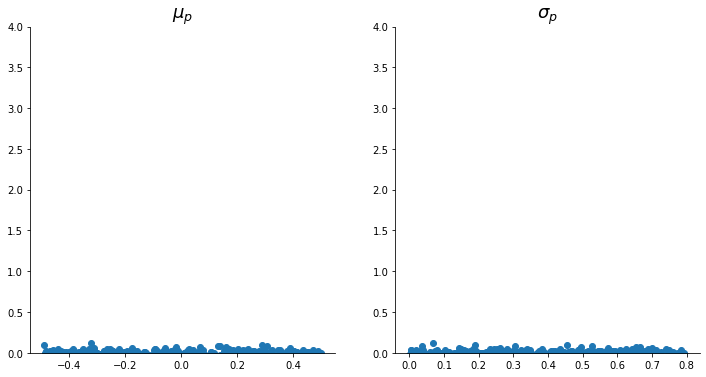

165


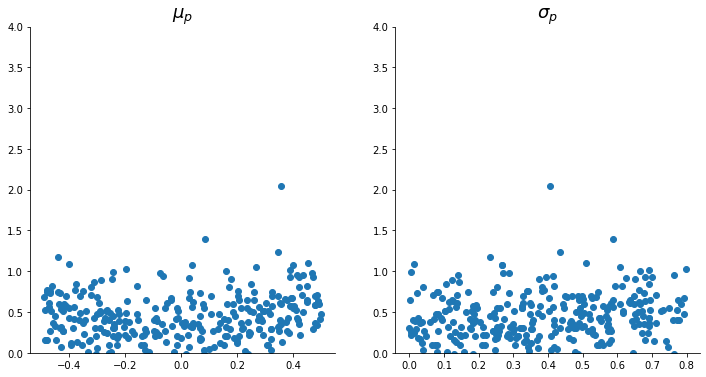

166


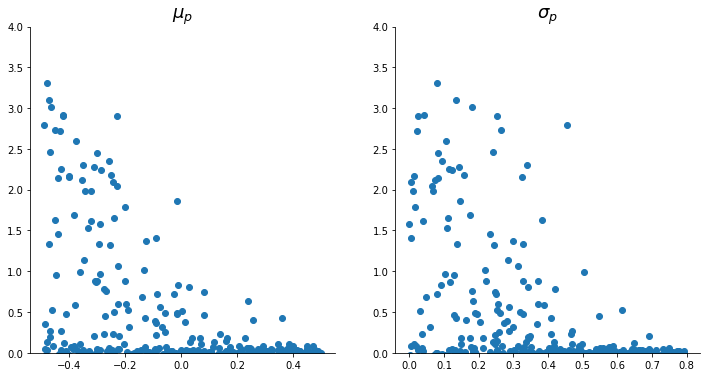

167


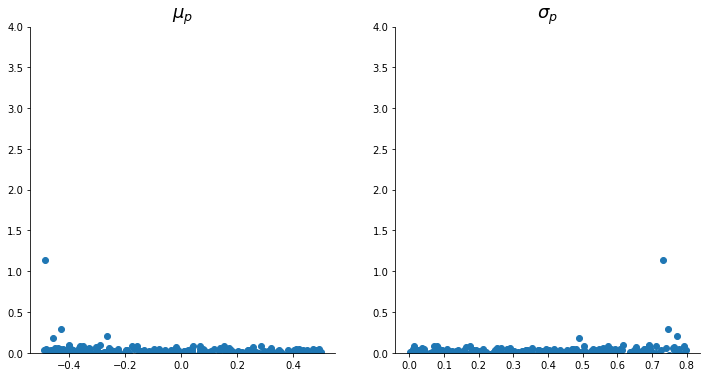

168


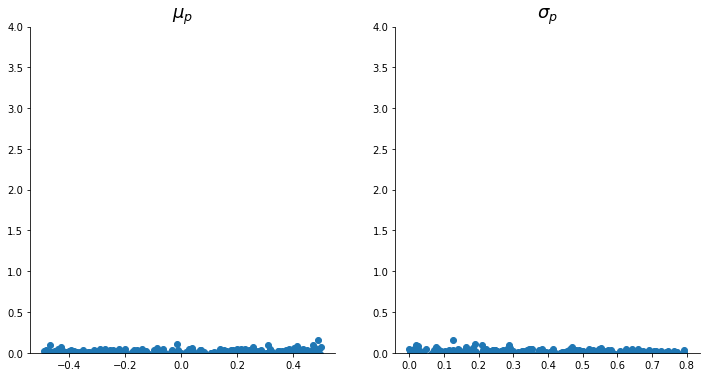

169


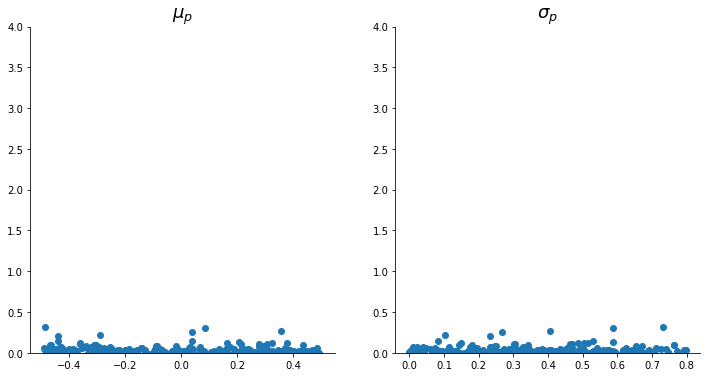

170


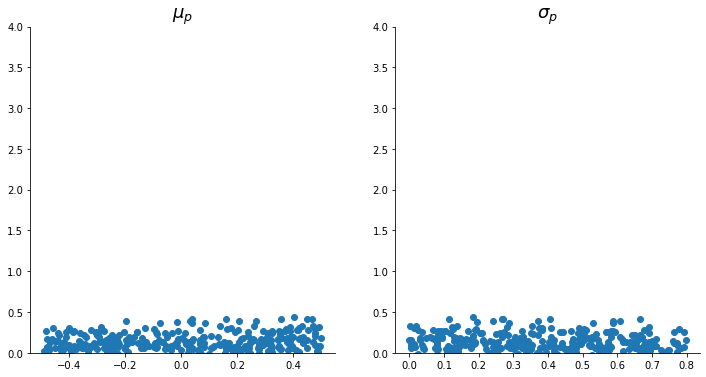

171


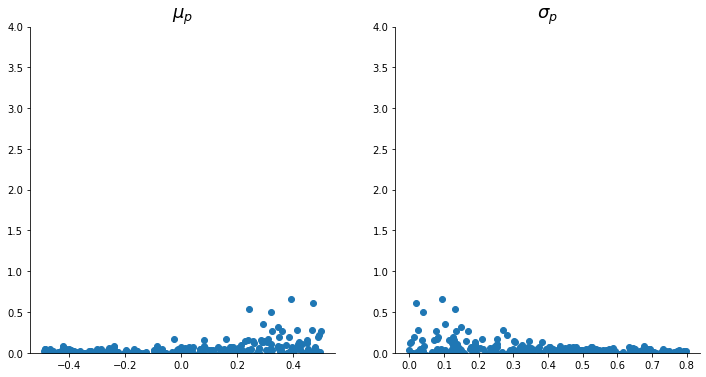

172


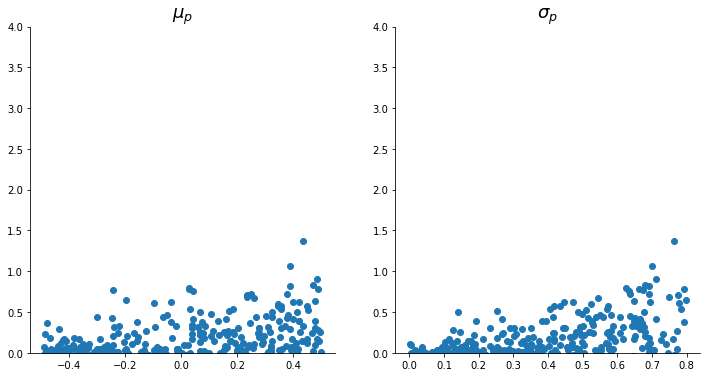

173


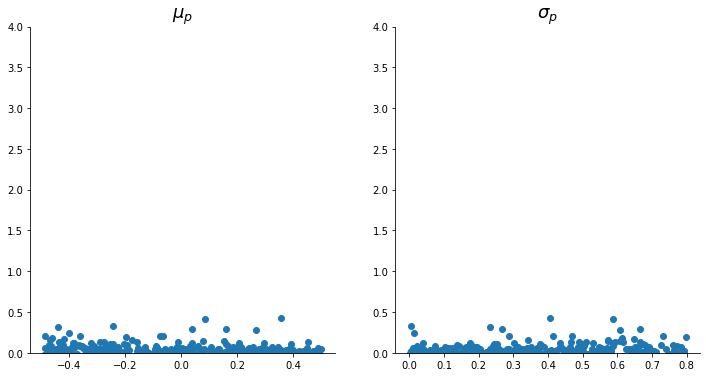

174


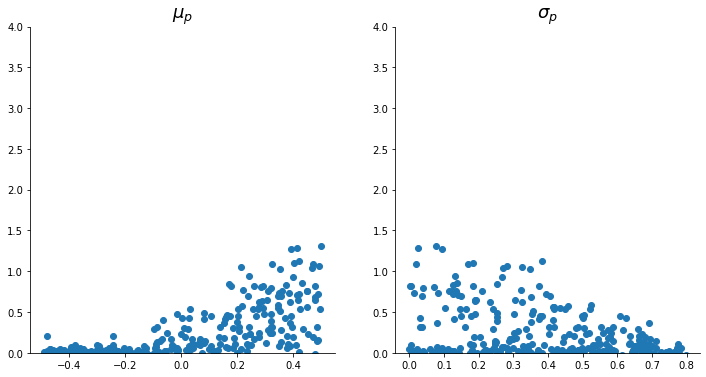

175


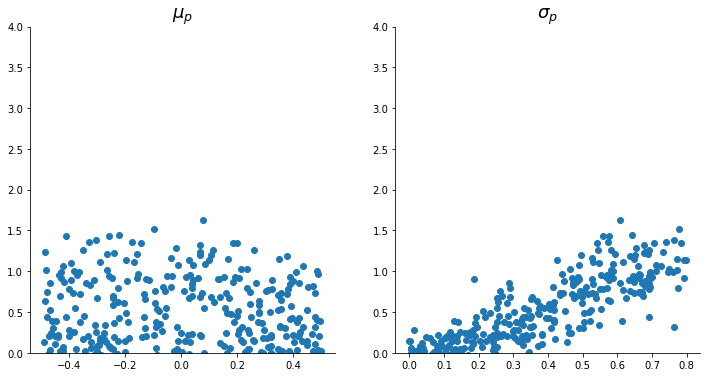

176


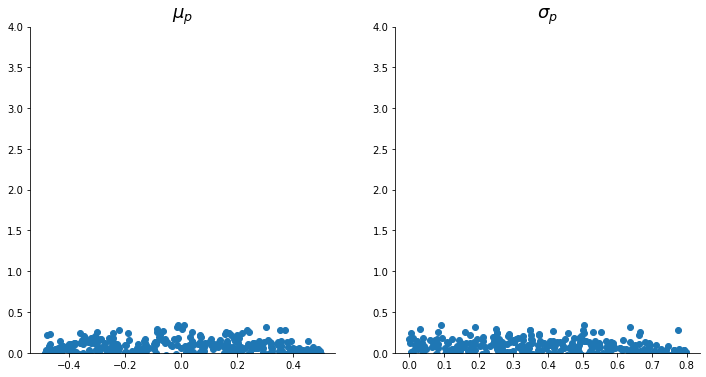

177


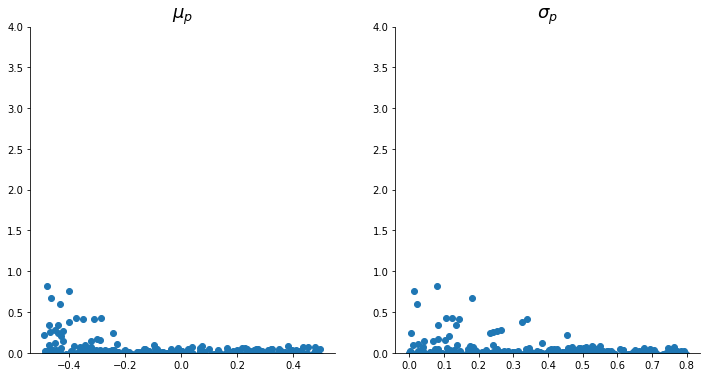

178


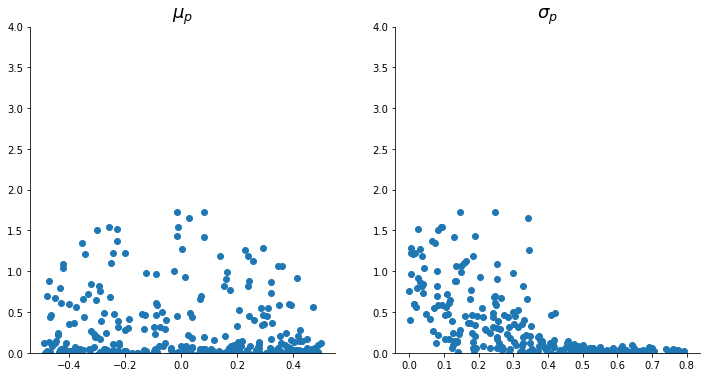

179


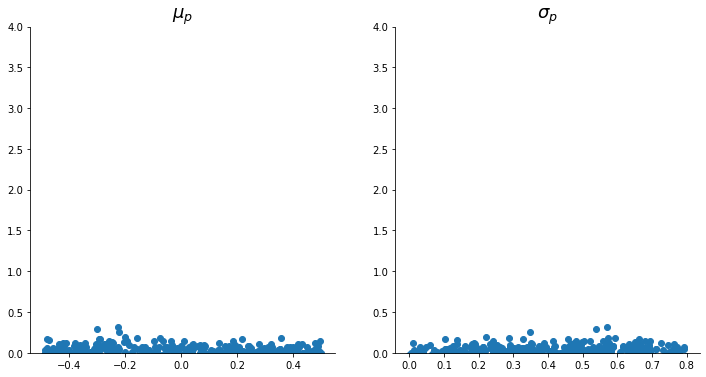

180


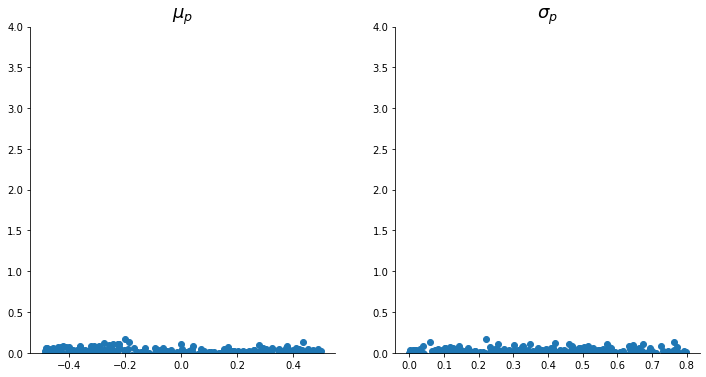

181


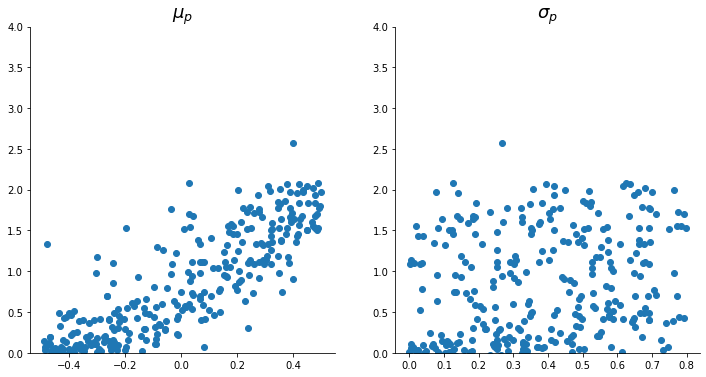

182


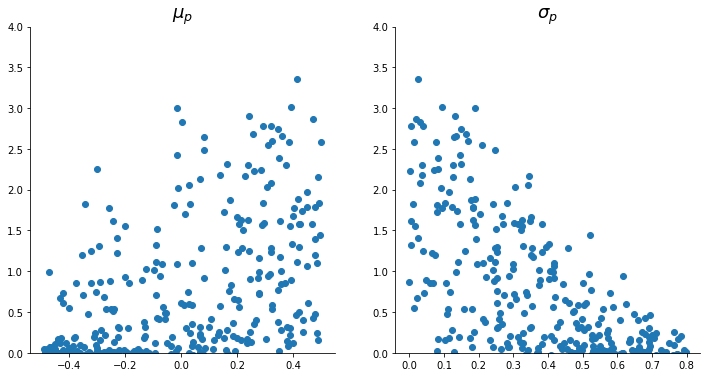

183


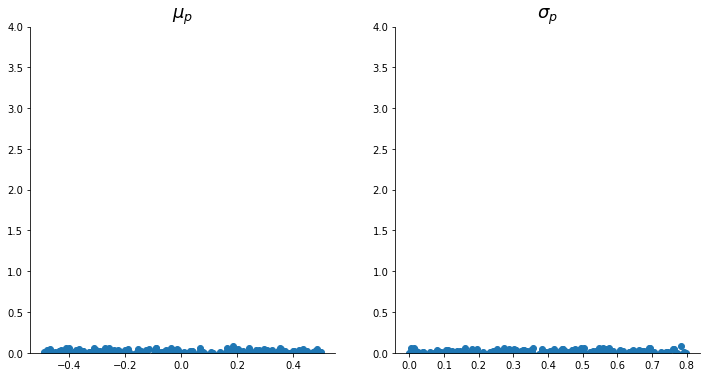

184


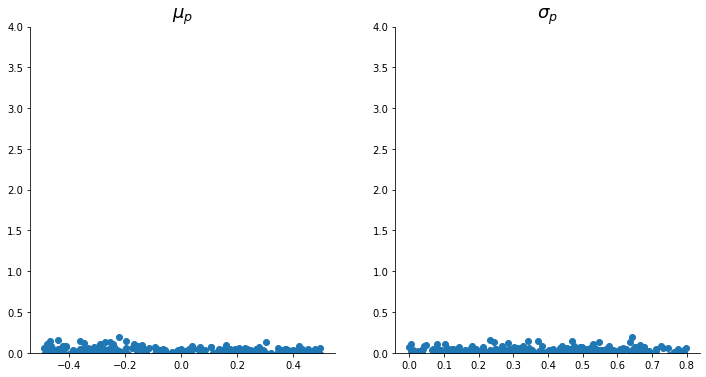

185


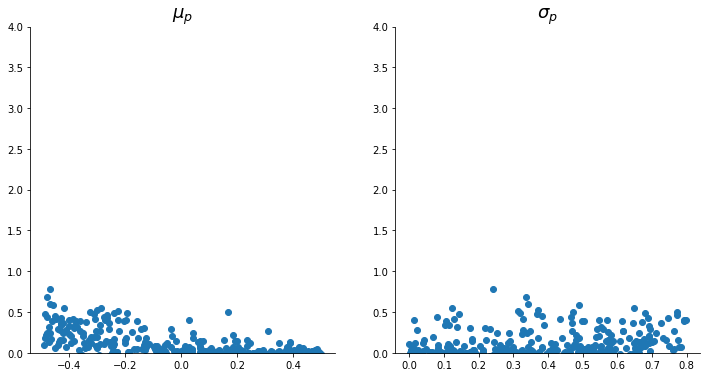

186


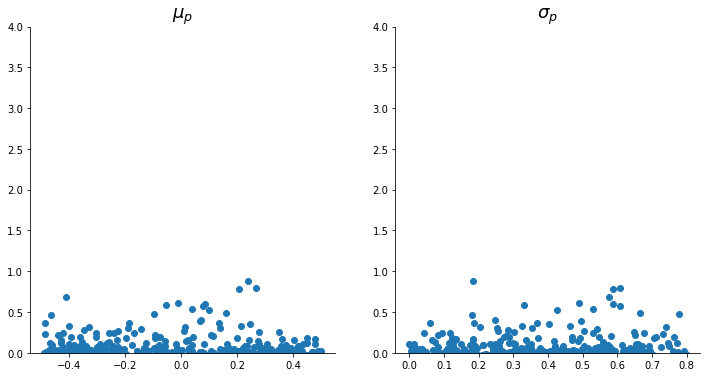

187


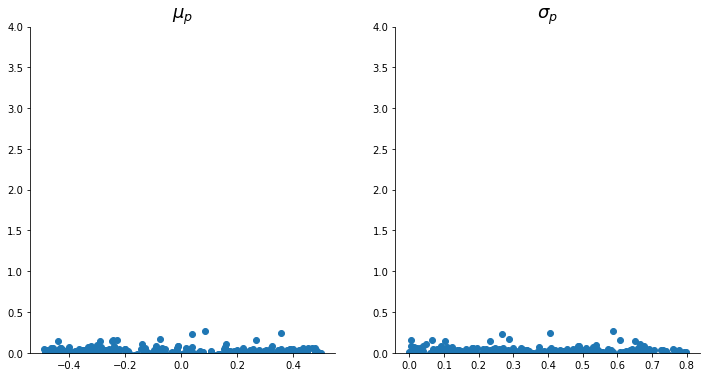

188


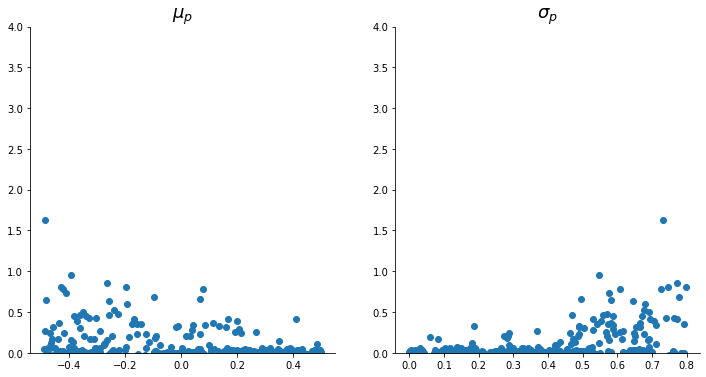

189


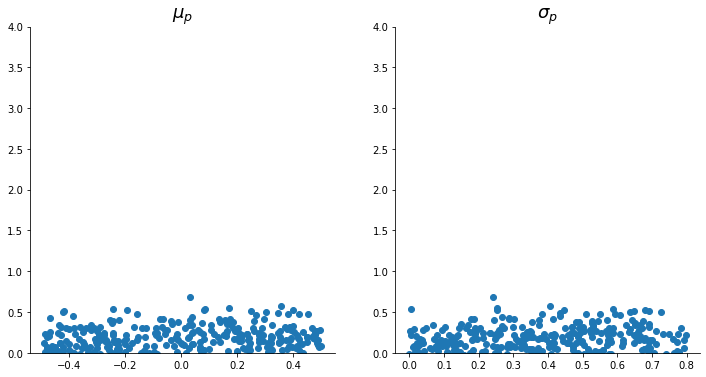

190


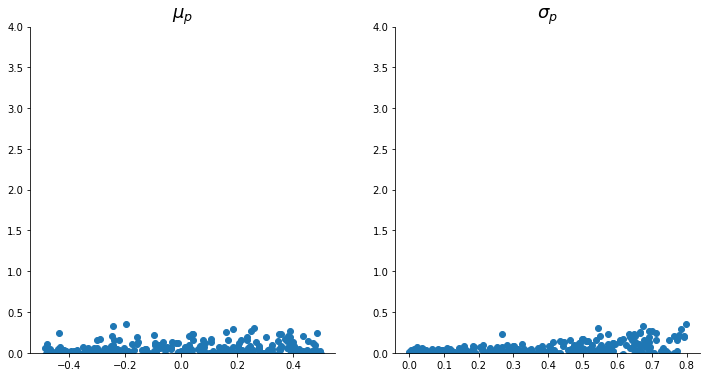

191


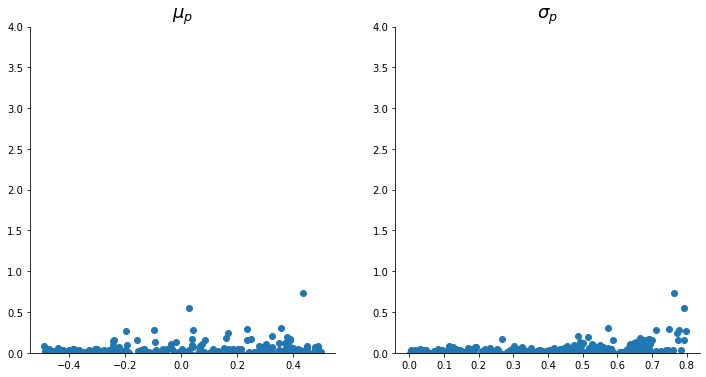

192


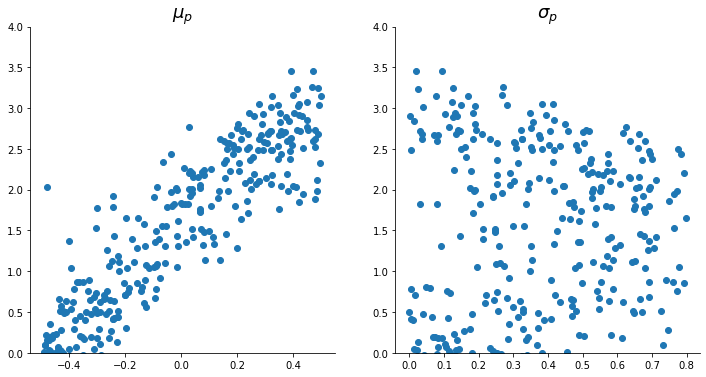

193


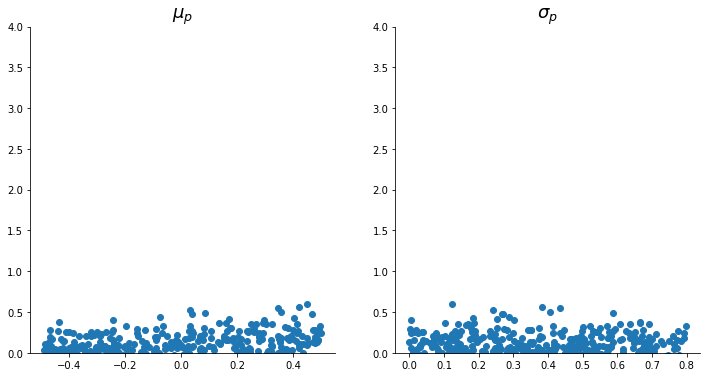

194


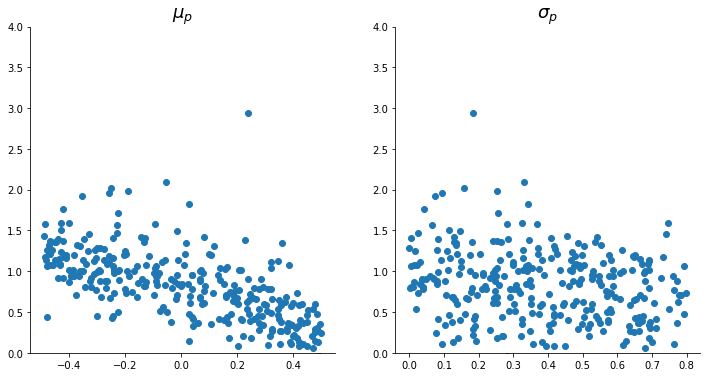

195


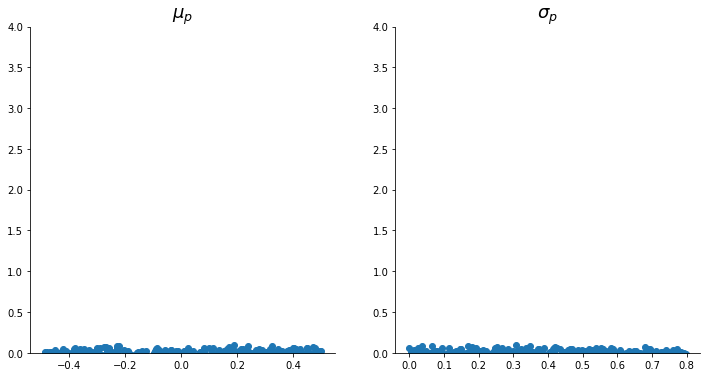

196


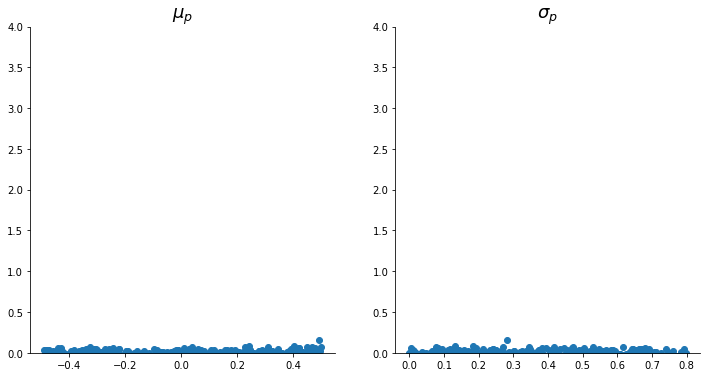

197


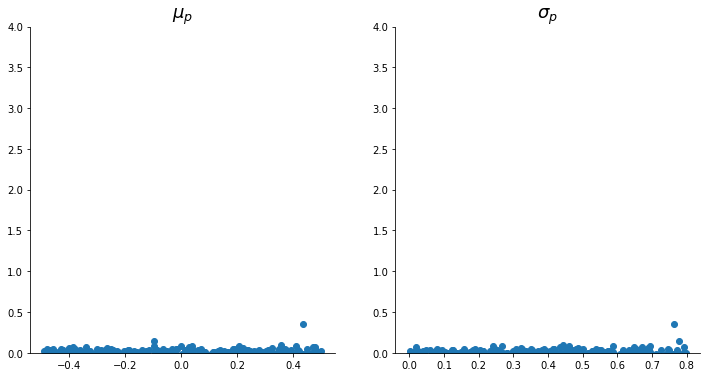

198


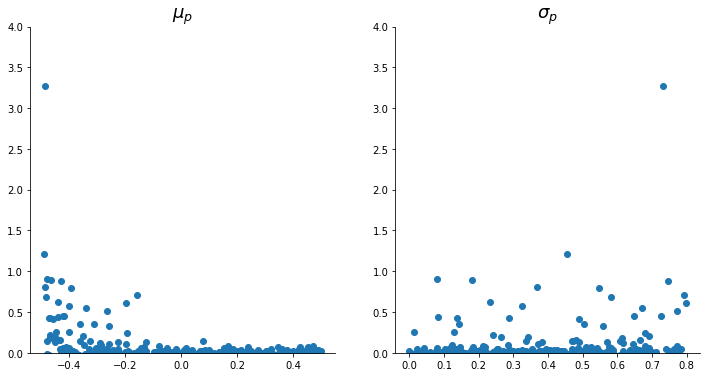

199


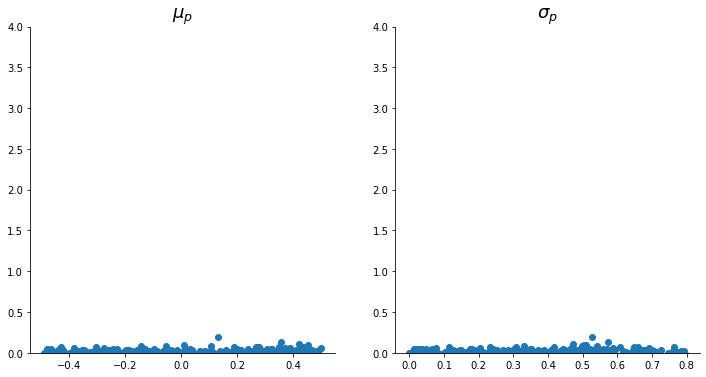

In [82]:
for i in range(200):
    print(i)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(
        mu_p_list,
        neural_last_10_average[:, i],
    )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.ylim([0, 4])
    plt.title(r'$\mu_p$', fontsize=18)
    
    plt.subplot(1, 2, 2)
    plt.scatter(
        sigma_p_list,
        neural_last_10_average[:, i],
    )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.title(r'$\sigma_p$', fontsize=18)
    plt.ylim([0, 4])
    plt.show()